In [1]:
#Irene (Rin) Mitsiades
#Rheinbay lab
#HOXB13 in breast cancer
#15/10/2024

import logging, sys
logging.disable(sys.maxsize)

#loading packages necessary to run notebook

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import colors
import matplotlib.colors
import seaborn as sns
import scipy
from scipy import stats
from scipy.stats import mannwhitneyu
from lifelines.statistics import logrank_test
from lifelines import KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test
from SigProfilerMatrixGenerator.scripts import CNVMatrixGenerator as scna
from SigProfilerExtractor import sigpro as sig
from scipy.stats import chi2_contingency
from SigProfilerMatrixGenerator.scripts import SigProfilerMatrixGeneratorFunc as matGen
import os.path
import glob
import fnmatch
import os
import shutil
from pathlib import Path
import matplotlib.patches as mpatches
from scipy.stats import fisher_exact
from lifelines.utils import median_survival_times
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
from SigProfilerAssignment import Analyzer as Analyze
from lifelines import CoxPHFitter
from pandas import ExcelWriter

#displays plots in notebook
%matplotlib inline

#default figure settings (text size, spines, etc.)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams["figure.autolayout"] = True

def listdir(dirname, pattern="*"):
    return fnmatch.filter(os.listdir(dirname), pattern)

#change outlier styling globally
flierprops = dict(marker='o', markerfacecolor="grey", markersize=4,  markeredgecolor='grey')

#DEFINITIONS
#0-1 copies = deletion
#2 copies = no change
#3-4 copies = gain
#5+ copies = high level amplification

In [2]:
#loading in TCGA data
#mRNA data from all cancers
pancancer_mRNA_data = pd.read_csv("Raw_data/EBPlusPlusAdjustPANCAN_IlluminaHiSeq_RNASeqV2.geneExp.tsv", sep='\t' , header=0, index_col=0, low_memory=False).apply(pd.to_numeric, errors='ignore')
#removing entrez ids
pancancer_mRNA_data.index = [w.split('|')[0] for w in pancancer_mRNA_data.index]
#clinical dataset with survival outcomes
pancancer_clinical_and_survival_data = pd.DataFrame(pd.read_excel("Raw_data/TCGA-CDR-SupplementalTableS1.xlsx", header=0, index_col=1)).apply(pd.to_numeric, errors='ignore')
#clinical dataset that includes receptor statuses for breast cancer
pancancer_followup_and_receptor_data = pd.read_csv("Raw_data/clinical_PANCAN_participant_with_followup.csv", sep = ",", header=0, index_col=1, low_memory=False).apply(pd.to_numeric, errors='ignore')

#general trimming of the TCGA data - shortening down names, checking the number of participants, etc.
#preparing the TCGA seg filee
mastercalls = pd.read_csv("Raw_data/TCGA_mastercalls.abs_segtabs.fixed.txt", sep='\t', index_col="Sample")
#shortening down the TCGA names
newnames = mastercalls.index.to_series().apply(lambda x: x[:12])
mastercalls.index = newnames

#mRNA 
#chopping samples into normal and tumor
sample_type = ['tumor' if ('-01A-' in x or '-01B-' in x or '-01C-' in x)  else 'normal' for x in pancancer_mRNA_data.columns.values]
zipped = pd.DataFrame(zip(list(pancancer_mRNA_data.columns.values), list(sample_type)), columns=['Sample_ID', 'Type'])
alltumors = zipped[zipped.Type=='tumor']['Sample_ID']
pancancer_mRNA_tumor_data = pancancer_mRNA_data[alltumors]

allnormals = zipped[zipped.Type=='normal']['Sample_ID']
pancancer_mRNA_normal_data= pancancer_mRNA_data[allnormals]
print('Total number of TCGA normal samples in PanCan mRNA dataset:', pancancer_mRNA_normal_data.shape[1])
print('Total number of TCGA tumor samples in PanCan mRNA dataset:', pancancer_mRNA_tumor_data.shape[1])

#shortening down the TCGA names
newindex = pancancer_mRNA_tumor_data.columns.to_series().apply(lambda x: x[:12])
pancancer_mRNA_tumor_data.columns = newindex



#picking out the breast cancer tumors
TCGA_BRCA_participants = pancancer_clinical_and_survival_data.loc[pancancer_clinical_and_survival_data.loc[:, "type"] == "BRCA"].index
TCGA_BRCA_mRNA_tumor_data = pancancer_mRNA_tumor_data.loc[:, np.in1d(pancancer_mRNA_tumor_data.columns, TCGA_BRCA_participants)]
TCGA_BRCA_followup_and_receptor_data = pancancer_followup_and_receptor_data.loc[np.in1d(pancancer_followup_and_receptor_data.index, TCGA_BRCA_participants)]
TCGA_BRCA_clinical_and_survival_data = pancancer_clinical_and_survival_data.loc[np.in1d(pancancer_clinical_and_survival_data.index, TCGA_BRCA_participants)]

print("")
print("After removing normals")
print('Total number of TCGA BRCA mRNA samples:', TCGA_BRCA_mRNA_tumor_data.shape[1])
print('Total number of TCGA BRCA clinical samples:', TCGA_BRCA_followup_and_receptor_data.shape[0])
print('Total number of TCGA BRCA survival samples:', TCGA_BRCA_clinical_and_survival_data.shape[0])

#keeping only participants that are listed in all of the datasets
shared_TCGA_BRCA_participants_across_datasets = mastercalls.index & TCGA_BRCA_mRNA_tumor_data.columns & TCGA_BRCA_followup_and_receptor_data.index & TCGA_BRCA_clinical_and_survival_data.index
TCGA_BRCA_mRNA_tumor_data = TCGA_BRCA_mRNA_tumor_data.loc[:, shared_TCGA_BRCA_participants_across_datasets]
TCGA_BRCA_followup_and_receptor_data = TCGA_BRCA_followup_and_receptor_data.loc[shared_TCGA_BRCA_participants_across_datasets]
TCGA_BRCA_clinical_and_survival_data = TCGA_BRCA_clinical_and_survival_data.loc[shared_TCGA_BRCA_participants_across_datasets]

print("")
print("After picking out participants present in all sets")
print('Total number of TCGA BRCA mRNA samples:', TCGA_BRCA_mRNA_tumor_data.shape[1])
print('Total number of TCGA BRCA clinical samples:', TCGA_BRCA_followup_and_receptor_data.shape[0])
print('Total number of TCGA BRCA survival samples:', TCGA_BRCA_clinical_and_survival_data.shape[0])


#creating receptor subtype and HER2 status datasets for later use
#picking participants for groups
TCGA_BRCA_HERnegERpos_participants = TCGA_BRCA_followup_and_receptor_data[(TCGA_BRCA_followup_and_receptor_data['breast_carcinoma_estrogen_receptor_status'] == 'Positive') & (TCGA_BRCA_followup_and_receptor_data['lab_proc_her2_neu_immunohistochemistry_receptor_status'] == 'Negative')].index
TCGA_BRCA_HERposERpos_participants = TCGA_BRCA_followup_and_receptor_data[(TCGA_BRCA_followup_and_receptor_data['breast_carcinoma_estrogen_receptor_status'] == 'Positive') & (TCGA_BRCA_followup_and_receptor_data['lab_proc_her2_neu_immunohistochemistry_receptor_status'] == 'Positive')].index
TCGA_BRCA_HERposERneg_participants = TCGA_BRCA_followup_and_receptor_data[(TCGA_BRCA_followup_and_receptor_data['breast_carcinoma_estrogen_receptor_status'] == 'Negative') & (TCGA_BRCA_followup_and_receptor_data['lab_proc_her2_neu_immunohistochemistry_receptor_status'] == 'Positive')].index
TCGA_BRCA_HERnegERneg_participants = TCGA_BRCA_followup_and_receptor_data[(TCGA_BRCA_followup_and_receptor_data['breast_carcinoma_estrogen_receptor_status'] == 'Negative') & (TCGA_BRCA_followup_and_receptor_data['lab_proc_her2_neu_immunohistochemistry_receptor_status'] == 'Negative')].index
TCGA_BRCA_HERpos_participants = TCGA_BRCA_followup_and_receptor_data[(TCGA_BRCA_followup_and_receptor_data['lab_proc_her2_neu_immunohistochemistry_receptor_status'] == 'Positive')].index
TCGA_BRCA_HERneg_participants = TCGA_BRCA_followup_and_receptor_data[(TCGA_BRCA_followup_and_receptor_data['lab_proc_her2_neu_immunohistochemistry_receptor_status'] == 'Negative')].index
TCGA_BRCA_ERpos_participants = TCGA_BRCA_followup_and_receptor_data[(TCGA_BRCA_followup_and_receptor_data['breast_carcinoma_estrogen_receptor_status'] == 'Positive')].index
TCGA_BRCA_ERneg_participants = TCGA_BRCA_followup_and_receptor_data[(TCGA_BRCA_followup_and_receptor_data['breast_carcinoma_estrogen_receptor_status'] == 'Negative')].index

print('Total number of BRCA ERpos samples:', len(TCGA_BRCA_ERpos_participants))
print('Total number of BRCA ERneg samples:', len(TCGA_BRCA_ERneg_participants))

print('Total number of BRCA HERnegERpos samples:', len(TCGA_BRCA_HERnegERpos_participants))
print('Total number of BRCA HERposERpos samples:', len(TCGA_BRCA_HERposERpos_participants))
print('Total number of BRCA HERposERneg samples:', len(TCGA_BRCA_HERposERneg_participants))
print('Total number of BRCA HERnegERneg samples:', len(TCGA_BRCA_HERnegERneg_participants))

#picking participants out from the RNA dataset
TCGA_BRCA_HERnegERpos_mRNA_data = TCGA_BRCA_mRNA_tumor_data.loc[:, TCGA_BRCA_HERnegERpos_participants]
TCGA_BRCA_HERposERpos_mRNA_data = TCGA_BRCA_mRNA_tumor_data.loc[:, TCGA_BRCA_HERposERpos_participants]
TCGA_BRCA_HERposERneg_mRNA_data = TCGA_BRCA_mRNA_tumor_data.loc[:, TCGA_BRCA_HERposERneg_participants]
TCGA_BRCA_HERnegERneg_mRNA_data = TCGA_BRCA_mRNA_tumor_data.loc[:, TCGA_BRCA_HERnegERneg_participants]
TCGA_BRCA_ERpos_mRNA_data = TCGA_BRCA_mRNA_tumor_data.loc[:, TCGA_BRCA_ERpos_participants]
TCGA_BRCA_ERneg_mRNA_data = TCGA_BRCA_mRNA_tumor_data.loc[:, TCGA_BRCA_ERneg_participants]

#picking participants out from the survival dataset
TCGA_BRCA_HERnegERpos_clinical_and_survival_data = TCGA_BRCA_clinical_and_survival_data.loc[TCGA_BRCA_HERnegERpos_participants]
TCGA_BRCA_HERposERpos_clinical_and_survival_data = TCGA_BRCA_clinical_and_survival_data.loc[TCGA_BRCA_HERposERpos_participants]
TCGA_BRCA_HERposERneg_clinical_and_survival_data = TCGA_BRCA_clinical_and_survival_data.loc[TCGA_BRCA_HERposERneg_participants]
TCGA_BRCA_HERnegERneg_clinical_and_survival_data = TCGA_BRCA_clinical_and_survival_data.loc[TCGA_BRCA_HERnegERneg_participants]
TCGA_BRCA_ERpos_clinical_and_survival_data = TCGA_BRCA_clinical_and_survival_data.loc[TCGA_BRCA_ERpos_participants]
TCGA_BRCA_ERneg_clinical_and_survival_data = TCGA_BRCA_clinical_and_survival_data.loc[TCGA_BRCA_ERneg_participants]
TCGA_BRCA_ERpos_clinical_and_survival_data = TCGA_BRCA_ERpos_clinical_and_survival_data.iloc[:, [24,25,30,31]]
TCGA_BRCA_ERneg_clinical_and_survival_data = TCGA_BRCA_ERneg_clinical_and_survival_data.iloc[:, [24,25,30,31]]

#all figures in this paper are generated using the TCGA modal copy number (absolute number of copies). This code prepares the TCGA seg file to be read by bedtools.
#awk '$3>0 {print $1, int($2), int($3), int($4), int($5), int($9)}' OFS='\t' TCGA_mastercalls.abs_segtabs.fixed.txt | grep -v Sample | awk 'BEGIN{print "Sample\tChromosome\tStart\tEnd\tNum_Probes\tModal_Total_CN"}{print}' - > TCGA_mastercalls.abs_segtabs.fixed.IGV.seg 
#This code was run first to make the seg file IGV readable

#Genes of interest:
#17	46802125	46806111	HOXB13
#17	37844337	37873910	ERBB2
#17	41196312	41276132	BRCA1
#17	40351195	40428409	STAT5B
#17	43340486	43394386	MAP3K14
#17	38710021	38716646	CCR7
#17	40852293	40897058	EZH1
#17	45286428	45301045	MYL4

#adding these locations to their own dataframe
selected_gene_data = {'Gene name': ['HOXB13', 'ERBB2', 'BRCA1', 'STAT5B', 'MAP3K14', 'CCR7', 'EZH1', 'MYL4'], 'Chromosome': ['17', '17', '17', '17', '17', '17', '17', '17'], 'Start': [46802125, 37844337, 41196312, 40351195, 43340486, 38710021, 40852293, 45286428], 'End':  [46806111, 37873910, 41276132, 40428409, 43394386, 38716646, 40897058, 45301045]}
selected_locations = pd.DataFrame (selected_gene_data, columns = ['Chromosome','Start', 'End', 'Gene name'])
selected_locations.to_csv("selected_gene_locations.txt", sep='\t', index=False, header=False)

#picking breast cancer participants
BRCA_calls = mastercalls.loc[np.in1d(mastercalls.index, shared_TCGA_BRCA_participants_across_datasets)]
print("Number of BRCA cancer participants initally:", len(shared_TCGA_BRCA_participants_across_datasets))
print("Number of BRCA cancer participants that have clinical and modal copy number data:", len(set(BRCA_calls.index)))

#reset the index
BRCA_calls = BRCA_calls.reset_index()
BRCA_calls = BRCA_calls[~BRCA_calls['Chromosome'].isnull()]

#Dropping columns that won't be used: saves bedtools compute time
drop_columns = [4,5,6,7,9,10,11,12,13,14,15,16,17,18,19]
BRCA_calls.drop(BRCA_calls.columns[drop_columns], axis=1, inplace=True)

#turning this into bedfile format to be inputted into bedtools
BRCA_calls = BRCA_calls[['Chromosome', 'Start', 'End', 'Sample', "Modal_Total_CN"]]
BRCA_calls['Chromosome'] = BRCA_calls['Chromosome'].astype(int)
BRCA_calls['Start'] = BRCA_calls['Start'].astype(int)
BRCA_calls['End'] = BRCA_calls['End'].astype(int)
BRCA_calls['Modal_Total_CN'] = BRCA_calls['Modal_Total_CN'].astype(float)
BRCA_calls.to_csv("BRCA_READY_TCGA_mastercalls.abs_segtabs.fixed.txt", sep='\t', index=False, header=False)

#now this will be run through bedtools
#bedtools command:
#bedtools intersect -a BRCA_READY_TCGA_mastercalls.abs_segtabs.fixed.txt -b selected_gene_locations.txt -wo > BRCA_TCGA_modalcopynumbercalls.txt

#reading from outputted text file of modal copy number calls
TCGA_BRCA_modalCNcalls = pd.read_csv("Raw_data/BRCA_TCGA_modalcopynumbercalls.txt", sep = "\t", index_col = 0, names = ["Chromosome", "Start location of CN segment", "End location of CN segment", "participant", "Copy number", "Chromosome_again", "Start location of gene", "End location of gene", "Gene", "Gene length"])
#removing unecessary columns
TCGA_BRCA_modalCNcalls = TCGA_BRCA_modalCNcalls.drop(["Gene length", "Chromosome_again", "Start location of gene", "End location of gene"], axis = 1)
TCGA_BRCA_modalCNcalls["Segment_length"] = TCGA_BRCA_modalCNcalls["End location of CN segment"] - TCGA_BRCA_modalCNcalls["Start location of CN segment"]
TCGA_BRCA_modalCNcalls.index = TCGA_BRCA_modalCNcalls.loc[:, "participant"]
TCGA_BRCA_modalCNcalls = TCGA_BRCA_modalCNcalls[['Copy number', 'Gene', 'Segment_length']]

print("Number of TCGA BRCA participants that have modal copy number calls:", len(set(TCGA_BRCA_modalCNcalls.index)))
#making individual dataframes for each gene calls

gene_list = list(set(TCGA_BRCA_modalCNcalls["Gene"]))
dataframe_list = []
for x in list(set(TCGA_BRCA_modalCNcalls["Gene"])):
    dataframe_list.append('TCGA_BRCA_callsonly' + str(x))

Dictionary = {}
 
for i in range(0, len(dataframe_list)):
    Dictionary[dataframe_list[i]] = pd.DataFrame()
    Dictionary[dataframe_list[i]] = pd.DataFrame(data = TCGA_BRCA_modalCNcalls.loc[TCGA_BRCA_modalCNcalls.loc[:, "Gene"] == gene_list[i]])
    #removing duplicate values by taking the average
    Dictionary[dataframe_list[i]] = Dictionary[dataframe_list[i]].groupby('participant').mean().reset_index()
    Dictionary[dataframe_list[i]].index = Dictionary[dataframe_list[i]]["participant"]
    Dictionary[dataframe_list[i]] = Dictionary[dataframe_list[i]][['Copy number', 'Segment_length']]
    Dictionary[dataframe_list[i]]["Gene name"] = gene_list[i]
    #annotating
    Dictionary[dataframe_list[i]].loc[:, "ER status"] = "N/A"
    Dictionary[dataframe_list[i]].loc[np.in1d(Dictionary[dataframe_list[i]].index, TCGA_BRCA_ERpos_participants), "ER status"] = "Pos"
    Dictionary[dataframe_list[i]].loc[np.in1d(Dictionary[dataframe_list[i]].index, TCGA_BRCA_ERneg_participants), "ER status"] = "Neg"
    Dictionary[dataframe_list[i]].loc[:, "HER2 status"] = "N/A"
    Dictionary[dataframe_list[i]].loc[np.in1d(Dictionary[dataframe_list[i]].index, TCGA_BRCA_HERpos_participants), "HER2 status"] = "Pos"
    Dictionary[dataframe_list[i]].loc[np.in1d(Dictionary[dataframe_list[i]].index, TCGA_BRCA_HERneg_participants), "HER2 status"] = "Neg"
    Dictionary[dataframe_list[i]].loc[:, "HOXB13 mRNA"] = TCGA_BRCA_mRNA_tumor_data.loc["HOXB13"]
    print("Number of TCGA participants that have modal copy number calls for this gene:", gene_list[i], len(Dictionary[dataframe_list[i]].index))
    #putting into individual dataframes
    for name, df in Dictionary.items():
        globals()[name] = df
    

#loading in CCLE data
CCLE_allcelllines_CN_data = pd.read_csv("Raw_data/CCLE_gene_cn.csv", sep=',', header=0, index_col=0, low_memory=False)
CCLE_allcelllines_clinicalinfo = pd.read_csv("Raw_data/CCLE_Model.csv", sep=',', header=0, index_col=0, low_memory=False)

#picking gap, cogain, and erbb2 only participants based on GISTIC output
pancancer_gistic_output_copynumber_data = pd.read_csv("Raw_data/all_thresholded.by_genes_whitelisted.tsv", sep = "\t", header=0, index_col=0, low_memory=False).apply(pd.to_numeric, errors='ignore')
#chopping samples into normal and tumor
sample_type = ['tumor' if ('-01A-' in x or '-01B-' in x or '-01C-' in x)  else 'normal' for x in pancancer_gistic_output_copynumber_data.columns.values]
zipped = pd.DataFrame(zip(list(pancancer_gistic_output_copynumber_data.columns.values), list(sample_type)), columns=['Sample_ID', 'Type'])
alltumors = zipped[zipped.Type=='tumor']['Sample_ID']
pancancer_tumor_copynumber_data = pancancer_gistic_output_copynumber_data[alltumors]

allnormals = zipped[zipped.Type=='normal']['Sample_ID']
pancancer_normal_copynumber_data = pancancer_gistic_output_copynumber_data[allnormals]
print('Total number of TCGA normal samples in PanCan GISTIC2.0 copy number dataset:', pancancer_normal_copynumber_data.shape[1])
print('Total number of TCGA tumor samples in PanCan GISTIC2.0 copy number dataset:', pancancer_tumor_copynumber_data.shape[1])

#shortening down the TCGA names
newindex = pancancer_tumor_copynumber_data.columns.to_series().apply(lambda x: x[:12])
pancancer_tumor_copynumber_data.columns = newindex
TCGA_BRCA_tumor_copynumber_data = pancancer_tumor_copynumber_data.loc[:, np.in1d(pancancer_tumor_copynumber_data.columns, shared_TCGA_BRCA_participants_across_datasets)]

TCGA_BRCA_HER_gained_participants = TCGA_BRCA_tumor_copynumber_data.loc[:, TCGA_BRCA_tumor_copynumber_data.loc['ERBB2'] > 0].columns
TCGA_BRCA_HOX_gained_participants = TCGA_BRCA_tumor_copynumber_data.loc[:, TCGA_BRCA_tumor_copynumber_data.loc['HOXB13'] > 0].columns
TCGA_BRCA_HER_nongained_participants = TCGA_BRCA_tumor_copynumber_data.loc[:, TCGA_BRCA_tumor_copynumber_data.loc['ERBB2'] < 1].columns
TCGA_BRCA_HOX_nongained_participants = TCGA_BRCA_tumor_copynumber_data.loc[:, TCGA_BRCA_tumor_copynumber_data.loc['HOXB13'] < 1].columns
TCGA_BRCA_HOX_amped_participants = TCGA_BRCA_tumor_copynumber_data.loc[:, TCGA_BRCA_tumor_copynumber_data.loc['HOXB13'] > 1].columns


TCGA_BRCA_gap_participants = TCGA_BRCA_tumor_copynumber_data.loc[:, TCGA_BRCA_tumor_copynumber_data.loc['ERBB2'] > 0].columns & TCGA_BRCA_tumor_copynumber_data.loc[:, TCGA_BRCA_tumor_copynumber_data.loc['HOXB13'] > 0].columns & TCGA_BRCA_tumor_copynumber_data.loc[:, TCGA_BRCA_tumor_copynumber_data.loc['BRCA1'] < 0].columns
pd.DataFrame(TCGA_BRCA_gap_participants).to_csv("Gap_participant_list.txt", header = False, index = False)
TCGA_BRCA_ERBB2only_participants = TCGA_BRCA_HER_gained_participants.intersection(TCGA_BRCA_HOX_nongained_participants)
pd.DataFrame(TCGA_BRCA_ERBB2only_participants).to_csv("ERBB2only_participant_list.txt", header = False, index = False)
TCGA_BRCA_co_gained_participants = (TCGA_BRCA_tumor_copynumber_data.loc[:, TCGA_BRCA_tumor_copynumber_data.loc['HOXB13'] > 0].columns) & (TCGA_BRCA_tumor_copynumber_data.loc[:, TCGA_BRCA_tumor_copynumber_data.loc['ERBB2'] > 0].columns) & (TCGA_BRCA_tumor_copynumber_data.loc[:, TCGA_BRCA_tumor_copynumber_data.loc['BRCA1'] > -1].columns)
pd.DataFrame(TCGA_BRCA_co_gained_participants).to_csv("cogain_participant_list.txt", header = False, index = False)
TCGA_BRCA_HOXB13only_participants = TCGA_BRCA_HOX_gained_participants.intersection(TCGA_BRCA_HER_nongained_participants)
pd.DataFrame(TCGA_BRCA_HOXB13only_participants).to_csv("HOXB13only_participant_list.txt", header = False, index = False)

#making sure there are no participants included in multiple groups (sanity check)
print("Checking overlap between gap and ERBB2only" , set(TCGA_BRCA_gap_participants) & set(TCGA_BRCA_ERBB2only_participants) )
print("Checking overlap between gap and cogained" , set(TCGA_BRCA_gap_participants) & set(TCGA_BRCA_co_gained_participants) )
print("Checking overlap between cogained and ERBB2only" , set(TCGA_BRCA_co_gained_participants) & set(TCGA_BRCA_ERBB2only_participants) )


print('Total number of BRCA HER2 gained samples:', len(TCGA_BRCA_HER_gained_participants))
print('Total number of BRCA HER2 ONLY gained samples:', len(TCGA_BRCA_ERBB2only_participants))
print('Total number of BRCA HOXB13 ONLY gained samples:', len(TCGA_BRCA_HOXB13only_participants))
print('Total number of BRCA HOXB13 gained samples:', len(TCGA_BRCA_HOX_gained_participants))
print('Total number of BRCA cogained samples:', len(TCGA_BRCA_co_gained_participants))
print('Total number of BRCA gap samples (gain version):', len(TCGA_BRCA_gap_participants))


#loading in METABRIC data
METABRIC_OverallSurival = pd.read_csv("Raw_data/METABRIC_KM_Plot__Overall_Survival__(months).txt", sep='\t' , header=0, index_col="Patient ID", low_memory=False).apply(pd.to_numeric, errors='ignore').dropna().apply(pd.to_numeric, errors='ignore')
METABRIC_RelapseFreeSurival = pd.read_csv("Raw_data/METABRIC_KM_Plot__Relapse_Free__Survival_(months).txt", sep='\t' , header=0, index_col="Patient ID", low_memory=False).apply(pd.to_numeric, errors='ignore').dropna().apply(pd.to_numeric, errors='ignore')
METABRIC_mRNA_zscores = pd.read_csv("Raw_data/METABRIC_data_mrna_illumina_microarray_zscores_ref_diploid_samples.txt", sep='\t' , header=0, index_col=0, low_memory=False).apply(pd.to_numeric, errors='ignore').dropna().apply(pd.to_numeric, errors='ignore')
METABRIC_clinical_data = pd.read_csv("Raw_data/METABRIC_data_clinical_sample.txt", sep='\t' , header=0, index_col=0, low_memory=False).apply(pd.to_numeric, errors='ignore').dropna().apply(pd.to_numeric, errors='ignore')
METABRIC_patient_data = pd.read_csv("Raw_data/METABRIC_data_clinical_patient.txt", sep='\t' , header=0, index_col=0, low_memory=False).apply(pd.to_numeric, errors='ignore').dropna().apply(pd.to_numeric, errors='ignore')
#dropping columns with repeated info
METABRIC_clinical_data = METABRIC_clinical_data.drop(["#Identifier to uniquely specify a patient.", "#STRING", "#1", "PATIENT_ID"], axis = 0)
METABRIC_clinical_data.index.name = "PATIENT_ID"

#removing the Entrez IDs since they are not used
METABRIC_mRNA_zscores = METABRIC_mRNA_zscores.drop("Entrez_Gene_Id", axis=1)

#information from METABRIC:
#Copy-number alterations from DNA copy. Calls made after normal contamination correction and CNV removal using thresholds.
#Values: -2 = homozygous deletion; -1 = hemizygous deletion; 0 = neutral / no change; 1 = gain; 2 = high level amplification
METABRIC_copynumber_data = pd.read_csv("Raw_data/METABRIC_data_cna.txt", sep='\t' , header=0, index_col=0, low_memory=False).apply(pd.to_numeric, errors='ignore').dropna().apply(pd.to_numeric, errors='ignore')
METABRIC_copynumber_data = METABRIC_copynumber_data.drop("Entrez_Gene_Id", axis = 1)

#Trimming names from METABRIC data
METABRIC_RelapseFreeSurival.loc[:, "RFS_STATUS"] = [w.split(':')[0] for w in METABRIC_RelapseFreeSurival.loc[:, "RFS_STATUS"]]
METABRIC_OverallSurival.loc[:, "OS_STATUS"] = [w.split(':')[0] for w in METABRIC_OverallSurival.loc[:, "OS_STATUS"]]

#converting months to days. Standard convention is 1 month = 30.4166667 days
METABRIC_OverallSurival["OS_DAYS"] = METABRIC_OverallSurival["OS_MONTHS"].apply(lambda x: x*30.4166667)
METABRIC_RelapseFreeSurival["RFS_DAYS"] = METABRIC_RelapseFreeSurival["RFS_MONTHS"].apply(lambda x: x*30.4166667)
#dropping months column 
METABRIC_OverallSurival = METABRIC_OverallSurival.drop(["OS_MONTHS"], axis = 1)
METABRIC_RelapseFreeSurival = METABRIC_RelapseFreeSurival.drop(["RFS_MONTHS"], axis = 1)

#Picking out ER and HER2 status participants
METABRIC_ERpos_participants = METABRIC_clinical_data.loc[METABRIC_clinical_data.loc[:, "ER Status"] == "Positive"].index
METABRIC_ERneg_participants = METABRIC_clinical_data.loc[METABRIC_clinical_data.loc[:, "ER Status"] == "Negative"].index
METABRIC_HER2pos_participants = METABRIC_clinical_data.loc[METABRIC_clinical_data.loc[:, "HER2 Status"] == "Positive"].index
METABRIC_HER2neg_participants = METABRIC_clinical_data.loc[METABRIC_clinical_data.loc[:, "HER2 Status"] == "Negative"].index
METABRIC_HER2posERpos_participants = list(set(METABRIC_ERpos_participants) & set(METABRIC_HER2pos_participants))
METABRIC_HER2posERneg_participants = list(set(METABRIC_ERneg_participants) & set(METABRIC_HER2pos_participants))
METABRIC_HER2negERpos_participants = list(set(METABRIC_ERpos_participants) & set(METABRIC_HER2neg_participants))
METABRIC_HER2negERneg_participants = list(set(METABRIC_ERneg_participants) & set(METABRIC_HER2neg_participants))

#printing number of samples
print("Number of METABRIC HER2+ participants:", len(METABRIC_HER2pos_participants))
print("Number of METABRIC HER2- participants:", len(METABRIC_HER2neg_participants))
print("Number of METABRIC ER+ participants:", len(METABRIC_ERpos_participants))
print("Number of METABRIC ER- participants:", len(METABRIC_ERneg_participants))
print("Number of METABRIC HER2+ER+ participants:", len(METABRIC_HER2posERpos_participants))
print("Number of METABRIC HER2+ER- participants:", len(METABRIC_HER2posERneg_participants))
print("Number of METABRIC HER2-ER+ participants:", len(METABRIC_HER2negERpos_participants))
print("Number of METABRIC HER2-ER- participants:", len(METABRIC_HER2negERneg_participants))

#Labelling participants with IHC status
METABRIC_ERpos_mRNA_zscores = METABRIC_mRNA_zscores.loc[:, np.in1d(METABRIC_mRNA_zscores.columns, METABRIC_ERpos_participants)]
METABRIC_ERneg_mRNA_zscores = METABRIC_mRNA_zscores.loc[:, np.in1d(METABRIC_mRNA_zscores.columns, METABRIC_ERneg_participants)]
METABRIC_HER2pos_mRNA_zscores = METABRIC_mRNA_zscores.loc[:, np.in1d(METABRIC_mRNA_zscores.columns, METABRIC_HER2pos_participants)]
METABRIC_HER2neg_mRNA_zscores = METABRIC_mRNA_zscores.loc[:, np.in1d(METABRIC_mRNA_zscores.columns, METABRIC_HER2neg_participants)]
METABRIC_HER2posERpos_mRNA_zscores = METABRIC_mRNA_zscores.loc[:, np.in1d(METABRIC_mRNA_zscores.columns, METABRIC_HER2posERpos_participants)]
METABRIC_HER2posERneg_mRNA_zscores = METABRIC_mRNA_zscores.loc[:, np.in1d(METABRIC_mRNA_zscores.columns, METABRIC_HER2posERneg_participants)]
METABRIC_HER2negERpos_mRNA_zscores = METABRIC_mRNA_zscores.loc[:, np.in1d(METABRIC_mRNA_zscores.columns, METABRIC_HER2negERpos_participants)]
METABRIC_HER2negERneg_mRNA_zscores = METABRIC_mRNA_zscores.loc[:, np.in1d(METABRIC_mRNA_zscores.columns, METABRIC_HER2negERneg_participants)]

#picking out METABRIC participants
METABRIC_HER_gained_participants = METABRIC_copynumber_data.loc[:, METABRIC_copynumber_data.loc['ERBB2'] > 0].columns
METABRIC_HOX_gained_participants = METABRIC_copynumber_data.loc[:, METABRIC_copynumber_data.loc['HOXB13'] > 0].columns
METABRIC_HER_nongained_participants = METABRIC_copynumber_data.loc[:, METABRIC_copynumber_data.loc['ERBB2'] < 1].columns
METABRIC_HOX_nongained_participants = METABRIC_copynumber_data.loc[:, METABRIC_copynumber_data.loc['HOXB13'] < 1].columns
METABRIC_HOX_amped_participants = METABRIC_copynumber_data.loc[:, METABRIC_copynumber_data.loc['HOXB13'] > 1].columns

METABRIC_ERBB2gained_participants = METABRIC_copynumber_data.loc[:, METABRIC_copynumber_data.loc["ERBB2"] > 0].columns
METABRIC_HOXB13gained_participants = METABRIC_copynumber_data.loc[:, METABRIC_copynumber_data.loc["HOXB13"] > 0].columns
METABRIC_gap_participants = METABRIC_copynumber_data.loc[:, METABRIC_copynumber_data.loc["ERBB2"] > 0].columns & METABRIC_copynumber_data.loc[:, METABRIC_copynumber_data.loc["HOXB13"] > 0].columns  & METABRIC_copynumber_data.loc[:, METABRIC_copynumber_data.loc["BRCA1"] < 0].columns
METABRIC_ERBB2amped_participants = METABRIC_copynumber_data.loc[:, METABRIC_copynumber_data.loc["ERBB2"] > 0].columns & METABRIC_copynumber_data.loc[:, METABRIC_copynumber_data.loc["HOXB13"] < 1].columns  & METABRIC_copynumber_data.loc[:, METABRIC_copynumber_data.loc["BRCA1"] > -1].columns
METABRIC_coamp_participants = METABRIC_copynumber_data.loc[:, METABRIC_copynumber_data.loc["ERBB2"] > 0].columns & METABRIC_copynumber_data.loc[:, METABRIC_copynumber_data.loc["HOXB13"] > 0].columns  & METABRIC_copynumber_data.loc[:, METABRIC_copynumber_data.loc["BRCA1"] > -1].columns
METABRIC_HOXB13only_participants = METABRIC_HOX_gained_participants.intersection(METABRIC_HER_nongained_participants)

#concatenating both OS and RFS
METABRIC_survival_df = pd.concat([METABRIC_OverallSurival, METABRIC_RelapseFreeSurival], axis = 1).drop(["Study ID"], axis = 1).dropna()


#Code to prepare survival analyses data
#Combining TCGA and METABRIC data for a higher n

#making survival dataframes
#METABRIC
METABRIC_ERpos_gap_survival_data = METABRIC_survival_df.loc[np.in1d(METABRIC_survival_df.index, list((METABRIC_ERpos_participants) & (METABRIC_gap_participants)))]
METABRIC_ERpos_gap_survival_data["Status"] = "Gap"
METABRIC_ERneg_gap_survival_data = METABRIC_survival_df.loc[np.in1d(METABRIC_survival_df.index, list((METABRIC_ERneg_participants) & (METABRIC_gap_participants)))]
METABRIC_ERneg_gap_survival_data["Status"] = "Gap"

METABRIC_ERpos_erbb2only_survival_data = METABRIC_survival_df.loc[np.in1d(METABRIC_survival_df.index, list((METABRIC_ERpos_participants) & (METABRIC_ERBB2amped_participants)))]
METABRIC_ERpos_erbb2only_survival_data["Status"] = "ERBB2 only gained"
METABRIC_ERneg_erbb2only_survival_data = METABRIC_survival_df.loc[np.in1d(METABRIC_survival_df.index, list((METABRIC_ERneg_participants) & (METABRIC_ERBB2amped_participants)))]
METABRIC_ERneg_erbb2only_survival_data["Status"] = "ERBB2 only gained"

METABRIC_ERpos_cogain_survival_data = METABRIC_survival_df.loc[np.in1d(METABRIC_survival_df.index, list((METABRIC_ERpos_participants) & (METABRIC_coamp_participants)))]
METABRIC_ERpos_cogain_survival_data["Status"] = "co-gained"
METABRIC_ERneg_cogain_survival_data = METABRIC_survival_df.loc[np.in1d(METABRIC_survival_df.index, list((METABRIC_ERneg_participants) & (METABRIC_coamp_participants)))]
METABRIC_ERneg_cogain_survival_data["Status"] = "co-gained"

METABRIC_ERpos_HOXB13only_survival_data = METABRIC_survival_df.loc[np.in1d(METABRIC_survival_df.index, list((METABRIC_ERpos_participants) & (METABRIC_HOXB13only_participants)))]
METABRIC_ERpos_HOXB13only_survival_data["Status"] = "HOXB13only"
METABRIC_ERneg_HOXB13only_survival_data = METABRIC_survival_df.loc[np.in1d(METABRIC_survival_df.index, list((METABRIC_ERneg_participants) & (METABRIC_HOXB13only_participants)))]
METABRIC_ERneg_HOXB13only_survival_data["Status"] = "HOXB13only"

#TCGA
TCGA_ERpos_gap_survival_data = TCGA_BRCA_ERpos_clinical_and_survival_data.loc[np.in1d(TCGA_BRCA_ERpos_clinical_and_survival_data.index, list(TCGA_BRCA_gap_participants))]
TCGA_ERpos_gap_survival_data["Status"] = "Gap"
TCGA_ERneg_gap_survival_data = TCGA_BRCA_ERneg_clinical_and_survival_data.loc[np.in1d(TCGA_BRCA_ERneg_clinical_and_survival_data.index, list(TCGA_BRCA_gap_participants))]
TCGA_ERneg_gap_survival_data["Status"] = "Gap"

TCGA_ERpos_erbb2only_survival_data = TCGA_BRCA_ERpos_clinical_and_survival_data.loc[np.in1d(TCGA_BRCA_ERpos_clinical_and_survival_data.index, TCGA_BRCA_ERBB2only_participants)]
TCGA_ERpos_erbb2only_survival_data["Status"] = "ERBB2 only gained"
TCGA_ERneg_erbb2only_survival_data = TCGA_BRCA_ERneg_clinical_and_survival_data.loc[np.in1d(TCGA_BRCA_ERneg_clinical_and_survival_data.index, TCGA_BRCA_ERBB2only_participants)]
TCGA_ERneg_erbb2only_survival_data["Status"] = "ERBB2 only gained"

TCGA_ERpos_cogain_survival_data = TCGA_BRCA_ERpos_clinical_and_survival_data.loc[np.in1d(TCGA_BRCA_ERpos_clinical_and_survival_data.index, list(TCGA_BRCA_co_gained_participants))]
TCGA_ERpos_cogain_survival_data["Status"] = "co-gained"
TCGA_ERneg_cogain_survival_data = TCGA_BRCA_ERneg_clinical_and_survival_data.loc[np.in1d(TCGA_BRCA_ERneg_clinical_and_survival_data.index, list(TCGA_BRCA_co_gained_participants))]
TCGA_ERneg_cogain_survival_data["Status"] = "co-gained"

TCGA_ERpos_HOXB13only_survival_data = TCGA_BRCA_ERpos_clinical_and_survival_data.loc[np.in1d(TCGA_BRCA_ERpos_clinical_and_survival_data.index, list(TCGA_BRCA_HOXB13only_participants))]
TCGA_ERpos_HOXB13only_survival_data["Status"] = "HOXB13only"
TCGA_ERneg_HOXB13only_survival_data = TCGA_BRCA_ERneg_clinical_and_survival_data.loc[np.in1d(TCGA_BRCA_ERneg_clinical_and_survival_data.index, list(TCGA_BRCA_HOXB13only_participants))]
TCGA_ERneg_HOXB13only_survival_data["Status"] = "HOXB13only"


#QC
print("Number of METABRIC ER+ Gap participants:", len(METABRIC_ERpos_gap_survival_data.index))
print("Number of METABRIC ER- Gap participants:", len(METABRIC_ERneg_gap_survival_data.index))
print("Number of TCGA ER+ Gap participants:", len(TCGA_ERpos_gap_survival_data.index))
print("Number of TCGA ER- Gap participants:", len(TCGA_ERneg_gap_survival_data.index))

print("Number of METABRIC ER+ ERBB2 only amped participants:", len(METABRIC_ERpos_erbb2only_survival_data.index))
print("Number of METABRIC ER- ERBB2 only amped participants:", len(METABRIC_ERneg_erbb2only_survival_data.index))
print("Number of TCGA ER+ ERBB2 only amped participants:", len(TCGA_ERpos_erbb2only_survival_data.index))
print("Number of TCGA ER- ERBB2 only amped participants:", len(TCGA_ERneg_erbb2only_survival_data.index))

print("Number of METABRIC ER+ cogain participants:", len(METABRIC_ERpos_cogain_survival_data.index))
print("Number of METABRIC ER- cogain participants:", len(METABRIC_ERneg_cogain_survival_data.index))
print("Number of TCGA ER+ cogain participants:", len(TCGA_ERpos_cogain_survival_data.index))
print("Number of TCGA ER- cogain participants:", len(TCGA_ERneg_cogain_survival_data.index))


#concatenating
METABRIC_ERpos_concatsurvival = pd.concat([METABRIC_ERpos_HOXB13only_survival_data, METABRIC_ERpos_erbb2only_survival_data, METABRIC_ERpos_gap_survival_data, METABRIC_ERpos_cogain_survival_data]).apply(pd.to_numeric, errors='ignore')
METABRIC_ERneg_concatsurvival = pd.concat([METABRIC_ERneg_HOXB13only_survival_data, METABRIC_ERneg_erbb2only_survival_data, METABRIC_ERneg_gap_survival_data, METABRIC_ERneg_cogain_survival_data]).apply(pd.to_numeric, errors='ignore')
TCGA_ERpos_concatsurvival = pd.concat([TCGA_ERpos_HOXB13only_survival_data, TCGA_ERpos_erbb2only_survival_data, TCGA_ERpos_gap_survival_data, TCGA_ERpos_cogain_survival_data]).apply(pd.to_numeric, errors='ignore')
TCGA_ERneg_concatsurvival = pd.concat([TCGA_ERneg_HOXB13only_survival_data, TCGA_ERneg_erbb2only_survival_data, TCGA_ERneg_gap_survival_data, TCGA_ERneg_cogain_survival_data]).apply(pd.to_numeric, errors='ignore')
METABRIC_ERpos_concatsurvival.columns = TCGA_ERpos_concatsurvival.columns
METABRIC_ERneg_concatsurvival.columns = TCGA_ERneg_concatsurvival.columns

#final survival dataframes
ERpos_concatsurvival = pd.concat([METABRIC_ERpos_concatsurvival, TCGA_ERpos_concatsurvival], axis = 0).apply(pd.to_numeric, errors='ignore')
ERneg_concatsurvival = pd.concat([METABRIC_ERneg_concatsurvival, TCGA_ERneg_concatsurvival], axis = 0).apply(pd.to_numeric, errors='ignore')
all_concatsurvival = pd.concat([ERpos_concatsurvival, ERneg_concatsurvival], axis = 0).apply(pd.to_numeric, errors='ignore')


#Preparation for figure 4 (CCLE)
#calculating ratios of HOXB13 and ERBB2 over BRCA for all cell lines
CCLE_allcelllines_CN_data["HOXB13/BRCA1 copy number ratio"] = CCLE_allcelllines_CN_data["HOXB13 (10481)"] - CCLE_allcelllines_CN_data["BRCA1 (672)"]
CCLE_allcelllines_CN_data["ERBB2/BRCA1 copy number ratio"] = CCLE_allcelllines_CN_data["ERBB2 (2064)"] - CCLE_allcelllines_CN_data["BRCA1 (672)"]
CCLE_allcelllines_CN_data['Cell_line_type'] = CCLE_allcelllines_clinicalinfo["OncotreePrimaryDisease"]
CCLE_allcelllines_CN_data['Cell_line_name'] = CCLE_allcelllines_clinicalinfo["CellLineName"]
CCLE_allcelllines_CN_data["Color"] = "Other"
CCLE_allcelllines_CN_data.loc[CCLE_allcelllines_CN_data["Cell_line_type"] == "Invasive Breast Carcinoma", "Color"] = "Breast Cancer"
CCLE_allcelllines_CN_data.loc[CCLE_allcelllines_CN_data["Cell_line_type"] == "Breast Ductal Carcinoma In Situ", "Color"] = "Breast Cancer"


#looking at mutations
TCGA_mutations = pd.read_csv("Raw_data/TCGA_data_mutations.txt", sep='\t' , header=0, index_col = "Tumor_Sample_Barcode", low_memory=False).apply(pd.to_numeric, errors='ignore')

#shortening down the TCGA names
newindex = TCGA_mutations.index.to_series().apply(lambda x: x[:12])
TCGA_mutations.index = newindex

#take out silent, IGR, and intron
TCGA_mutations = TCGA_mutations.loc[TCGA_mutations["Variant_Classification"] != "Silent"]
TCGA_mutations = TCGA_mutations.loc[TCGA_mutations["Variant_Classification"] != "Intron"]
TCGA_mutations = TCGA_mutations.loc[TCGA_mutations["Variant_Classification"] != "IGR"]
TCGA_mutations = TCGA_mutations.loc[TCGA_mutations["Variant_Classification"] != "3'UTR"]
TCGA_mutations = TCGA_mutations.loc[TCGA_mutations["Variant_Classification"] != "5'UTR"]

#making everything a list so the code works
TCGA_BRCA_gap_participants = list(TCGA_BRCA_gap_participants)
TCGA_BRCA_ERBB2only_participants = list(TCGA_BRCA_ERBB2only_participants)
TCGA_BRCA_co_gained_participants = list(TCGA_BRCA_co_gained_participants)

TP53_mutations = TCGA_mutations.loc[TCGA_mutations["Hugo_Symbol"] == "TP53"]
number_of_gap_ptswithTP53 = len(set(TP53_mutations.loc[np.in1d(TP53_mutations.index, TCGA_BRCA_gap_participants)].index))
number_of_erbb2_ptswithTP53 = len(set(TP53_mutations.loc[np.in1d(TP53_mutations.index, TCGA_BRCA_ERBB2only_participants)].index))
number_of_cogain_ptswithTP53 = len(set(TP53_mutations.loc[np.in1d(TP53_mutations.index, TCGA_BRCA_co_gained_participants)].index))
number_of_HOXB13only_ptswithTP53 = len(set(TP53_mutations.loc[np.in1d(TP53_mutations.index, TCGA_BRCA_HOXB13only_participants)].index))
TP53_figure_df = pd.DataFrame(columns = ["Number of tumors"])
TP53_figure_df.loc["ERBB2 only tumors"] = number_of_erbb2_ptswithTP53
TP53_figure_df.loc["Gap tumors"] = number_of_gap_ptswithTP53
TP53_figure_df.loc["Cogain tumors"] = number_of_cogain_ptswithTP53
TP53_figure_df.loc["HOXB13 only tumors"] = number_of_HOXB13only_ptswithTP53
TP53_figure_df.loc["Gap tumors", "% of tumors"] = 100*number_of_gap_ptswithTP53/len(TCGA_BRCA_gap_participants)
TP53_figure_df.loc["ERBB2 only tumors", "% of tumors"] = 100*number_of_erbb2_ptswithTP53/len(TCGA_BRCA_ERBB2only_participants)
TP53_figure_df.loc["Cogain tumors", "% of tumors"] = 100*number_of_cogain_ptswithTP53/len(TCGA_BRCA_co_gained_participants)
TP53_figure_df.loc["HOXB13 only tumors", "% of tumors"] = 100*number_of_HOXB13only_ptswithTP53/len(TCGA_BRCA_HOXB13only_participants)


Total number of TCGA normal samples in PanCan mRNA dataset: 1364
Total number of TCGA tumor samples in PanCan mRNA dataset: 9705

After removing normals
Total number of TCGA BRCA mRNA samples: 1095
Total number of TCGA BRCA clinical samples: 1097
Total number of TCGA BRCA survival samples: 1097

After picking out participants present in all sets
Total number of TCGA BRCA mRNA samples: 1067
Total number of TCGA BRCA clinical samples: 1067
Total number of TCGA BRCA survival samples: 1067
Total number of BRCA ERpos samples: 786
Total number of BRCA ERneg samples: 232
Total number of BRCA HERnegERpos samples: 429
Total number of BRCA HERposERpos samples: 119
Total number of BRCA HERposERneg samples: 40
Total number of BRCA HERnegERneg samples: 121
Number of BRCA cancer participants initally: 1067
Number of BRCA cancer participants that have clinical and modal copy number data: 1067
Number of TCGA BRCA participants that have modal copy number calls: 1040
Number of TCGA participants that hav

## Making supplemental tables for the manuscript

In [3]:
#Supplemental Table 1
#TCGA - This is where TCGA sample spreadsheet of all BRCA participant information is created

TCGA_manuscript_spreadsheet = pd.DataFrame(index = shared_TCGA_BRCA_participants_across_datasets)
TCGA_manuscript_spreadsheet["HOXB13 mRNA expression"] = TCGA_BRCA_mRNA_tumor_data.loc["HOXB13"]
TCGA_manuscript_spreadsheet["ERBB2 mRNA expression"] = TCGA_BRCA_mRNA_tumor_data.loc["ERBB2"]
TCGA_manuscript_spreadsheet["BRCA1 mRNA expression"] = TCGA_BRCA_mRNA_tumor_data.loc["BRCA1"]
TCGA_manuscript_spreadsheet["IL17RB mRNA expression"] = TCGA_BRCA_mRNA_tumor_data.loc["IL17RB"]
TCGA_manuscript_spreadsheet["Age (years)"] = TCGA_BRCA_clinical_and_survival_data["age_at_initial_pathologic_diagnosis"]
TCGA_manuscript_spreadsheet["OS"] = TCGA_BRCA_clinical_and_survival_data["OS"]
TCGA_manuscript_spreadsheet["OS.time (days)"] = TCGA_BRCA_clinical_and_survival_data["OS.time"]
TCGA_manuscript_spreadsheet["PFI"] = TCGA_BRCA_clinical_and_survival_data["PFI"]
TCGA_manuscript_spreadsheet["PFI.time (days)"] = TCGA_BRCA_clinical_and_survival_data["PFI.time"]
TCGA_manuscript_spreadsheet["ER status by IHC"] = TCGA_BRCA_followup_and_receptor_data['breast_carcinoma_estrogen_receptor_status']
TCGA_manuscript_spreadsheet["HER2 status by IHC"] = TCGA_BRCA_followup_and_receptor_data['lab_proc_her2_neu_immunohistochemistry_receptor_status']
TCGA_manuscript_spreadsheet["PR status by IHC"] = TCGA_BRCA_followup_and_receptor_data['breast_carcinoma_progesterone_receptor_status']
TCGA_manuscript_spreadsheet["Menopause status"] = TCGA_BRCA_clinical_and_survival_data["menopause_status"]
TCGA_manuscript_spreadsheet["Histological type"] = TCGA_BRCA_clinical_and_survival_data["histological_type"]
TCGA_manuscript_spreadsheet["Stage"] = TCGA_BRCA_clinical_and_survival_data["ajcc_pathologic_tumor_stage"]
TCGA_manuscript_spreadsheet["ERBB2 Absolute CN"] = TCGA_BRCA_callsonlyERBB2["Copy number"]
TCGA_manuscript_spreadsheet["HOXB13 Absolute CN"] = TCGA_BRCA_callsonlyHOXB13["Copy number"]
TCGA_manuscript_spreadsheet["BRCA1 Absolute CN"] = TCGA_BRCA_callsonlyBRCA1["Copy number"]
TCGA_manuscript_spreadsheet["ERBB2 GISTIC call"] = TCGA_BRCA_tumor_copynumber_data.loc["ERBB2"]
TCGA_manuscript_spreadsheet["HOXB13 GISTIC call"] = TCGA_BRCA_tumor_copynumber_data.loc["HOXB13"]
TCGA_manuscript_spreadsheet["BRCA1 GISTIC call"] = TCGA_BRCA_tumor_copynumber_data.loc["BRCA1"]
TCGA_manuscript_spreadsheet["Nodal status"] = pd.read_csv("Raw_data/TCGA_2012_Supptable1.csv", index_col = 0)["Node"]

#adding in PAM50 scores
PAM50_scores = pd.read_csv("Raw_data/TCGA_BRCA_PAM50.csv", index_col = 0)
TCGA_manuscript_spreadsheet["PAM50 subtype"] = PAM50_scores["PAM50"]

#Supplemental table with classifications for each TCGA identifier
TCGA_manuscript_spreadsheet["Cohort"] = "None"
TCGA_manuscript_spreadsheet.loc[TCGA_BRCA_ERBB2only_participants, "Cohort"] = "ERBB2 only tumors"
TCGA_manuscript_spreadsheet.loc[TCGA_BRCA_co_gained_participants, "Cohort"] = "Co-gained tumors"
TCGA_manuscript_spreadsheet.loc[TCGA_BRCA_gap_participants, "Cohort"] = "Gap tumors"
TCGA_manuscript_spreadsheet.loc[TCGA_BRCA_HOXB13only_participants, "Cohort"] = "HOXB13 only tumors"

#annotating which analyses each sample was included in
TCGA_manuscript_spreadsheet["Included in receptor analyses"] = "No"
TCGA_manuscript_spreadsheet.loc[list(TCGA_BRCA_HERnegERpos_participants) + list(TCGA_BRCA_HERnegERneg_participants) + list(TCGA_BRCA_HERposERneg_participants) + list(TCGA_BRCA_HERposERpos_participants), "Included in receptor analyses"] = "Yes"

TCGA_manuscript_spreadsheet["Included in cohort analyses"] = "No"
TCGA_manuscript_spreadsheet.loc[list(TCGA_BRCA_ERBB2only_participants) + list(TCGA_BRCA_co_gained_participants) + list(TCGA_BRCA_gap_participants) + list(TCGA_BRCA_HOXB13only_participants), "Included in cohort analyses"] = "Yes"

TCGA_manuscript_spreadsheet["Included in survival analyses"] = "No"
TCGA_manuscript_spreadsheet.loc[list(TCGA_ERpos_concatsurvival.index) + list(TCGA_ERneg_concatsurvival.index), "Included in survival analyses"] = "Yes"

#adding in Doga's calls
Doga_all_signature_data = pd.read_csv("TCGA_BRCA_HRD_status_Irene.txt", index_col = 0, sep = "\t")
pd.concat([TCGA_manuscript_spreadsheet, Doga_all_signature_data], axis = 1).to_csv("Figures/Supplementary_Table1.csv", header = True, index = True)



#Supplemental Table 2
#METABRIC - This is where TCGA sample spreadsheet of all BRCA participant information is created
METABRIC_manuscript_spreadsheet = pd.DataFrame(index = METABRIC_copynumber_data.columns)
METABRIC_manuscript_spreadsheet["HOXB13 mRNA zscore"] = METABRIC_mRNA_zscores.loc["HOXB13"]
METABRIC_manuscript_spreadsheet["ERBB2 mRNA zscore"] = METABRIC_mRNA_zscores.loc["ERBB2"]
METABRIC_manuscript_spreadsheet["BRCA1 mRNA zscore"] = METABRIC_mRNA_zscores.loc["BRCA1"]
METABRIC_manuscript_spreadsheet["IL17RB mRNA zscore"] = METABRIC_mRNA_zscores.loc["IL17RB"]
METABRIC_manuscript_spreadsheet["Age (years)"] = METABRIC_patient_data["AGE_AT_DIAGNOSIS"]
METABRIC_manuscript_spreadsheet["OS"] = METABRIC_OverallSurival["OS_STATUS"]
METABRIC_manuscript_spreadsheet["OS.time (days)"] = METABRIC_OverallSurival["OS_DAYS"]
METABRIC_RelapseFreeSurival["RFS"] = METABRIC_RelapseFreeSurival["RFS_STATUS"]
METABRIC_RelapseFreeSurival["RFS.time (days)"] = METABRIC_RelapseFreeSurival["RFS_DAYS"]
METABRIC_manuscript_spreadsheet["ER status by IHC"] = METABRIC_clinical_data['ER Status']
METABRIC_manuscript_spreadsheet["HER2 status by IHC"] = METABRIC_clinical_data['HER2 Status']
METABRIC_manuscript_spreadsheet["PR status by IHC"] = METABRIC_clinical_data['PR Status']
METABRIC_manuscript_spreadsheet["Menopause status"] = METABRIC_patient_data["INFERRED_MENOPAUSAL_STATE"]
METABRIC_manuscript_spreadsheet["Histological type"] = METABRIC_patient_data["HISTOLOGICAL_SUBTYPE"]
METABRIC_manuscript_spreadsheet["Stage"] = METABRIC_clinical_data["Tumor Stage"]
METABRIC_manuscript_spreadsheet["ERBB2 GISTIC call"] = METABRIC_copynumber_data.loc["ERBB2"]
METABRIC_manuscript_spreadsheet["HOXB13 GISTIC call"] = METABRIC_copynumber_data.loc["HOXB13"]
METABRIC_manuscript_spreadsheet["BRCA1 GISTIC call"] = METABRIC_copynumber_data.loc["BRCA1"]
METABRIC_manuscript_spreadsheet["Number of positive lymph nodes"] = METABRIC_patient_data["LYMPH_NODES_EXAMINED_POSITIVE"]

#Supplemental table with classifications for each TCGA identifier
METABRIC_manuscript_spreadsheet["Cohort"] = "None"
METABRIC_manuscript_spreadsheet.loc[METABRIC_ERBB2amped_participants, "Cohort"] = "ERBB2 only tumors"
METABRIC_manuscript_spreadsheet.loc[METABRIC_coamp_participants, "Cohort"] = "Co-gained tumors"
METABRIC_manuscript_spreadsheet.loc[METABRIC_gap_participants, "Cohort"] = "Gap tumors"
METABRIC_manuscript_spreadsheet.loc[METABRIC_HOXB13only_participants, "Cohort"] = "HOXB13 only tumors"

#annotating which analyses each sample was included in
METABRIC_manuscript_spreadsheet["Included in receptor analyses"] = "No"
METABRIC_manuscript_spreadsheet.loc[list(METABRIC_HER2negERpos_participants) + list(METABRIC_HER2negERneg_participants) + list(METABRIC_HER2posERneg_participants) + list(METABRIC_HER2posERpos_participants), "Included in receptor analyses"] = "Yes"

METABRIC_manuscript_spreadsheet["Included in cohort analyses"] = "No"
METABRIC_manuscript_spreadsheet.loc[list(METABRIC_ERBB2amped_participants) + list(METABRIC_coamp_participants) + list(METABRIC_gap_participants) + list(METABRIC_HOXB13only_participants), "Included in cohort analyses"] = "Yes"

METABRIC_manuscript_spreadsheet["Included in survival analyses"] = "No"
METABRIC_manuscript_spreadsheet.loc[list(METABRIC_ERpos_concatsurvival.index) + list(METABRIC_ERneg_concatsurvival.index), "Included in survival analyses"] = "Yes"

METABRIC_manuscript_spreadsheet.to_csv("Figures/Supplementary_Table2.csv", header = True, index = True)


## From here on, the notebook produces manuscript figures

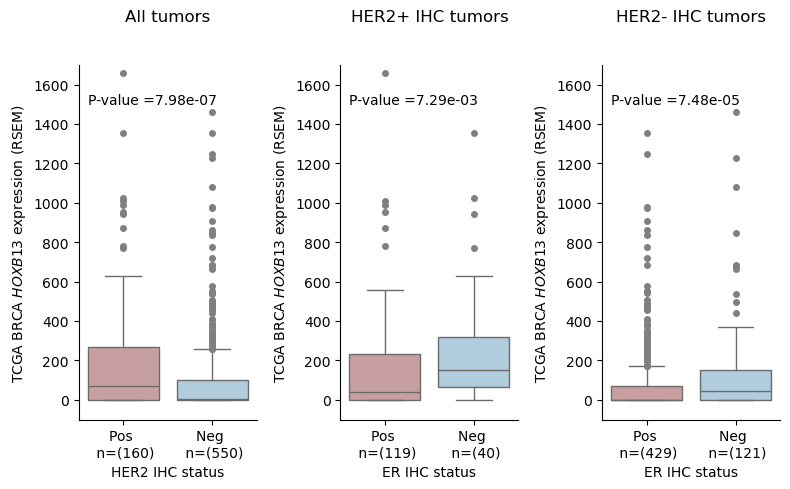

In [4]:
#Manuscript Figure 1A
#ER+/ER- HOXB13 expression box plot, 3rd panel with HER2+ participants ER+ vs ER-

#concatenating the dataframe for figure
#these are temporary dataframes to hold data for the seaborn code to generate the figure
#labelling HERR2 status
TCGA_BRCA_HERnegERpos_mRNA_data.loc["HER2 status"] = "Neg"
TCGA_BRCA_HERposERpos_mRNA_data.loc["HER2 status"] = "Pos"
TCGA_BRCA_HERnegERneg_mRNA_data.loc["HER2 status"] = "Neg"
TCGA_BRCA_HERposERneg_mRNA_data.loc["HER2 status"] = "Pos"

#making temporary dataframes
ERpos_df = pd.concat([TCGA_BRCA_HERposERpos_mRNA_data, TCGA_BRCA_HERnegERpos_mRNA_data], axis=1)
ERpos_df.loc["ER status"] = "Pos"
ERneg_df = pd.concat([TCGA_BRCA_HERposERneg_mRNA_data, TCGA_BRCA_HERnegERneg_mRNA_data], axis=1)
ERneg_df.loc["ER status"] = "Neg"
HER2posdf = pd.concat([ERpos_df, ERneg_df], axis=1)
HER2posdf = HER2posdf.loc[:, HER2posdf.loc["HER2 status"] == "Pos"]
HER2negdf = pd.concat([ERpos_df, ERneg_df], axis=1)
HER2negdf = HER2negdf.loc[:, HER2negdf.loc["HER2 status"] == "Neg"]
concat_HERmRNA_df_HER2pos = TCGA_BRCA_mRNA_tumor_data.loc[:, TCGA_BRCA_HERpos_participants]
concat_HERmRNA_df_HER2pos.loc["HER2 status"] = "Pos"
concat_HERmRNA_df_HER2neg = TCGA_BRCA_mRNA_tumor_data.loc[:, TCGA_BRCA_HERneg_participants]
concat_HERmRNA_df_HER2neg.loc["HER2 status"] = "Neg"

concat_HERmRNA_df = pd.concat([concat_HERmRNA_df_HER2pos, concat_HERmRNA_df_HER2neg], axis = 1)

#code to generate figure
plt.rcParams['axes.titley'] = 1.1
boxplot_palette = ["#CE989A", "#AACEE3"]
fig, ax = plt.subplots(1, 3, figsize=(8, 5))
fig.subplots_adjust(hspace=1, wspace=0.5)
sns.boxplot(palette = boxplot_palette, data = concat_HERmRNA_df, y= concat_HERmRNA_df.loc["HOXB13"], x= concat_HERmRNA_df.loc["HER2 status"], ax = ax[0], order = ["Pos", "Neg"], flierprops=flierprops)
ax[0].set_ylabel('TCGA BRCA $\it{HOXB13}$ expression (RSEM)')
ax[0].set_xlabel("HER2 IHC status")
ax[0].text(-0.4, 1500, '\nP-value ='  + str("{:.2e}".format(mannwhitneyu(list(concat_HERmRNA_df_HER2pos.loc['HOXB13']), list(concat_HERmRNA_df_HER2neg.loc['HOXB13']))[1])));
ax[0].set(ylim=(-100, 1700))
ax[0].set_title(label = "All tumors")
ax[0].set_xticklabels(['Pos \n n=(' + str(len(concat_HERmRNA_df_HER2pos.columns)) + ")", 'Neg \n n=(' + str(len(concat_HERmRNA_df_HER2neg.columns)) + ")"])

sns.boxplot(palette = boxplot_palette, x = 'ER status', y = 'HOXB13', data = HER2posdf.transpose(), ax=ax[1], order=["Pos", "Neg"], flierprops=flierprops)
ax[1].set_ylabel('TCGA BRCA $\it{HOXB13}$ expression (RSEM)')
ax[1].set_xlabel("ER IHC status")
ax[1].text(-0.4, 1500, '\nP-value ='  + str("{:.2e}".format(mannwhitneyu(list(TCGA_BRCA_HERposERneg_mRNA_data.loc['HOXB13']), list(TCGA_BRCA_HERposERpos_mRNA_data.loc['HOXB13']))[1])));
ax[1].set(ylim=(-100, 1700))
ax[1].set_title(label = "HER2+ IHC tumors")
ax[1].set_xticklabels(['Pos \n n=(' + str(len(TCGA_BRCA_HERposERpos_mRNA_data.columns)) + ")", 'Neg \n n=(' + str(len(TCGA_BRCA_HERposERneg_mRNA_data.columns)) + ")"])

sns.boxplot(palette = boxplot_palette, x = 'ER status', y = 'HOXB13', data = HER2negdf.transpose(), ax=ax[2], order=["Pos", "Neg"], flierprops=flierprops)
ax[2].set_ylabel('TCGA BRCA $\it{HOXB13}$ expression (RSEM)')
ax[2].set_xlabel("ER IHC status")
ax[2].text(-0.4, 1500, '\nP-value ='  + str("{:.2e}".format(mannwhitneyu(list(TCGA_BRCA_HERnegERneg_mRNA_data.loc['HOXB13']), list(TCGA_BRCA_HERnegERpos_mRNA_data.loc['HOXB13']))[1])));
ax[2].set(ylim=(-100, 1700))
ax[2].set_title(label = "HER2- IHC tumors")
ax[2].set_xticklabels(['Pos \n n=(' + str(len(TCGA_BRCA_HERnegERpos_mRNA_data.columns)) + ")", 'Neg \n n=(' + str(len(TCGA_BRCA_HERnegERneg_mRNA_data.columns)) + ")"])

plt.savefig('Figures/Figure1ABandC.pdf')


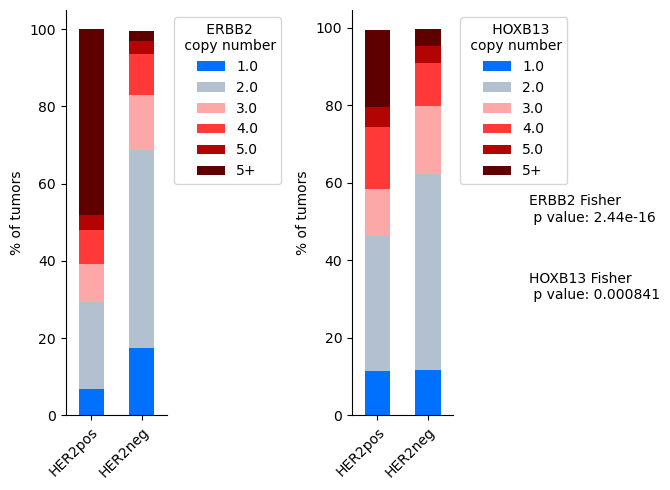

In [5]:
#Figure 2AB - breakdown of HER+ IHC TCGA tumors by copy number for HOXB13 and ERBB2
#making a temporary dataframe to label any patient with over 5 copies as 5+ for the figure

palette = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#0070FF","#B3C0D0", "#FCA8A8", "#FF3838", "#B40303", "#5E0000"])

figure2Atempdf_ERBB2 = TCGA_BRCA_callsonlyERBB2.copy()
for x in range(0, len(figure2Atempdf_ERBB2.index)):
    if (figure2Atempdf_ERBB2.loc[figure2Atempdf_ERBB2.index[x], "Copy number"] > 5):
        figure2Atempdf_ERBB2.loc[figure2Atempdf_ERBB2.index[x], "Copy number"] = "5+"

figure2Atempdf_HOXB13 = TCGA_BRCA_callsonlyHOXB13.copy()
for x in range(0, len(figure2Atempdf_HOXB13.index)):
    if (figure2Atempdf_HOXB13.loc[figure2Atempdf_HOXB13.index[x], "Copy number"] > 5):
        figure2Atempdf_HOXB13.loc[figure2Atempdf_HOXB13.index[x], "Copy number"] = "5+"
        
fig, ax = plt.subplots(1, 2, figsize=(7, 5))
plt.rcParams['pdf.fonttype'] = 42
figure2Atemp_HER2pos_ERBB2 = pd.DataFrame(figure2Atempdf_ERBB2.loc[figure2Atempdf_ERBB2.loc[:, "HER2 status"] == "Pos"].loc[:, "Copy number"].value_counts())
figure2Atemp_HER2pos_ERBB2.columns = ["HER2pos"]

#for statistics later
notpercent_figure2Atemp_HER2pos_ERBB2 = figure2Atemp_HER2pos_ERBB2.copy()

#making everything fractions
figure2Atemp_HER2pos_ERBB2["HER2pos"] = figure2Atemp_HER2pos_ERBB2["HER2pos"]/sum(figure2Atemp_HER2pos_ERBB2["HER2pos"])
figure2Atemp_HER2neg_ERBB2 = pd.DataFrame(figure2Atempdf_ERBB2.loc[figure2Atempdf_ERBB2.loc[:, "HER2 status"] == "Neg"].loc[:, "Copy number"].value_counts())
figure2Atemp_HER2neg_ERBB2.columns = ["HER2neg"]

#for statistics later
notpercent_figure2Atemp_HER2neg_ERBB2 = figure2Atemp_HER2neg_ERBB2.copy()

figure2Atemp_HER2neg_ERBB2["HER2neg"] = figure2Atemp_HER2neg_ERBB2["HER2neg"]/sum(figure2Atemp_HER2neg_ERBB2["HER2neg"])
final_figure2Atempdf_ERBB2 = pd.concat([figure2Atemp_HER2pos_ERBB2, figure2Atemp_HER2neg_ERBB2], axis = 1).transpose()

#removing the patients in the middle for the figure since they are so few it doesn't impact the graphics
final_figure2Atempdf_ERBB2 = final_figure2Atempdf_ERBB2[[1,2,3,4,5,"5+"]]
final_figure2Atempdf_ERBB2 = final_figure2Atempdf_ERBB2*100
final_figure2Atempdf_ERBB2.plot(kind='bar', stacked=True, ax = ax[0], colormap = palette)
ax[0].set_ylabel('% of tumors')
ax[0].tick_params(axis='x', labelrotation = 45)
ax[0].legend(bbox_to_anchor=(1.0, 1.0), title="      ERBB2 \n copy number")


figure2Atemp_HER2pos_HOXB13 = pd.DataFrame(figure2Atempdf_HOXB13.loc[figure2Atempdf_HOXB13.loc[:, "HER2 status"] == "Pos"].loc[:, "Copy number"].value_counts())
figure2Atemp_HER2pos_HOXB13.columns = ["HER2pos"]

#for statistics later
notpercent_figure2Atemp_HER2pos_HOXB13 = figure2Atemp_HER2pos_HOXB13.copy()

#making everything fractions
figure2Atemp_HER2pos_HOXB13["HER2pos"] = figure2Atemp_HER2pos_HOXB13["HER2pos"]/sum(figure2Atemp_HER2pos_HOXB13["HER2pos"])
figure2Atemp_HER2neg_HOXB13 = pd.DataFrame(figure2Atempdf_HOXB13.loc[figure2Atempdf_HOXB13.loc[:, "HER2 status"] == "Neg"].loc[:, "Copy number"].value_counts())
figure2Atemp_HER2neg_HOXB13.columns = ["HER2neg"]

#for statistics later
notpercent_figure2Atemp_HER2neg_HOXB13 = figure2Atemp_HER2neg_HOXB13.copy()

figure2Atemp_HER2neg_HOXB13["HER2neg"] = figure2Atemp_HER2neg_HOXB13["HER2neg"]/sum(figure2Atemp_HER2neg_HOXB13["HER2neg"])
final_figure2Atempdf_HOXB13 = pd.concat([figure2Atemp_HER2pos_HOXB13, figure2Atemp_HER2neg_HOXB13], axis = 1).transpose()

#removing the patients in the middle for the figure since they are so few it doesn't impact the graphics
final_figure2Atempdf_HOXB13 = final_figure2Atempdf_HOXB13[[1,2,3,4,5,"5+"]]
final_figure2Atempdf_HOXB13 = final_figure2Atempdf_HOXB13*100
final_figure2Atempdf_HOXB13.plot(kind='bar', stacked=True, ax = ax[1], colormap = palette)
ax[1].set_ylabel('% of tumors')
ax[1].tick_params(axis='x', labelrotation = 45)
ax[1].legend(bbox_to_anchor=(1.0, 1.0), title="      HOXB13 \n copy number")

#p values

#fisher tables
fig2A_ERBB2fisherdf = pd.DataFrame()
fig2A_ERBB2fisherdf.loc["not gained", "HER2+"] = 30+9
fig2A_ERBB2fisherdf.loc["gained", "HER2+"] = 64+13+12+5
fig2A_ERBB2fisherdf.loc["not gained", "HER2-"] = 273+93
fig2A_ERBB2fisherdf.loc["gained", "HER2-"] = 76+57+18+13+2+1
plt.text(3, 50, "ERBB2 Fisher \n p value: " + str("{:.3}".format(fisher_exact(fig2A_ERBB2fisherdf, alternative='two-sided')[1])))

fig2A_HOXB13fisherdf = pd.DataFrame()
fig2A_HOXB13fisherdf.loc["not gained", "HER2+"] = 54+18+1
fig2A_HOXB13fisherdf.loc["gained", "HER2+"] = 31+25+19+8
fig2A_HOXB13fisherdf.loc["not gained", "HER2-"] = 270+62
fig2A_HOXB13fisherdf.loc["gained", "HER2-"] = 94+60+23+23+1+1
plt.text(3, 30, "HOXB13 Fisher \n p value: " + str("{:.3}".format(fisher_exact(fig2A_HOXB13fisherdf, alternative='two-sided')[1])))

ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

plt.savefig('Figures/Figure2AB.pdf')

SignificanceResult(statistic=23.8602776533811, pvalue=2.0501908348886794e-94)

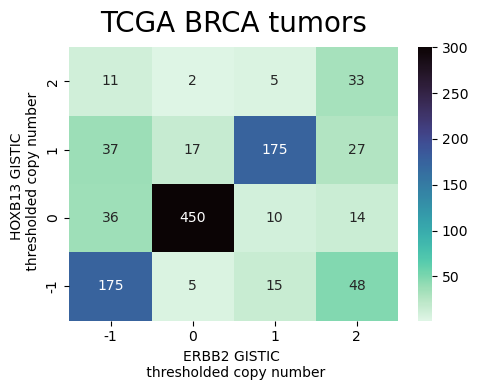

In [6]:
#Figure 2C
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
temp_df_erb0 = TCGA_BRCA_tumor_copynumber_data.loc[:, TCGA_BRCA_tumor_copynumber_data.loc['ERBB2'] == 0].columns
temp_df_erbneg1 = TCGA_BRCA_tumor_copynumber_data.loc[:, TCGA_BRCA_tumor_copynumber_data.loc['ERBB2'] == -1].columns
temp_df_erb1 = TCGA_BRCA_tumor_copynumber_data.loc[:, TCGA_BRCA_tumor_copynumber_data.loc['ERBB2'] == 1].columns
temp_df_erb2 = TCGA_BRCA_tumor_copynumber_data.loc[:, TCGA_BRCA_tumor_copynumber_data.loc['ERBB2'] == 2].columns

temp_fulldfheatmap = pd.DataFrame(data = TCGA_BRCA_tumor_copynumber_data.loc['HOXB13', temp_df_erb0].value_counts())
temp_fulldfheatmap.columns = ["ERBB2=0"]
temp_fulldfheatmap["ERBB2=1"] = TCGA_BRCA_tumor_copynumber_data.loc['HOXB13', temp_df_erb1].value_counts()
temp_fulldfheatmap["ERBB2=-1"] = TCGA_BRCA_tumor_copynumber_data.loc['HOXB13', temp_df_erbneg1].value_counts()
temp_fulldfheatmap["ERBB2=2"] = TCGA_BRCA_tumor_copynumber_data.loc['HOXB13', temp_df_erb2].value_counts()
temp_fulldfheatmap.index = ["HOXB13=0", "HOXB13=1", "HOXB13=-1", "HOXB13=2"]
temp_fulldfheatmap = temp_fulldfheatmap.loc[["HOXB13=2", "HOXB13=1", "HOXB13=0", "HOXB13=-1"]]
temp_fulldfheatmap = temp_fulldfheatmap[["ERBB2=-1", "ERBB2=0", "ERBB2=1", "ERBB2=2"]]

#changing the labels for the heatmap plot
TCGA_fulldfheatmap_zerolabels = temp_fulldfheatmap.copy()
TCGA_fulldfheatmap_zerolabels.index = [2, 1, 0, -1]
TCGA_fulldfheatmap_zerolabels.columns = [-1, 0, 1, 2]
sns.heatmap(data = TCGA_fulldfheatmap_zerolabels, annot = True, cmap='mako_r', fmt=".0f", ax = ax, vmax = 300)
ax.set_title("TCGA BRCA tumors", y = 1.025, size = 20)
ax.set_ylabel('HOXB13 GISTIC \n thresholded copy number')
ax.set_xlabel('ERBB2 GISTIC \n thresholded copy number')

plt.savefig('Figures/Figure2C.pdf')

#for the manuscript
statistics_df1 = pd.DataFrame()
statistics_df1.loc["HOXB13 not gained", "ERBB2 not gained"] = 36+450+175+5
statistics_df1.loc["HOXB13 gained", "ERBB2 not gained"] = 37+17+11+12
statistics_df1.loc["HOXB13 not gained", "ERBB2 gained"] = 15+10+14+48
statistics_df1.loc["HOXB13 gained", "ERBB2 gained"] = 175+27+5+33
fisher_exact(statistics_df1, alternative='two-sided')


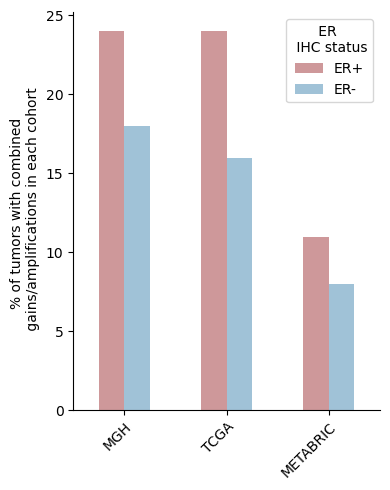

In [7]:
#Figure 2G - barplot displaying % breakdown for ER+/ER- as seen in the text
#For the MGH, TCGA, and METABRIC cohorts
#numbers are also found in the manuscript text

fig, ax = plt.subplots(1, 1, figsize=(4, 5))
Figure2G_df = pd.DataFrame(index = ["MGH", "TCGA", "METABRIC"])
figure2G_palette = ["#CE989A", "#A0C2D7"]
Figure2G_df["ER+"] = [24, 24, 11]
Figure2G_df["ER-"] = [18, 16, 8]

Figure2G_df.plot(kind='bar', color = figure2G_palette, ax = ax)
plt.xticks(rotation = 45)
ax.set_ylabel('% of tumors with combined \n gains/amplifications in each cohort')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
ax.legend(bbox_to_anchor=(1.0, 1.0), title="      ER \n IHC status")

plt.savefig('Figures/Figure2G.pdf')

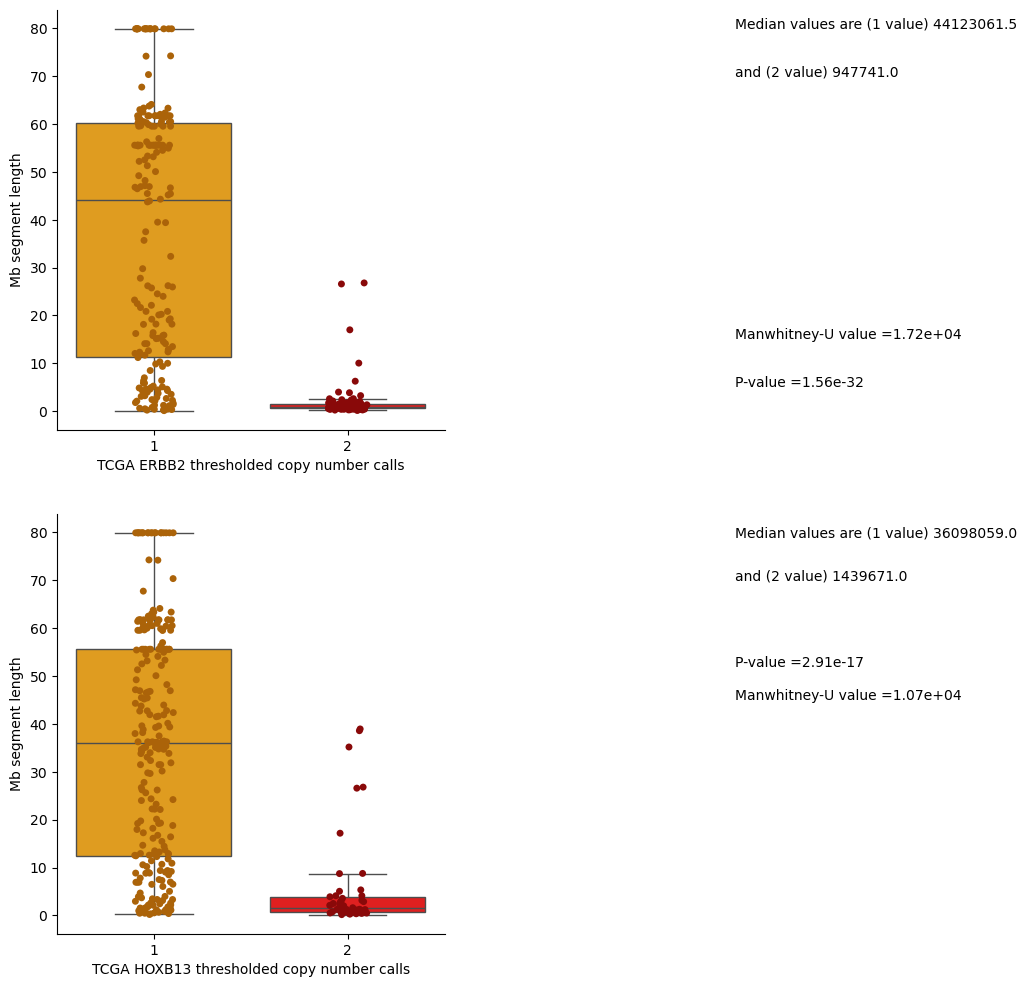

In [8]:
#Figure 3A - figure plotting the length distributions (box or violin) with GISTIC calls
#of the segments overlapping HER2 (from the seg file – pull out the length of any segment that touches HER2), 
#for gains (1-2 extra copies) and then for amplifications (3+ extra copies)
#using mb since segments are very large
fig, ax = plt.subplots(2, 1, figsize=(5, 12))
TCGA_BRCA_callsonlyERBB2.loc[:, "Mb segment length"] = (TCGA_BRCA_callsonlyERBB2.loc[:, "Segment_length"])/1000000


#adding back in thresholded data to calculate the p value
TCGA_BRCA_callsonlyERBB2["Thresholded calls"] = TCGA_BRCA_tumor_copynumber_data.loc["ERBB2"]
figure3ATCGA_CN1_tempdf = TCGA_BRCA_callsonlyERBB2.loc[TCGA_BRCA_callsonlyERBB2["Thresholded calls"] == 1]
figure3ATCGA_CN2_tempdf = TCGA_BRCA_callsonlyERBB2.loc[TCGA_BRCA_callsonlyERBB2["Thresholded calls"] == 2]
figure3ATCGA_CN1and2_tempdf = pd.concat([figure3ATCGA_CN2_tempdf, figure3ATCGA_CN1_tempdf], axis = 0)

sns.boxplot(y = figure3ATCGA_CN1and2_tempdf.loc[:, "Mb segment length"], ax = ax[0], x = figure3ATCGA_CN1and2_tempdf.loc[:, "Thresholded calls"], palette = sns.color_palette(["orange", "red"]), showfliers=False)
sns.stripplot(y = figure3ATCGA_CN1and2_tempdf.loc[:, "Mb segment length"], ax = ax[0], x = figure3ATCGA_CN1and2_tempdf.loc[:, "Thresholded calls"], palette = ["#AB6309", "#890909"])

ax[0].set_ylabel("Mb segment length")
ax[0].text(3, 5.0, '\nP-value ='  + str("{:.2e}".format(mannwhitneyu(figure3ATCGA_CN1_tempdf.loc[:, "Segment_length"], figure3ATCGA_CN2_tempdf.loc[:, "Segment_length"])[1])));
ax[0].text(3, 15.1, '\nManwhitney-U value ='  + str("{:.2e}".format(mannwhitneyu(figure3ATCGA_CN1_tempdf["Segment_length"], figure3ATCGA_CN2_tempdf["Segment_length"])[0])));
ax[0].text(3, 80, 'Median values are (1 value) ' + str(np.median(figure3ATCGA_CN1_tempdf.loc[:, "Segment_length"])))
ax[0].text(3, 70, 'and (2 value) ' + str(np.median(figure3ATCGA_CN2_tempdf.loc[:, "Segment_length"])))
ax[0].set_xlabel('TCGA ERBB2 thresholded copy number calls')

TCGA_BRCA_callsonlyHOXB13.loc[:, "Mb segment length"] = (TCGA_BRCA_callsonlyHOXB13.loc[:, "Segment_length"])/1000000


#adding back in thresholded data to calculate the p value
TCGA_BRCA_callsonlyHOXB13["Thresholded calls"] = TCGA_BRCA_tumor_copynumber_data.loc["HOXB13"]
figure3ATCGA_CN1_tempdf = TCGA_BRCA_callsonlyHOXB13.loc[TCGA_BRCA_callsonlyHOXB13["Thresholded calls"] == 1]
figure3ATCGA_CN2_tempdf = TCGA_BRCA_callsonlyHOXB13.loc[TCGA_BRCA_callsonlyHOXB13["Thresholded calls"] == 2]
figure3ATCGA_CN1and2_tempdf = pd.concat([figure3ATCGA_CN2_tempdf, figure3ATCGA_CN1_tempdf], axis = 0)

sns.boxplot(y = figure3ATCGA_CN1and2_tempdf.loc[:, "Mb segment length"], ax = ax[1], x = figure3ATCGA_CN1and2_tempdf.loc[:, "Thresholded calls"], palette = sns.color_palette(["orange", "red"]), showfliers=False)
sns.stripplot(y = figure3ATCGA_CN1and2_tempdf.loc[:, "Mb segment length"], ax = ax[1], x = figure3ATCGA_CN1and2_tempdf.loc[:, "Thresholded calls"], palette = ["#AB6309", "#890909"])

ax[1].set_ylabel("Mb segment length")
ax[1].text(3, 52, '\nP-value ='  + str("{:.2e}".format(mannwhitneyu(figure3ATCGA_CN1_tempdf.loc[:, "Segment_length"], figure3ATCGA_CN2_tempdf.loc[:, "Segment_length"])[1])));
ax[1].text(3, 45, '\nManwhitney-U value ='  + str("{:.2e}".format(mannwhitneyu(figure3ATCGA_CN1_tempdf["Segment_length"], figure3ATCGA_CN2_tempdf["Segment_length"])[0])));
ax[1].text(3, 79, 'Median values are (1 value) ' + str(np.median(figure3ATCGA_CN1_tempdf.loc[:, "Segment_length"])))
ax[1].text(3, 70, 'and (2 value) ' + str(np.median(figure3ATCGA_CN2_tempdf.loc[:, "Segment_length"])))
ax[1].set_xlabel('TCGA HOXB13 thresholded copy number calls')


plt.savefig('Figures/Figure3A.pdf')

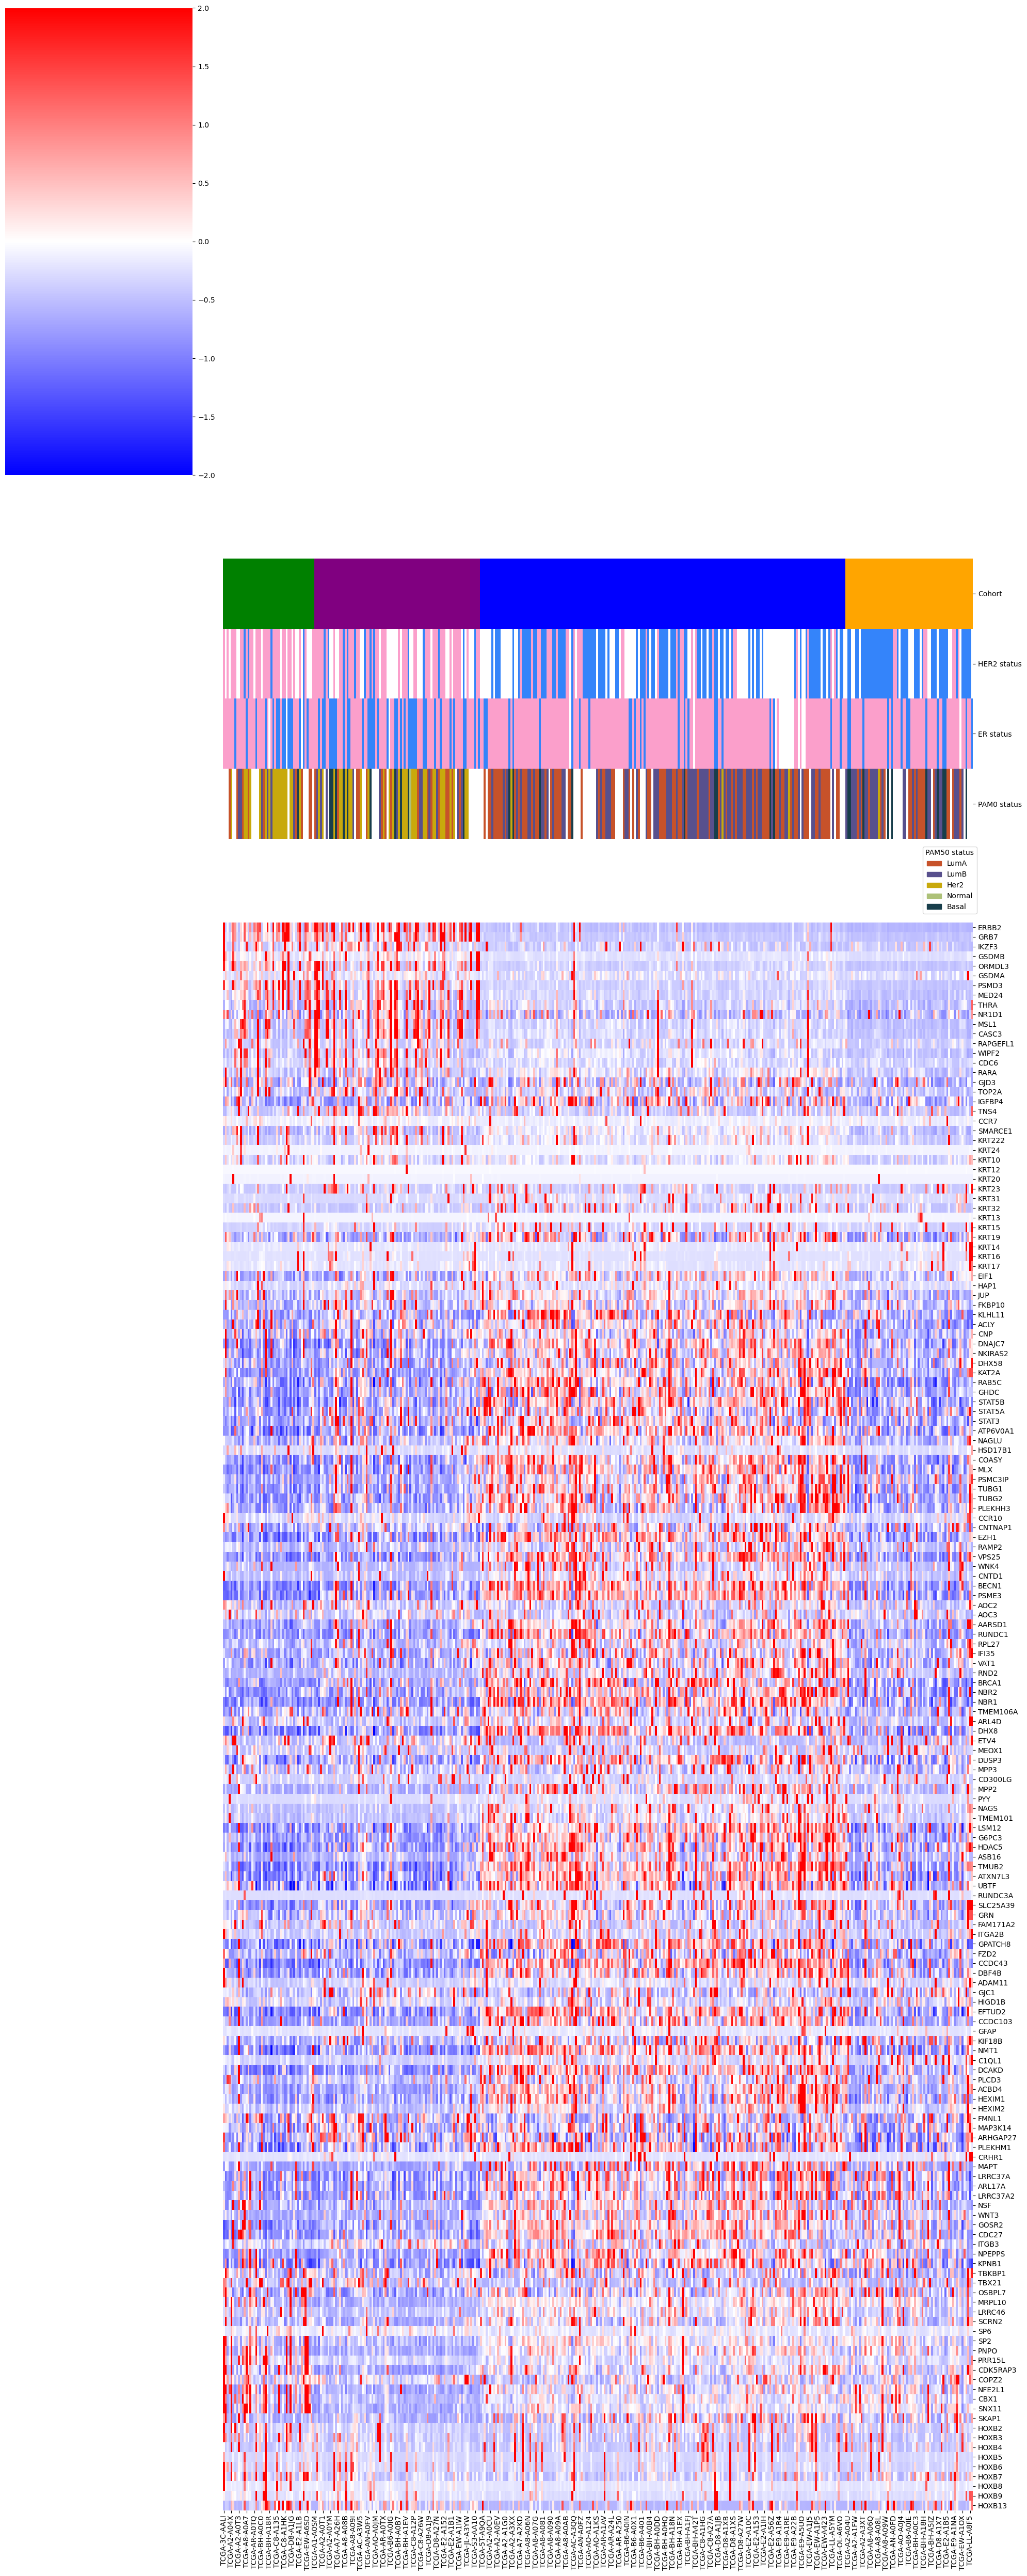

In [9]:
#Figure 3H
#Written by Dr. Esther Rheinbay and Rin
# gene expression from pancan atlas (https://gdc.cancer.gov/about-data/publications/pancanatlas)

TCGA_sample_info = pd.read_excel('Raw_data/TCGA-CDR-SupplementalTableS1.xlsx', sheet_name=0,  header=0, index_col=1)
TCGA_survival = pd.read_excel('Raw_data/TCGA-CDR-SupplementalTableS1.xlsx', sheet_name="ExtraEndpoints", index_col=1)

# TCGA pancan expression data
# gene expression from pancan atlas (https://gdc.cancer.gov/about-data/publications/pancanatlas)
TCGA_pancan_exp = pd.read_csv('Raw_data/EBPlusPlusAdjustPANCAN_IlluminaHiSeq_RNASeqV2.geneExp.tsv', sep='\t', header=0, index_col=0)

# sample codes from code table https://gdc.cancer.gov/resources-tcga-users/tcga-code-tables/sample-type-codes
tumor_codes = ['01', '02', '03', '04', '04', '06', '07', '08', '09']
normal_codes = ['10', '11', '12', '13', '14']


# divide samples into tumors and normals (-01*- are tumor samples; -06A- is a metastatic sample); most normals have code -11A-
stype = ['tumor' if x.split('-')[3][0:2] in tumor_codes else 'normal' if x.split('-')[3][0:2] in normal_codes else 'NA' for x in TCGA_pancan_exp.columns.values]
sample_type = pd.Series(stype, index = TCGA_pancan_exp.columns.values)

#change index to gene names only
TCGA_pancan_exp.index = map(lambda x: x.split('|')[0], TCGA_pancan_exp.index.values)

# extract tumors only
tumor_exp = TCGA_pancan_exp[sample_type[sample_type=='tumor'].index.values]

# extract normal samples only
normal_exp = TCGA_pancan_exp[sample_type[sample_type=='normal'].index.values]

# shorten column names/patient IDs
tumor_exp.rename(columns = lambda x: x[0:12], inplace=True)
normal_exp.rename(columns = lambda x: x[0:12], inplace=True)

# remove duplicate gene expression data for the same sample
tumor_exp_unique = tumor_exp.iloc[:, ~tumor_exp.columns.duplicated()]
normal_exp_unique = normal_exp.iloc[:, ~normal_exp.columns.duplicated()]

BRCA_exp = tumor_exp_unique[[x for x in TCGA_sample_info.index if TCGA_sample_info.loc[x].type=='BRCA' and x in tumor_exp_unique.columns]]
gap_genes = list(pd.DataFrame(pd.read_csv('ucsc_table_all_gap_genes.bed', sep='\t', header=0)['hg19.kgXref.geneSymbol']).drop_duplicates(subset = "hg19.kgXref.geneSymbol")["hg19.kgXref.geneSymbol"])

# heatmap of gap genes in different sets
# Figure 3H
genes_to_plot = ["ERBB2"]
for x in gap_genes:
    if (x in BRCA_exp.index):
        genes_to_plot.append(x)

genes_to_plot.append("HOXB13")

clustermap_df_gap = BRCA_exp.loc[genes_to_plot, TCGA_BRCA_gap_participants]
clustermap_df_erbb2only = BRCA_exp.loc[genes_to_plot, TCGA_BRCA_ERBB2only_participants]
clustermap_df_cogain = BRCA_exp.loc[genes_to_plot, TCGA_BRCA_co_gained_participants]
clustermap_df_HOXB13only = BRCA_exp.loc[genes_to_plot, TCGA_BRCA_HOXB13only_participants]
clustermap_df = pd.concat([clustermap_df_gap, clustermap_df_erbb2only, clustermap_df_cogain, clustermap_df_HOXB13only], axis = 1)

#resorting index hy genomic order
clustermap_df = clustermap_df.loc[genes_to_plot]

#dropping rows with less than 10 average FPKMs
clustermap_df["Average"] = (clustermap_df.sum(axis = 1))/len(clustermap_df.columns)
clustermap_df = clustermap_df.loc[clustermap_df["Average"] > 10]
clustermap_df.drop(["Average"], axis = 1, inplace = True)

cohort_colors = []
for x in clustermap_df.columns:
    if x in TCGA_BRCA_gap_participants:
        cohort_colors.append("green")
    if x in TCGA_BRCA_ERBB2only_participants:
        cohort_colors.append("purple")
    if x in TCGA_BRCA_co_gained_participants:
        cohort_colors.append("blue")
    if x in TCGA_BRCA_HOXB13only_participants:
        cohort_colors.append("orange")

er_colors = []
for x in clustermap_df.columns:
    if x in TCGA_BRCA_ERpos_participants:
        er_colors.append("#fb9fcb")
    else:
        if x in TCGA_BRCA_ERneg_participants:
            er_colors.append("#3484fa")
        else:
            er_colors.append("#ffffff")

her_colors = []
for x in clustermap_df.columns:
    if x in TCGA_BRCA_HERpos_participants:
        her_colors.append("#fb9fcb")
    else:
        if x in TCGA_BRCA_HERneg_participants:
            her_colors.append("#3484fa")
        else:
            her_colors.append("#ffffff")

pam50_colors = []
for x in clustermap_df.columns:
    if x in PAM50_scores.index:
        if (PAM50_scores.loc[x, "PAM50"] == "LumA"):
            pam50_colors.append("#c7522a")
        if (PAM50_scores.loc[x, "PAM50"] == "LumB"):
            pam50_colors.append("#58508d")
        if (PAM50_scores.loc[x, "PAM50"] == "Her2"):
            pam50_colors.append("#c8a90c")
        if (PAM50_scores.loc[x, "PAM50"] == "Normal"):
            pam50_colors.append("#adc178")
        if (PAM50_scores.loc[x, "PAM50"] == "Basal"):
            pam50_colors.append("#183e4b")
    else:
        pam50_colors.append("#ffffff")
        
clustermap_color_df = pd.DataFrame({"Cohort": cohort_colors, "HER2 status": her_colors, "ER status": er_colors, "PAM0 status": pam50_colors}, index=clustermap_df.columns)

g = sns.clustermap(clustermap_df, cmap = 'bwr', col_cluster=False, row_cluster=False, z_score=2, vmax=2, vmin = -2, center=0, col_colors=clustermap_color_df, figsize = (20,50))

#adding in legend using temporary dataframes
#HER2 status
#PAM50 status
PAM50_legend_df = pd.DataFrame(columns = ["PAM50 status", "Color"])
PAM50_legend_df["PAM50 status"] = ["LumA", "LumB", "Her2", "Normal", "Basal"]
PAM50_legend_df["color"] = ["#c7522a", "#58508d", "#c8a90c", "#adc178", "#183e4b"]
legend_PAM50 = [mpatches.Patch(color=c, label=l) for c,l in PAM50_legend_df[['color','PAM50 status']].drop_duplicates().values]
l1=g.ax_heatmap.legend(bbox_to_anchor=(1.01,1.05),handles=legend_PAM50,frameon=True)
l1.set_title(title='PAM50 status',prop={'size':10})

plt.savefig('Figures/Figure3H.pdf')

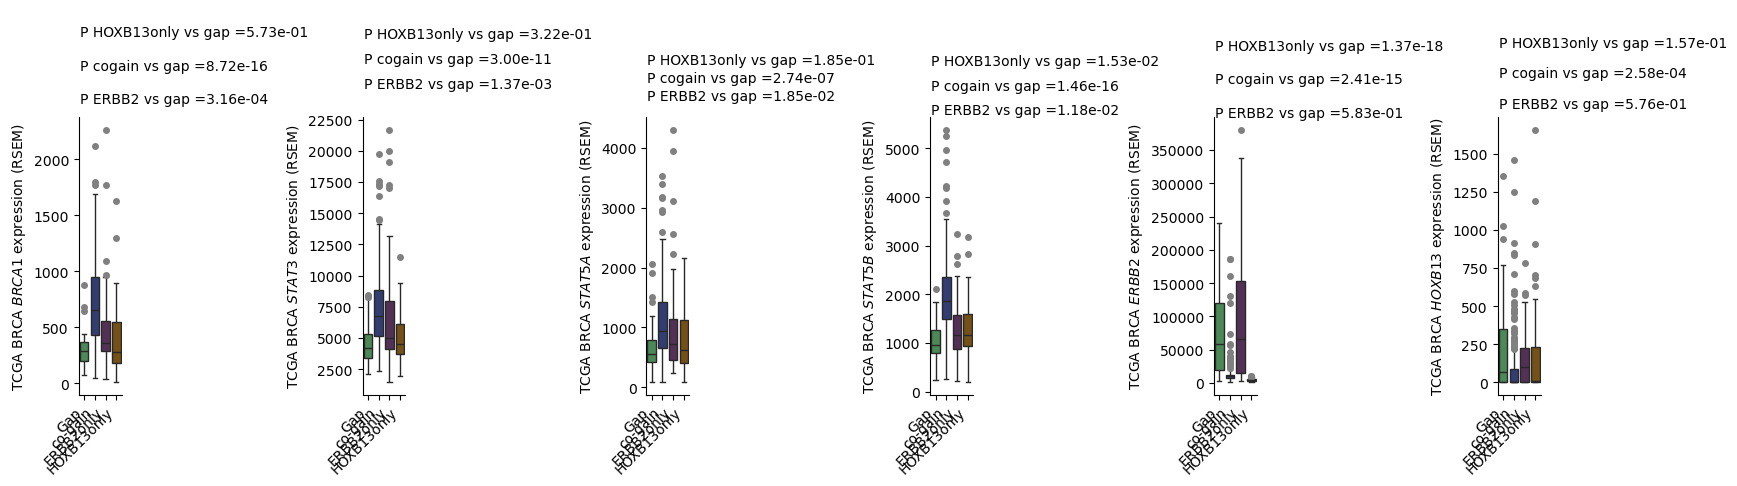

In [10]:
fig, ax = plt.subplots(1, 6, figsize=(17, 5))
gene_palette = ["#419450", "#28387C", "#592A5C", "#855507"]

Figure_3I_tempdf = TCGA_BRCA_mRNA_tumor_data.copy()
Figure_3I_tempdf.loc["Status", TCGA_BRCA_ERBB2only_participants] = "ERBB2only"
Figure_3I_tempdf.loc["Status", TCGA_BRCA_gap_participants] = "Gap"
Figure_3I_tempdf.loc["Status", TCGA_BRCA_co_gained_participants] = "co-gain"
Figure_3I_tempdf.loc["Status", TCGA_BRCA_HOXB13only_participants] = "HOXB13only"

sns.boxplot(y = Figure_3I_tempdf.loc["BRCA1"], x = Figure_3I_tempdf.loc["Status"], ax = ax[0], palette = gene_palette, flierprops=flierprops)
ax[0].set_ylabel('TCGA BRCA $\it{BRCA1}$ expression (RSEM)')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, ha="right")
ax[0].text(-0.4, 3100, '\nP HOXB13only vs gap ='  + str("{:.2e}".format(mannwhitneyu(TCGA_BRCA_mRNA_tumor_data.loc["BRCA1", TCGA_BRCA_gap_participants].dropna(), TCGA_BRCA_mRNA_tumor_data.loc["BRCA1", TCGA_BRCA_HOXB13only_participants].dropna())[1])));
ax[0].text(-0.4, 2800, '\nP cogain vs gap ='  + str("{:.2e}".format(mannwhitneyu(TCGA_BRCA_mRNA_tumor_data.loc["BRCA1", TCGA_BRCA_gap_participants].dropna(), TCGA_BRCA_mRNA_tumor_data.loc["BRCA1", TCGA_BRCA_co_gained_participants].dropna())[1])));
ax[0].text(-0.4, 2500, '\nP ERBB2 vs gap ='  + str("{:.2e}".format(mannwhitneyu(TCGA_BRCA_mRNA_tumor_data.loc["BRCA1", TCGA_BRCA_gap_participants].dropna(), TCGA_BRCA_mRNA_tumor_data.loc["BRCA1", TCGA_BRCA_ERBB2only_participants].dropna())[1])));
ax[0].set_xlabel("")

sns.boxplot(y = Figure_3I_tempdf.loc["STAT3"], x = Figure_3I_tempdf.loc["Status"], ax = ax[1], palette = gene_palette, flierprops=flierprops)
ax[1].set_ylabel('TCGA BRCA $\it{STAT3}$ expression (RSEM)')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, ha="right")
ax[1].text(-0.4, 29000, '\nP HOXB13only vs gap ='  + str("{:.2e}".format(mannwhitneyu(TCGA_BRCA_mRNA_tumor_data.loc["STAT3", TCGA_BRCA_gap_participants].dropna(), TCGA_BRCA_mRNA_tumor_data.loc["STAT3", TCGA_BRCA_HOXB13only_participants].dropna())[1])));
ax[1].text(-0.4, 27000, '\nP cogain vs gap ='  + str("{:.2e}".format(mannwhitneyu(TCGA_BRCA_mRNA_tumor_data.loc["STAT3", TCGA_BRCA_gap_participants].dropna(), TCGA_BRCA_mRNA_tumor_data.loc["STAT3", TCGA_BRCA_co_gained_participants].dropna())[1])));
ax[1].text(-0.4, 25000, '\nP ERBB2 vs gap ='  + str("{:.2e}".format(mannwhitneyu(TCGA_BRCA_mRNA_tumor_data.loc["STAT3", TCGA_BRCA_gap_participants].dropna(), TCGA_BRCA_mRNA_tumor_data.loc["STAT3", TCGA_BRCA_ERBB2only_participants].dropna())[1])));
ax[1].set_xlabel("")

sns.boxplot(y = Figure_3I_tempdf.loc["STAT5A"], x = Figure_3I_tempdf.loc["Status"], ax = ax[2], palette = gene_palette, flierprops=flierprops)
ax[2].set_ylabel('TCGA BRCA $\it{STAT5A}$ expression (RSEM)')
ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=45, ha="right")
ax[2].text(-0.4, 5400, '\nP HOXB13only vs gap ='  + str("{:.2e}".format(mannwhitneyu(TCGA_BRCA_mRNA_tumor_data.loc["STAT5A", TCGA_BRCA_gap_participants].dropna(), TCGA_BRCA_mRNA_tumor_data.loc["STAT5A", TCGA_BRCA_HOXB13only_participants].dropna())[1])));
ax[2].text(-0.4, 5100, '\nP cogain vs gap ='  + str("{:.2e}".format(mannwhitneyu(TCGA_BRCA_mRNA_tumor_data.loc["STAT5A", TCGA_BRCA_gap_participants].dropna(), TCGA_BRCA_mRNA_tumor_data.loc["STAT5A", TCGA_BRCA_co_gained_participants].dropna())[1])));
ax[2].text(-0.4, 4800, '\nP ERBB2 vs gap ='  + str("{:.2e}".format(mannwhitneyu(TCGA_BRCA_mRNA_tumor_data.loc["STAT5A", TCGA_BRCA_gap_participants].dropna(), TCGA_BRCA_mRNA_tumor_data.loc["STAT5A", TCGA_BRCA_ERBB2only_participants].dropna())[1])));
ax[2].set_xlabel("")

sns.boxplot(y = Figure_3I_tempdf.loc["STAT5B"], x = Figure_3I_tempdf.loc["Status"], ax = ax[3], palette = gene_palette, flierprops=flierprops)
ax[3].set_ylabel('TCGA BRCA $\it{STAT5B}$ expression (RSEM)')
ax[3].set_xticklabels(ax[3].get_xticklabels(), rotation=45, ha="right")
ax[3].text(-0.4, 6700, '\nP HOXB13only vs gap ='  + str("{:.2e}".format(mannwhitneyu(TCGA_BRCA_mRNA_tumor_data.loc["STAT5B", TCGA_BRCA_gap_participants].dropna(), TCGA_BRCA_mRNA_tumor_data.loc["STAT5B", TCGA_BRCA_HOXB13only_participants].dropna())[1])));
ax[3].text(-0.4, 6200, '\nP cogain vs gap ='  + str("{:.2e}".format(mannwhitneyu(TCGA_BRCA_mRNA_tumor_data.loc["STAT5B", TCGA_BRCA_gap_participants].dropna(), TCGA_BRCA_mRNA_tumor_data.loc["STAT5B", TCGA_BRCA_co_gained_participants].dropna())[1])));
ax[3].text(-0.4, 5700, '\nP ERBB2 vs gap ='  + str("{:.2e}".format(mannwhitneyu(TCGA_BRCA_mRNA_tumor_data.loc["STAT5B", TCGA_BRCA_gap_participants].dropna(), TCGA_BRCA_mRNA_tumor_data.loc["STAT5B", TCGA_BRCA_ERBB2only_participants].dropna())[1])));
ax[3].set_xlabel("")

sns.boxplot(y = Figure_3I_tempdf.loc["ERBB2"], x = Figure_3I_tempdf.loc["Status"], ax = ax[4], palette = gene_palette, flierprops=flierprops)
ax[4].set_ylabel('TCGA BRCA $\it{ERBB2}$ expression (RSEM)')
ax[4].set_xticklabels(ax[4].get_xticklabels(), rotation=45, ha="right")
ax[4].text(-0.4, 500000, '\nP HOXB13only vs gap ='  + str("{:.2e}".format(mannwhitneyu(TCGA_BRCA_mRNA_tumor_data.loc["ERBB2", TCGA_BRCA_gap_participants].dropna(), TCGA_BRCA_mRNA_tumor_data.loc["ERBB2", TCGA_BRCA_HOXB13only_participants].dropna())[1])));
ax[4].text(-0.4, 450000, '\nP cogain vs gap ='  + str("{:.2e}".format(mannwhitneyu(TCGA_BRCA_mRNA_tumor_data.loc["ERBB2", TCGA_BRCA_gap_participants].dropna(), TCGA_BRCA_mRNA_tumor_data.loc["ERBB2", TCGA_BRCA_co_gained_participants].dropna())[1])));
ax[4].text(-0.4, 400000, '\nP ERBB2 vs gap ='  + str("{:.2e}".format(mannwhitneyu(TCGA_BRCA_mRNA_tumor_data.loc["ERBB2", TCGA_BRCA_gap_participants].dropna(), TCGA_BRCA_mRNA_tumor_data.loc["ERBB2", TCGA_BRCA_ERBB2only_participants].dropna())[1])));
ax[4].set_xlabel("")

sns.boxplot(y = Figure_3I_tempdf.loc["HOXB13"], x = Figure_3I_tempdf.loc["Status"], ax = ax[5], palette = gene_palette, flierprops=flierprops)
ax[5].set_ylabel('TCGA BRCA $\it{HOXB13}$ expression (RSEM)')
ax[5].set_xticklabels(ax[5].get_xticklabels(), rotation=45, ha="right")
ax[5].text(-0.4, 2200, '\nP HOXB13only vs gap ='  + str("{:.2e}".format(mannwhitneyu(TCGA_BRCA_mRNA_tumor_data.loc["HOXB13", TCGA_BRCA_gap_participants].dropna(), TCGA_BRCA_mRNA_tumor_data.loc["HOXB13", TCGA_BRCA_HOXB13only_participants].dropna())[1])));
ax[5].text(-0.4, 2000, '\nP cogain vs gap ='  + str("{:.2e}".format(mannwhitneyu(TCGA_BRCA_mRNA_tumor_data.loc["HOXB13", TCGA_BRCA_gap_participants].dropna(), TCGA_BRCA_mRNA_tumor_data.loc["HOXB13", TCGA_BRCA_co_gained_participants].dropna())[1])));
ax[5].text(-0.4, 1800, '\nP ERBB2 vs gap ='  + str("{:.2e}".format(mannwhitneyu(TCGA_BRCA_mRNA_tumor_data.loc["HOXB13", TCGA_BRCA_gap_participants].dropna(), TCGA_BRCA_mRNA_tumor_data.loc["HOXB13", TCGA_BRCA_ERBB2only_participants].dropna())[1])));
ax[5].set_xlabel("")


plt.savefig('Figures/Figure3I.pdf')

BRCA    329
LUAD    225
KIRP    186
BLCA    166
LUSC    164
STAD    145
COAD    109
LIHC     94
HNSC     91
ESCA     74
UCEC     70
GBM      55
CESC     55
OV       54
TGCT     47
READ     41
SARC     37
PAAD     31
KIRC     30
UCS      27
LGG      22
THCA     21
MESO     13
PRAD     12
THYM      9
CHOL      8
ACC       7
UVM       7
PCPG      5
DLBC      5
Name: type, dtype: int64


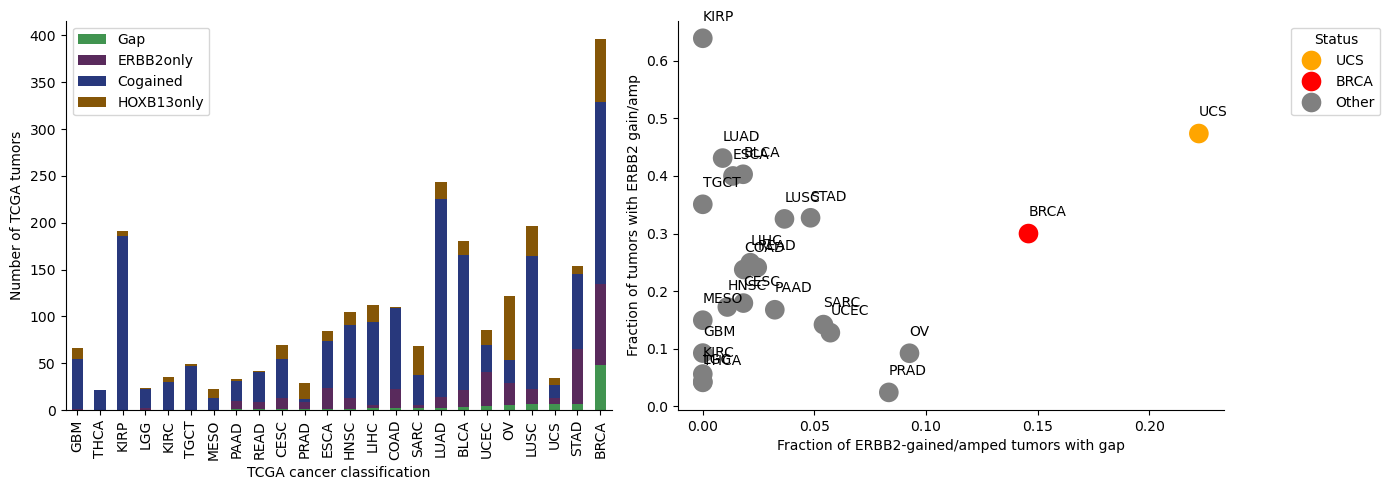

In [11]:
#looking at pancan and identifying our three cohorts
pancanTCGA_HER_gained_participants = pancancer_tumor_copynumber_data.loc[:, pancancer_tumor_copynumber_data.loc['ERBB2'] > 0].columns
pancanTCGA_HOX_gained_participants = pancancer_tumor_copynumber_data.loc[:, pancancer_tumor_copynumber_data.loc['HOXB13'] > 0].columns
pancanTCGA_HER_nongained_participants = pancancer_tumor_copynumber_data.loc[:, pancancer_tumor_copynumber_data.loc['ERBB2'] < 1].columns
pancanTCGA_HOX_nongained_participants = pancancer_tumor_copynumber_data.loc[:, pancancer_tumor_copynumber_data.loc['HOXB13'] < 1].columns
pancanTCGA_HOX_amped_participants = pancancer_tumor_copynumber_data.loc[:, pancancer_tumor_copynumber_data.loc['HOXB13'] > 1].columns


pancanTCGA_gap_participants = pancancer_tumor_copynumber_data.loc[:, pancancer_tumor_copynumber_data.loc['ERBB2'] > 0].columns & pancancer_tumor_copynumber_data.loc[:, pancancer_tumor_copynumber_data.loc['HOXB13'] > 0].columns & pancancer_tumor_copynumber_data.loc[:, pancancer_tumor_copynumber_data.loc['BRCA1'] < 0].columns
pancanTCGA_ERBB2only_participants = pancanTCGA_HER_gained_participants.intersection(pancanTCGA_HOX_nongained_participants)
pancanTCGA_co_gained_participants = (pancancer_tumor_copynumber_data.loc[:, pancancer_tumor_copynumber_data.loc['HOXB13'] > 0].columns) & (pancancer_tumor_copynumber_data.loc[:, pancancer_tumor_copynumber_data.loc['ERBB2'] > 0].columns) & (pancancer_tumor_copynumber_data.loc[:, pancancer_tumor_copynumber_data.loc['BRCA1'] > -1].columns)
pancanTCGA_HOXB13only_participants = pancanTCGA_HOX_gained_participants.intersection(pancanTCGA_HER_nongained_participants)

#finding tumor types with at least 10 cases of ERBB2 amplification
print(pancancer_clinical_and_survival_data.loc[np.in1d(pancancer_clinical_and_survival_data.index, pancanTCGA_HER_gained_participants)]["type"].value_counts())

included_tumortypes = pd.DataFrame(pancancer_clinical_and_survival_data.loc[np.in1d(pancancer_clinical_and_survival_data.index, pancanTCGA_HER_gained_participants)]["type"].value_counts())
included_tumortypes = included_tumortypes.loc[included_tumortypes["type"] > 10]

#making barplot dataframe
pancan_cohort_categorization_df = pd.DataFrame(index = list(included_tumortypes.index))
pancan_gap_list = []
pancan_erbb2only_list = []
pancan_cogained_list = []
pancan_hoxb13only_list = []
pancan_number_of_tumors = []
pancan_number_of_ERBB2gaintumors = []

pancan_normalized_gap_list = []
pancan_normalized_erbb2gain_list = []

for x in pancan_cohort_categorization_df.index:
    current_cancer_type_tumors = pancancer_clinical_and_survival_data.loc[pancancer_clinical_and_survival_data["type"] == x].index
    pancan_gap_list.append(len(set(current_cancer_type_tumors) & set(pancanTCGA_gap_participants)))
    pancan_erbb2only_list.append(len(set(current_cancer_type_tumors) & set(pancanTCGA_ERBB2only_participants)))
    pancan_cogained_list.append(len(set(current_cancer_type_tumors) & set(pancanTCGA_co_gained_participants)))
    pancan_hoxb13only_list.append(len(set(current_cancer_type_tumors) & set(pancanTCGA_HOXB13only_participants)))
    pancan_number_of_tumors.append(len(current_cancer_type_tumors))

    pancan_number_of_ERBB2gaintumors.append(len(pancanTCGA_HER_gained_participants & current_cancer_type_tumors))
    current_cancer_numberofERBB2gain_total_pts = len(pancanTCGA_HER_gained_participants & current_cancer_type_tumors)

    pancan_normalized_gap_list.append(len(set(current_cancer_type_tumors) & set(pancanTCGA_gap_participants))/current_cancer_numberofERBB2gain_total_pts)
    pancan_normalized_erbb2gain_list.append(current_cancer_numberofERBB2gain_total_pts/len(current_cancer_type_tumors))

waterfall_palette = ["#419450", "#592A5C", "#28387C", "#855607"]
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
pancan_cohort_categorization_df["Gap"] = pancan_gap_list
pancan_cohort_categorization_df["ERBB2only"] = pancan_erbb2only_list
pancan_cohort_categorization_df["Cogained"] = pancan_cogained_list
pancan_cohort_categorization_df["HOXB13only"] = pancan_hoxb13only_list

pancan_cohort_categorization_df = pancan_cohort_categorization_df.sort_values(by = "Gap", ascending = True)

ax[0].set_ylabel("Number of TCGA tumors")
ax[0].set_xlabel("TCGA cancer classification")
pancan_cohort_categorization_df.plot(kind='bar', stacked=True, ax = ax[0], color = waterfall_palette)


normalized_pancan_cohort_categorization_df = pd.DataFrame(index = list(included_tumortypes.index))

normalized_pancan_cohort_categorization_df["Gap"] = pancan_normalized_gap_list
normalized_pancan_cohort_categorization_df["ERBB2 gain %"] = pancan_normalized_erbb2gain_list
normalized_pancan_cohort_categorization_df = normalized_pancan_cohort_categorization_df.loc[pancan_cohort_categorization_df.index[::-1]]
normalized_pancan_cohort_categorization_df.sort_values(by = "Gap", ascending = False, inplace = True)
normalized_pancan_cohort_categorization_df["Status"] = "Other"
normalized_pancan_cohort_categorization_df.loc["BRCA", "Status"] = "BRCA"
normalized_pancan_cohort_categorization_df.loc["UCS", "Status"] = "UCS"
color_palette = ["orange", "red", "grey"]
sns.scatterplot(x = normalized_pancan_cohort_categorization_df["Gap"], y = normalized_pancan_cohort_categorization_df["ERBB2 gain %"], linewidth=0, s = 200, palette = color_palette, hue = normalized_pancan_cohort_categorization_df["Status"], ax = ax[1])

ax[1].set_ylabel("Fraction of tumors with ERBB2 gain/amp")
ax[1].set_xlabel("Fraction of ERBB2-gained/amped tumors with gap")
ax[1].legend(bbox_to_anchor=(1.3, 1.0), title="Status")

#adding in tumor annotations
for index, row in normalized_pancan_cohort_categorization_df.iterrows():
    ax[1].text(row.Gap, row["ERBB2 gain %"]+0.03, row.name)

plt.savefig('Figures/Figure4A.pdf')

#renaming columns and exporting
normalized_pancan_cohort_categorization_df.columns = ["Fraction of ERBB2-gained tumors with gap", "Fraction of tumors with ERBB2 gain", "Status"]
normalized_pancan_cohort_categorization_df.to_csv("Figure4A_normalized_TCGA_pancan_cohort_categorization.txt", sep = "\t")


Non-Small Cell Lung Cancer               343
Breast Cancer                            197
Colorectal Cancer                        156
Bladder Cancer                           123
Esophagogastric Cancer                   117
Pancreatic Cancer                        109
Glioma                                   101
Hepatobiliary Cancer                      85
Soft Tissue Sarcoma                       69
Prostate Cancer                           68
Germ Cell Tumor                           60
Renal Cell Carcinoma                      57
Endometrial Cancer                        37
Thyroid Cancer                            32
Ovarian Cancer                            31
Mature B-Cell Neoplasms                   30
Peripheral Nervous System                 27
Melanoma                                  24
Head and Neck Cancer                      19
Mesothelioma                              19
Bone Cancer                               16
Salivary Gland Cancer                     13
Skin Cance

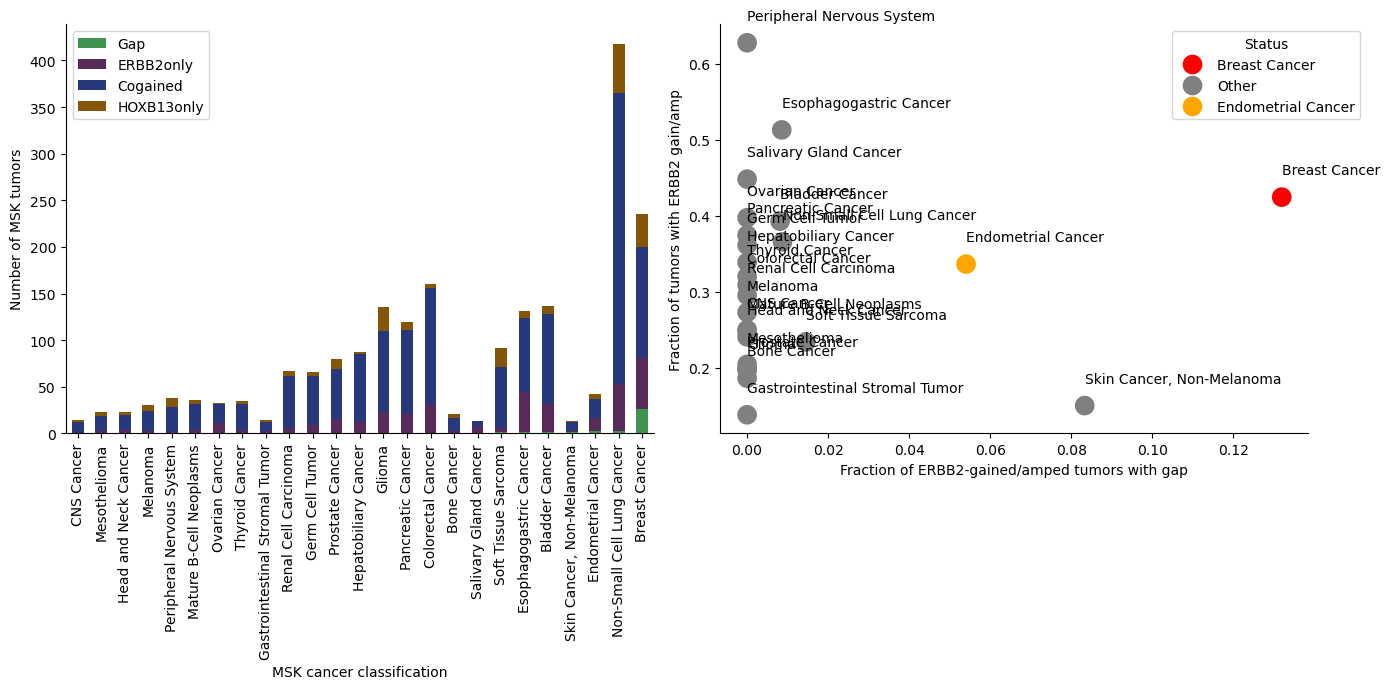

In [12]:
#repeating the figure but for MSK-IMPACT
#GISTIC command to generate thresholds
#./gp_gistic2_from_seg -b MSKIMPACT_GISTIC_results -seg Raw_data/msk_impact_2017/data_cna_hg19.seg -refgene refgenefiles/hg19.mat -rx 0 -genegistic 1 -smallmem 1 -broad 1 -brlen 0.5 -twosize 1 -armpeel 1 -savegene 1 -maxseg 10000 -conf 0.99

#collecting participant information
MSK_participant_info = pd.read_csv("Raw_data/msk_impact_2017/data_clinical_sample.txt", index_col = 0, header = 4, sep = "\t")
MSK_participant_info = MSK_participant_info[~MSK_participant_info.index.duplicated(keep='first')]
MSK_participant_info = MSK_participant_info.loc[MSK_participant_info["SAMPLE_TYPE"] == "Primary"]

MSK_gistic_CN = pd.read_csv("MSKIMPACT_GISTIC_results/all_thresholded.by_genes.txt", sep ="\t", index_col = 0)
MSK_gistic_CN = MSK_gistic_CN.drop(["Cytoband", "Locus ID"], axis = 1)
#cutting names so they match the other datasets' formats
MSK_gistic_CN.columns = [x.split("-T")[0] for x in MSK_gistic_CN.columns]
MSK_gistic_CN.dropna(inplace = True)

MSK_HER_gained_participants = MSK_gistic_CN.loc[:, MSK_gistic_CN.loc['ERBB2'] > 0].columns
MSK_HOX_gained_participants = MSK_gistic_CN.loc[:, MSK_gistic_CN.loc['HOXB13'] > 0].columns
MSK_HER_nongained_participants = MSK_gistic_CN.loc[:, MSK_gistic_CN.loc['ERBB2'] < 1].columns
MSK_HOX_nongained_participants = MSK_gistic_CN.loc[:, MSK_gistic_CN.loc['HOXB13'] < 1].columns
MSK_HOX_amped_participants = MSK_gistic_CN.loc[:, MSK_gistic_CN.loc['HOXB13'] > 1].columns

MSK_gap_participants = MSK_gistic_CN.loc[:, MSK_gistic_CN.loc['ERBB2'] > 0].columns & MSK_gistic_CN.loc[:, MSK_gistic_CN.loc['HOXB13'] > 0].columns & MSK_gistic_CN.loc[:, MSK_gistic_CN.loc['BRCA1'] < 0].columns
MSK_ERBB2only_participants = MSK_HER_gained_participants.intersection(MSK_HOX_nongained_participants)
MSK_co_gained_participants = (MSK_gistic_CN.loc[:, MSK_gistic_CN.loc['HOXB13'] > 0].columns) & (MSK_gistic_CN.loc[:, MSK_gistic_CN.loc['ERBB2'] > 0].columns) & (MSK_gistic_CN.loc[:, MSK_gistic_CN.loc['BRCA1'] > -1].columns)
MSK_HOXB13only_participants = MSK_HOX_gained_participants.intersection(MSK_HER_nongained_participants)

#finding tumor types with at least 10 cases of ERBB2 amplification
print(MSK_participant_info.loc[np.in1d(MSK_participant_info.index, MSK_HER_gained_participants)]["CANCER_TYPE"].value_counts())

MSK_included_tumortypes = pd.DataFrame(MSK_participant_info.loc[np.in1d(MSK_participant_info.index, MSK_HER_gained_participants)]["CANCER_TYPE"].value_counts())
MSK_included_tumortypes = MSK_included_tumortypes.loc[MSK_included_tumortypes["CANCER_TYPE"] > 10]

#making barplot dataframe
MSK_pancan_cohort_categorization_df = pd.DataFrame(index = list(MSK_included_tumortypes.index))
MSK_pancan_gap_list = []
MSK_pancan_erbb2only_list = []
MSK_pancan_cogained_list = []
MSK_pancan_hoxb13only_list = []
MSK_pancan_number_of_tumors = []
MSK_pancan_number_of_ERBB2gaintumors = []

MSK_pancan_normalized_gap_list = []
MSK_pancan_normalized_erbb2gain_list = []

for x in MSK_pancan_cohort_categorization_df.index:
    current_cancer_type_tumors = MSK_participant_info.loc[MSK_participant_info["CANCER_TYPE"] == x].index
    MSK_pancan_gap_list.append(len(set(current_cancer_type_tumors) & set(MSK_gap_participants)))
    MSK_pancan_erbb2only_list.append(len(set(current_cancer_type_tumors) & set(MSK_ERBB2only_participants)))
    MSK_pancan_cogained_list.append(len(set(current_cancer_type_tumors) & set(MSK_co_gained_participants)))
    MSK_pancan_hoxb13only_list.append(len(set(current_cancer_type_tumors) & set(MSK_HOXB13only_participants)))
    MSK_pancan_number_of_tumors.append(len(current_cancer_type_tumors))

    MSK_pancan_number_of_ERBB2gaintumors.append(len(MSK_HER_gained_participants & current_cancer_type_tumors))
    current_cancer_numberofERBB2gain_total_pts = len(MSK_HER_gained_participants & current_cancer_type_tumors)

    MSK_pancan_normalized_gap_list.append(len(set(current_cancer_type_tumors) & set(MSK_gap_participants))/current_cancer_numberofERBB2gain_total_pts)
    MSK_pancan_normalized_erbb2gain_list.append(current_cancer_numberofERBB2gain_total_pts/len(current_cancer_type_tumors))


waterfall_palette = ["#419450", "#592A5C", "#28387C", "#855607"]
fig, ax = plt.subplots(1, 2, figsize=(14, 7))
MSK_pancan_cohort_categorization_df["Gap"] = MSK_pancan_gap_list
MSK_pancan_cohort_categorization_df["ERBB2only"] = MSK_pancan_erbb2only_list
MSK_pancan_cohort_categorization_df["Cogained"] = MSK_pancan_cogained_list
MSK_pancan_cohort_categorization_df["HOXB13only"] = MSK_pancan_hoxb13only_list

MSK_pancan_cohort_categorization_df = MSK_pancan_cohort_categorization_df.sort_values(by = "Gap", ascending = True)

ax[0].set_ylabel("Number of MSK tumors")
ax[0].set_xlabel("MSK cancer classification")
MSK_pancan_cohort_categorization_df.plot(kind='bar', stacked=True, ax = ax[0], color = waterfall_palette)


normalized_MSK_pancan_cohort_categorization_df = pd.DataFrame(index = list(MSK_included_tumortypes.index))

normalized_MSK_pancan_cohort_categorization_df["Gap"] = MSK_pancan_normalized_gap_list
normalized_MSK_pancan_cohort_categorization_df["ERBB2 gain %"] = MSK_pancan_normalized_erbb2gain_list
normalized_MSK_pancan_cohort_categorization_df = normalized_MSK_pancan_cohort_categorization_df.loc[MSK_pancan_cohort_categorization_df.index[::-1]]
normalized_MSK_pancan_cohort_categorization_df.sort_values(by = "Gap", ascending = False, inplace = True)
normalized_MSK_pancan_cohort_categorization_df["Status"] = "Other"
normalized_MSK_pancan_cohort_categorization_df.loc["Breast Cancer", "Status"] = "Breast Cancer"
normalized_MSK_pancan_cohort_categorization_df.loc["Endometrial Cancer", "Status"] = "Endometrial Cancer"
color_palette = ["red", "grey", "orange"]
sns.scatterplot(x = normalized_MSK_pancan_cohort_categorization_df["Gap"], y = normalized_MSK_pancan_cohort_categorization_df["ERBB2 gain %"], linewidth=0, s = 200, palette = color_palette, hue = normalized_MSK_pancan_cohort_categorization_df["Status"], ax = ax[1])

ax[1].set_ylabel("Fraction of tumors with ERBB2 gain/amp")
ax[1].set_xlabel("Fraction of ERBB2-gained/amped tumors with gap")
ax[1].legend(bbox_to_anchor=(1.1, 1.0), title="Status")

#adding in tumor annotations
for index, row in normalized_MSK_pancan_cohort_categorization_df.iterrows():
    ax[1].text(row.Gap, row["ERBB2 gain %"]+0.03, row.name)

plt.savefig('Figures/Figure4B.pdf')

#renaming columns and exporting
normalized_MSK_pancan_cohort_categorization_df.columns = ["Fraction of ERBB2-gained tumors with gap", "Fraction of tumors with ERBB2 gain", "Status"]
normalized_MSK_pancan_cohort_categorization_df.to_csv("Figure4B_normalized_MSK_pancan_cohort_categorization.txt", sep = "\t")


Invasive Breast Carcinoma            7
Ovarian Epithelial Tumor             6
Esophagogastric Adenocarcinoma       6
Diffuse Glioma                       5
Melanoma                             4
Colorectal Adenocarcinoma            3
Non-Small Cell Lung Cancer           3
Breast Ductal Carcinoma In Situ      3
Renal Cell Carcinoma                 3
Endometrial Carcinoma                2
Pancreatic Adenocarcinoma            2
Myeloproliferative Neoplasms         1
Neuroblastoma                        1
Non-Hodgkin Lymphoma                 1
Anaplastic Thyroid Cancer            1
B-Lymphoblastic Leukemia/Lymphoma    1
Cervical Squamous Cell Carcinoma     1
Bladder Urothelial Carcinoma         1
Name: Cell_line_type, dtype: int64


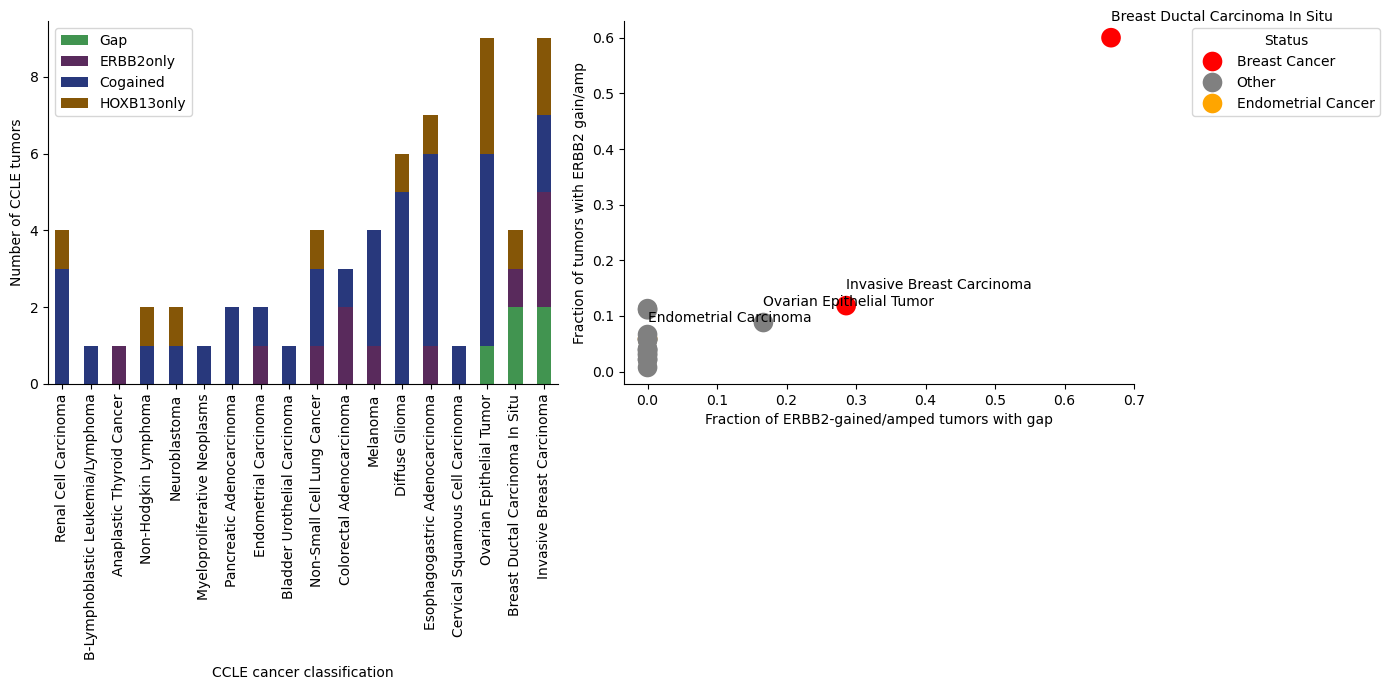

In [13]:
#repeating the figure but for CCLE DEPMAP
#GISTIC command to generate thresholds
#./gp_gistic2_from_seg -b CCLE_GISTIC_results -seg Raw_data/CCLE_copynumber_2013-12-03.seg.txt -refgene refgenefiles/hg19.mat -rx 0 -genegistic 1 -smallmem 1 -broad 1 -brlen 0.5 -twosize 1 -armpeel 1 -savegene 1 -maxseg 10000 -conf 0.99

#rearranging this df in order to match IDs
CCLE_allcelllines_bio_info = CCLE_allcelllines_CN_data[["Cell_line_name", "Cell_line_type"]]
CCLE_allcelllines_bio_info.index = CCLE_allcelllines_bio_info["Cell_line_name"]
CCLE_allcelllines_bio_info.dropna(inplace = True)

CCLE_gistic_CN = pd.read_csv("CCLE_GISTIC_results/all_thresholded.by_genes.txt", sep ="\t", index_col = 0)
CCLE_gistic_CN = CCLE_gistic_CN.drop(["Cytoband", "Locus ID"], axis = 1)
#cutting names so they match the other datasets' formats
CCLE_gistic_CN.columns = [x.split("_")[0] for x in CCLE_gistic_CN.columns]
CCLE_gistic_CN.dropna(inplace = True)

CCLE_HER_gained_participants = CCLE_gistic_CN.loc[:, CCLE_gistic_CN.loc['ERBB2'] > 0].columns
CCLE_HOX_gained_participants = CCLE_gistic_CN.loc[:, CCLE_gistic_CN.loc['HOXB13'] > 0].columns
CCLE_HER_nongained_participants = CCLE_gistic_CN.loc[:, CCLE_gistic_CN.loc['ERBB2'] < 1].columns
CCLE_HOX_nongained_participants = CCLE_gistic_CN.loc[:, CCLE_gistic_CN.loc['HOXB13'] < 1].columns
CCLE_HOX_amped_participants = CCLE_gistic_CN.loc[:, CCLE_gistic_CN.loc['HOXB13'] > 1].columns

CCLE_gap_participants = CCLE_gistic_CN.loc[:, CCLE_gistic_CN.loc['ERBB2'] > 0].columns & CCLE_gistic_CN.loc[:, CCLE_gistic_CN.loc['HOXB13'] > 0].columns & CCLE_gistic_CN.loc[:, CCLE_gistic_CN.loc['BRCA1'] < 0].columns
CCLE_ERBB2only_participants = CCLE_HER_gained_participants.intersection(CCLE_HOX_nongained_participants)
CCLE_co_gained_participants = (CCLE_gistic_CN.loc[:, CCLE_gistic_CN.loc['HOXB13'] > 0].columns) & (CCLE_gistic_CN.loc[:, CCLE_gistic_CN.loc['ERBB2'] > 0].columns) & (CCLE_gistic_CN.loc[:, CCLE_gistic_CN.loc['BRCA1'] > -1].columns)
CCLE_HOXB13only_participants = CCLE_HOX_gained_participants.intersection(CCLE_HER_nongained_participants)

#finding tumor types with at least 1 cases of ERBB2 amplification
print(CCLE_allcelllines_bio_info.loc[np.in1d(CCLE_allcelllines_bio_info.index, CCLE_HER_gained_participants)]["Cell_line_type"].value_counts())

CCLE_included_tumortypes = pd.DataFrame(CCLE_allcelllines_bio_info.loc[np.in1d(CCLE_allcelllines_bio_info.index, CCLE_HER_gained_participants)]["Cell_line_type"].value_counts())
CCLE_included_tumortypes = CCLE_included_tumortypes.loc[CCLE_included_tumortypes["Cell_line_type"] >= 1]

#making barplot dataframe
CCLE_pancan_cohort_categorization_df = pd.DataFrame(index = list(CCLE_included_tumortypes.index))
CCLE_pancan_gap_list = []
CCLE_pancan_erbb2only_list = []
CCLE_pancan_cogained_list = []
CCLE_pancan_hoxb13only_list = []
CCLE_pancan_number_of_tumors = []

CCLE_pancan_normalized_gap_list = []
CCLE_pancan_normalized_erbb2gain_list = []
CCLE_pancan_number_of_ERBB2gaintumors = []

for x in CCLE_pancan_cohort_categorization_df.index:
    current_Cell_line_type_tumors = CCLE_allcelllines_bio_info.loc[CCLE_allcelllines_bio_info["Cell_line_type"] == x].index
    CCLE_pancan_gap_list.append(len(set(current_Cell_line_type_tumors) & set(CCLE_gap_participants)))
    CCLE_pancan_erbb2only_list.append(len(set(current_Cell_line_type_tumors) & set(CCLE_ERBB2only_participants)))
    CCLE_pancan_cogained_list.append(len(set(current_Cell_line_type_tumors) & set(CCLE_co_gained_participants)))
    CCLE_pancan_hoxb13only_list.append(len(set(current_Cell_line_type_tumors) & set(CCLE_HOXB13only_participants)))
    CCLE_pancan_number_of_tumors.append(len(current_Cell_line_type_tumors))

    CCLE_pancan_number_of_ERBB2gaintumors.append(len(CCLE_HER_gained_participants & current_Cell_line_type_tumors))
    current_cancer_numberofERBB2gain_total_pts = len(CCLE_HER_gained_participants & current_Cell_line_type_tumors)

    CCLE_pancan_normalized_gap_list.append(len(set(current_Cell_line_type_tumors) & set(CCLE_gap_participants))/current_cancer_numberofERBB2gain_total_pts)
    CCLE_pancan_normalized_erbb2gain_list.append(current_cancer_numberofERBB2gain_total_pts/len(current_Cell_line_type_tumors))


waterfall_palette = ["#419450", "#592A5C", "#28387C", "#855607"]
fig, ax = plt.subplots(1, 2, figsize=(14, 7))
CCLE_pancan_cohort_categorization_df["Gap"] = CCLE_pancan_gap_list
CCLE_pancan_cohort_categorization_df["ERBB2only"] = CCLE_pancan_erbb2only_list
CCLE_pancan_cohort_categorization_df["Cogained"] = CCLE_pancan_cogained_list
CCLE_pancan_cohort_categorization_df["HOXB13only"] = CCLE_pancan_hoxb13only_list

CCLE_pancan_cohort_categorization_df = CCLE_pancan_cohort_categorization_df.sort_values(by = "Gap", ascending = True)

ax[0].set_ylabel("Number of CCLE tumors")
ax[0].set_xlabel("CCLE cancer classification")
CCLE_pancan_cohort_categorization_df.plot(kind='bar', stacked=True, ax = ax[0], color = waterfall_palette)


normalized_CCLE_pancan_cohort_categorization_df = pd.DataFrame(index = list(CCLE_included_tumortypes.index))
normalized_CCLE_pancan_cohort_categorization_df["Gap"] = CCLE_pancan_normalized_gap_list
normalized_CCLE_pancan_cohort_categorization_df["ERBB2 gain %"] = CCLE_pancan_normalized_erbb2gain_list
normalized_CCLE_pancan_cohort_categorization_df = normalized_CCLE_pancan_cohort_categorization_df.loc[CCLE_pancan_cohort_categorization_df.index[::-1]]
normalized_CCLE_pancan_cohort_categorization_df.sort_values(by = "Gap", ascending = False, inplace = True)
normalized_CCLE_pancan_cohort_categorization_df["Status"] = "Other"
normalized_CCLE_pancan_cohort_categorization_df.loc[["Invasive Breast Carcinoma", "Breast Ductal Carcinoma In Situ"], "Status"] = "Breast Cancer"
normalized_CCLE_pancan_cohort_categorization_df.loc["Endometrial Carcinoma", "Status"] = "Endometrial Cancer"
color_palette = ["red", "grey", "orange"]
sns.scatterplot(x = normalized_CCLE_pancan_cohort_categorization_df["Gap"], y = normalized_CCLE_pancan_cohort_categorization_df["ERBB2 gain %"], linewidth=0, s = 200, palette = color_palette, hue = normalized_CCLE_pancan_cohort_categorization_df["Status"], ax = ax[1])

ax[1].set_ylabel("Fraction of tumors with ERBB2 gain/amp")
ax[1].set_xlabel("Fraction of ERBB2-gained/amped tumors with gap")
ax[1].legend(bbox_to_anchor=(1.1, 1.0), title="Status")

#adding in tumor annotations
normalized_CCLE_pancan_cohort_categorization_df_ANNOTATIONS = normalized_CCLE_pancan_cohort_categorization_df.loc[['Breast Ductal Carcinoma In Situ', 'Invasive Breast Carcinoma', 'Ovarian Epithelial Tumor', 'Endometrial Carcinoma']]
for index, row in normalized_CCLE_pancan_cohort_categorization_df_ANNOTATIONS.iterrows():
    ax[1].text(row.Gap, row["ERBB2 gain %"]+0.03, row.name)

plt.savefig('Figures/Figure4C.pdf')


#renaming columns and exporting
normalized_CCLE_pancan_cohort_categorization_df.columns = ["Fraction of ERBB2-gained tumors with gap", "Fraction of tumors with ERBB2 gain", "Status"]
normalized_CCLE_pancan_cohort_categorization_df.to_csv("Figure4C_normalized_CCLE_pancan_cohort_categorization.txt", sep = "\t")



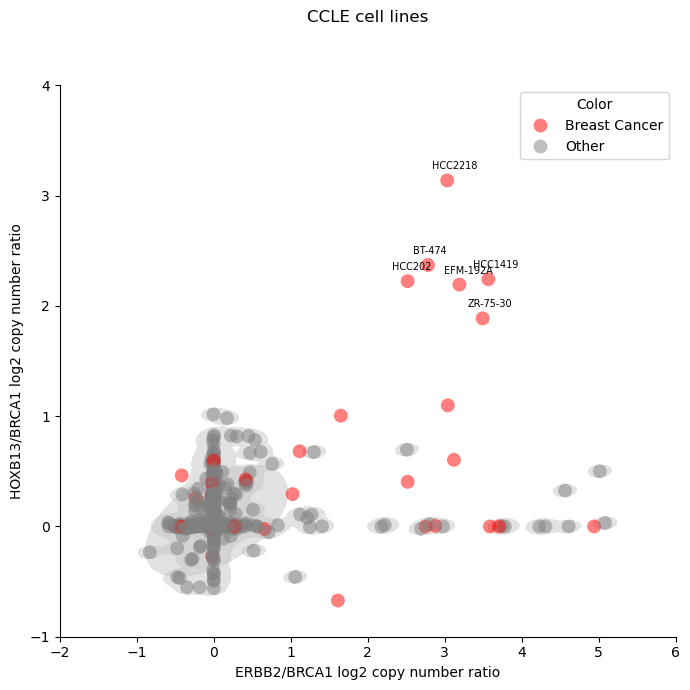

In [14]:
#Figure 4D
#supplemental lists of gap patients across each cohort
CCLE_allcelllines_CN_data.loc[(CCLE_allcelllines_CN_data["ERBB2/BRCA1 copy number ratio"] > np.log2(3)) & (CCLE_allcelllines_CN_data["HOXB13/BRCA1 copy number ratio"] > np.log2(3))].to_csv("Figures/CCLE_gapparticipantslist.txt", sep = "\t")

palette = ["Red", "Grey"]

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
sns.kdeplot(data = CCLE_allcelllines_CN_data, y = CCLE_allcelllines_CN_data["HOXB13/BRCA1 copy number ratio"], x = CCLE_allcelllines_CN_data["ERBB2/BRCA1 copy number ratio"], hue = CCLE_allcelllines_CN_data["Color"], palette = ["#757575"], alpha = 0.5, s=100, ax = ax, fill = True, thresh = 0.01)


ax.legend(bbox_to_anchor=(0.3, 1.0), title = "Cancer type")
ax.yaxis.set_major_locator(MultipleLocator(1))

sns.scatterplot(data = CCLE_allcelllines_CN_data, y = CCLE_allcelllines_CN_data["HOXB13/BRCA1 copy number ratio"], x = CCLE_allcelllines_CN_data["ERBB2/BRCA1 copy number ratio"], hue = CCLE_allcelllines_CN_data["Color"], palette = palette, linewidth=0, alpha = 0.5, s=100, ax = ax)


for index, row in CCLE_allcelllines_CN_data[CCLE_allcelllines_CN_data["HOXB13/BRCA1 copy number ratio"]>1.5].iterrows():
    ax.text(row["ERBB2/BRCA1 copy number ratio"]-0.2, row["HOXB13/BRCA1 copy number ratio"]+0.1, row["Cell_line_name"], size =7)

ax.set_ylabel("HOXB13/BRCA1 log2 copy number ratio")
ax.set_xlabel("ERBB2/BRCA1 log2 copy number ratio")

ax.set_xlim(-2, 6)
ax.set_ylim(-1, 4)

ax.set_title("CCLE cell lines")

plt.savefig('Figures/Figure4D.pdf')


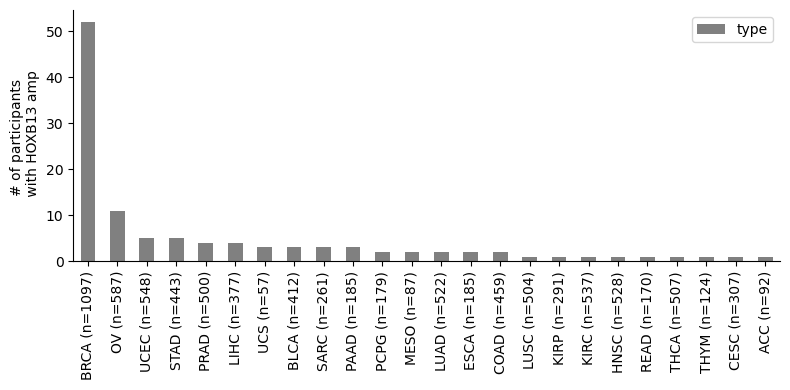

In [15]:
#Figure 4E
#HOXB13 amp unique to BRCA

fig, ax = plt.subplots(1, 1, figsize=(8, 4))

pancan_HOX_amped_participants = pancancer_tumor_copynumber_data.loc[:, pancancer_tumor_copynumber_data.loc['HOXB13'] == 2].columns
fig4d_pancan_HOX_amped_participants_df = pd.DataFrame(pancancer_clinical_and_survival_data.loc[np.in1d(pancancer_clinical_and_survival_data.index, pancan_HOX_amped_participants), "type"].value_counts())
fig4d_pancan_HOX_amped_participants_df.to_csv("Figures/TCGApancancounts_HOX_amped_participants.csv")
fig4d_pancan_HOX_amped_participants_df["total"] = [sum(pancancer_clinical_and_survival_data["type"] == x) for x in fig4d_pancan_HOX_amped_participants_df.index]
fig4d_pancan_HOX_amped_participants_df["x_ticks"] = ["{} (n={})".format(x, fig4d_pancan_HOX_amped_participants_df.loc[x, "total"]) for x in fig4d_pancan_HOX_amped_participants_df.index]
fig4d_pancan_HOX_amped_participants_df.drop(["total"], axis = 1, inplace = True)
fig4d_pancan_HOX_amped_participants_df.plot(kind='bar', color = "grey", ax = ax)
ax.set_ylabel("# of tumors \n with HOXB13 amp")
ax.set_xticklabels(fig4d_pancan_HOX_amped_participants_df["x_ticks"])

plt.savefig("Figures/Figure4E.pdf")

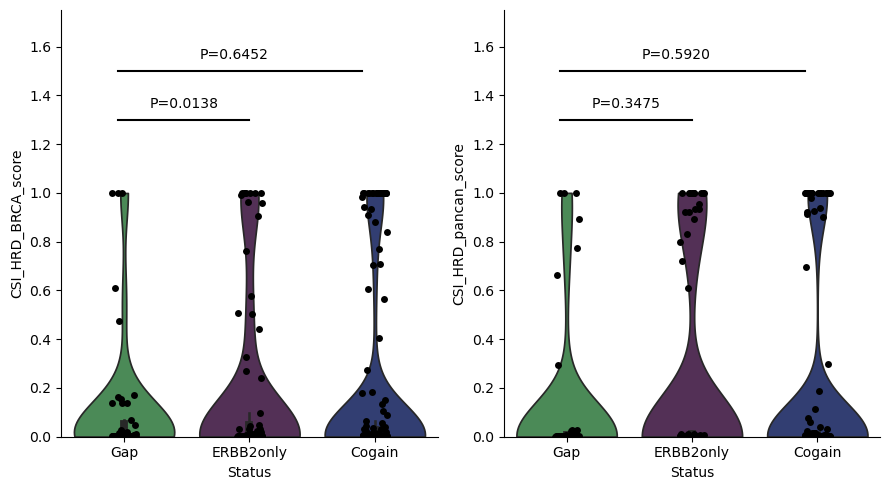

In [45]:
#Figure 5D
#Doga's data
Doga_signature_data = pd.read_csv("TCGA_BRCA_HRD_status_Irene.txt", index_col = 0, sep = "\t")
Doga_signature_data["Status"] = "None" 
Doga_signature_data.loc[np.in1d(Doga_signature_data.index, list(TCGA_BRCA_gap_participants)), "Status"] = "Gap"
Doga_signature_data.loc[np.in1d(Doga_signature_data.index, list(TCGA_BRCA_ERBB2only_participants)), "Status"] = "ERBB2only"
Doga_signature_data.loc[np.in1d(Doga_signature_data.index, list(TCGA_BRCA_co_gained_participants)), "Status"] = "Cogain"
Doga_signature_data = Doga_signature_data.loc[Doga_signature_data["Status"] != "None"]

fig, ax = plt.subplots(1, 2, figsize=(9, 5))

boxplot_palette = ["#419450", "#592A5C", "#28387C"]
sns.violinplot(x = Doga_signature_data["Status"], y = Doga_signature_data["CSI_HRD_BRCA_score"], order = ["Gap", "ERBB2only", "Cogain"], palette = boxplot_palette, ax = ax[0], cut = 0)
sns.violinplot(x = Doga_signature_data["Status"], y = Doga_signature_data["CSI_HRD_pancan_score"], order = ["Gap", "ERBB2only", "Cogain"], palette = boxplot_palette, ax = ax[1], cut = 0)

sns.stripplot(x = Doga_signature_data["Status"], y = Doga_signature_data["CSI_HRD_BRCA_score"], order = ["Gap", "ERBB2only", "Cogain"], color = "black", ax = ax[0])
sns.stripplot(x = Doga_signature_data["Status"], y = Doga_signature_data["CSI_HRD_pancan_score"], order = ["Gap", "ERBB2only", "Cogain"], color = "black", ax = ax[1])


ax[0].set_ylim(0, 1.75)
ax[1].set_ylim(0, 1.75)

ax[0].axhline(y=1.3, xmin=0.15, xmax=0.5, color="black")
ax[0].axhline(y=1.5, xmin=0.15, xmax=0.80, color="black")
ax[1].axhline(y=1.3, xmin=0.15, xmax=0.5, color="black")
ax[1].axhline(y=1.5, xmin=0.15, xmax=0.80, color="black")

#converting to lists for code to work
TCGA_BRCA_ERBB2only_participants = list(TCGA_BRCA_ERBB2only_participants)
TCGA_BRCA_HOXB13only_participants = list(TCGA_BRCA_HOXB13only_participants)
TCGA_BRCA_co_gained_participants = list(TCGA_BRCA_co_gained_participants)
TCGA_BRCA_gap_participants = list(TCGA_BRCA_gap_participants)

#making pairwise p val dataframe
doga_pval_pairwise_df = pd.DataFrame(columns = ["P value"])
for x in ["CSI_HRD_BRCA_score", "CSI_HRD_pancan_score"]:
    doga_pval_pairwise_df.loc["ERBB2 vs gap {}".format(x), "P value"] = mannwhitneyu(Doga_signature_data.loc[np.in1d(Doga_signature_data.index, TCGA_BRCA_ERBB2only_participants), x], Doga_signature_data.loc[np.in1d(Doga_signature_data.index, TCGA_BRCA_gap_participants), x])[1]
    doga_pval_pairwise_df.loc["cogain vs gap {}".format(x), "P value"] = mannwhitneyu(Doga_signature_data.loc[np.in1d(Doga_signature_data.index, TCGA_BRCA_co_gained_participants), x].dropna(), Doga_signature_data.loc[np.in1d(Doga_signature_data.index, TCGA_BRCA_gap_participants), x])[1]


ax[0].text(0.6, 1.55, "P=" + str("{0:.4f}".format(doga_pval_pairwise_df.loc["ERBB2 vs gap CSI_HRD_BRCA_score", "P value"])))
ax[0].text(0.2, 1.35, "P=" + str("{0:.4f}".format(doga_pval_pairwise_df.loc["cogain vs gap CSI_HRD_BRCA_score", "P value"])))

ax[1].text(0.6, 1.55, "P=" + str("{0:.4f}".format(doga_pval_pairwise_df.loc["ERBB2 vs gap CSI_HRD_pancan_score", "P value"])))
ax[1].text(0.2, 1.35, "P=" + str("{0:.4f}".format(doga_pval_pairwise_df.loc["cogain vs gap CSI_HRD_pancan_score", "P value"])))


plt.savefig('Figures/Figure5D.pdf')

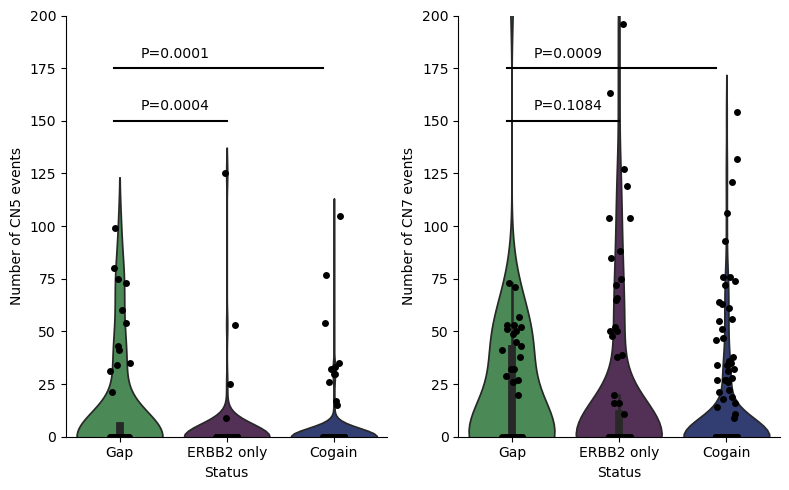

In [17]:
#Figure 5E
#Using assignment for CNV
CNV_mastercalls = mastercalls.dropna(axis = 0, thresh = 17)
CNV_participants = set(CNV_mastercalls.index) & (set(TCGA_BRCA_gap_participants) | set(TCGA_BRCA_ERBB2only_participants) | set(TCGA_BRCA_HOXB13only_participants) | set(TCGA_BRCA_co_gained_participants))

for name in CNV_participants:
    if (not Path("individual_CNV/{}_CNVassignmentoutput/Assignment_Solution/Activities/Assignment_Solution_Activities.txt".format(name)).is_file()):
        current_calls = pd.DataFrame()
        current_calls = mastercalls.loc[name]
        current_calls = current_calls.rename_axis('sample').reset_index()
        current_calls.to_csv("individual_CNV/{}_calls.txt".format(name), index = False, header = True, sep='\t')
    
        scna.generateCNVMatrix("ABSOLUTE", "individual_CNV/{}_calls.txt".format(name), "individual_CNV/{}_CNVmatrix".format(name), "./")
        Analyze.cosmic_fit("individual_CNV/{}_CNVmatrix.CNV48.matrix.tsv".format(name), "individual_CNV/{}_CNVassignmentoutput".format(name), "vcf",sample_reconstruction_plots = "pdf", collapse_to_SBS96 = False)
        

pt_names = listdir("individual_CNV", "*_CNVassignmentoutput")
COSMIC_assigned_dict = {}

for x in range(0, len(pt_names)):
    #CNV
    CNV48_data = pd.read_csv("individual_CNV/{}/Assignment_Solution/Activities/Assignment_Solution_Activities.txt".format(pt_names[x]), sep = "\t").apply(pd.to_numeric, errors = "ignore")
    CNV48_data = CNV48_data.drop(["Samples"], axis = 1)
    COSMIC_assigned_dict[pt_names[x]]= CNV48_data
    
COSMIC_assigned_final_df = pd.concat(COSMIC_assigned_dict.values(),keys=COSMIC_assigned_dict.keys()).apply(pd.to_numeric, errors = "coerce")
COSMIC_assigned_final_df.index = pt_names
COSMIC_assigned_final_df.index = [x.split("_CNV")[0] for x in COSMIC_assigned_final_df.index]


concat_pt_list = list(TCGA_BRCA_gap_participants) + list(TCGA_BRCA_ERBB2only_participants) + list(TCGA_BRCA_co_gained_participants) + list(TCGA_BRCA_HOXB13only_participants)
sorted_concat_pt_list = [ele for ele in concat_pt_list if ele in COSMIC_assigned_final_df.index]
COSMIC_assigned_final_df = COSMIC_assigned_final_df.loc[sorted_concat_pt_list]

for x in range(1, 25):
    column_sum = COSMIC_assigned_final_df.sum(axis = 1)
    COSMIC_assigned_final_df["% CN{}".format(x)] = 100*COSMIC_assigned_final_df["CN{}".format(x)]/column_sum

COSMIC_assigned_final_df["Status"] = np.nan
COSMIC_assigned_final_df.loc[np.in1d(COSMIC_assigned_final_df.index, TCGA_BRCA_gap_participants), "Status"] = "Gap"
COSMIC_assigned_final_df.loc[np.in1d(COSMIC_assigned_final_df.index, TCGA_BRCA_ERBB2only_participants), "Status"] = "ERBB2 only"
COSMIC_assigned_final_df.loc[np.in1d(COSMIC_assigned_final_df.index, TCGA_BRCA_co_gained_participants), "Status"] = "Cogain"
COSMIC_assigned_final_df.dropna(subset = "Status", inplace = True)
COSMIC_assigned_final_df.to_csv("Figures/TCGA_CNVprojections.csv")

#making pairwise p val dataframe
cosmicassigned_pval_pairwise_df = pd.DataFrame(columns = ["P value"])
for x in range(1, 25):
    cosmicassigned_pval_pairwise_df.loc["ERBB2 vs gap CN{}".format(x), "P value"] = mannwhitneyu(COSMIC_assigned_final_df.loc[np.in1d(COSMIC_assigned_final_df.index, TCGA_BRCA_ERBB2only_participants), "% CN{}".format(x)], COSMIC_assigned_final_df.loc[np.in1d(COSMIC_assigned_final_df.index, TCGA_BRCA_gap_participants), "% CN{}".format(x)])[1]
    cosmicassigned_pval_pairwise_df.loc["cogain vs gap CN{}".format(x), "P value"] = mannwhitneyu(COSMIC_assigned_final_df.loc[np.in1d(COSMIC_assigned_final_df.index, TCGA_BRCA_co_gained_participants), "% CN{}".format(x)], COSMIC_assigned_final_df.loc[np.in1d(COSMIC_assigned_final_df.index, TCGA_BRCA_gap_participants), "% CN{}".format(x)])[1]

#CN7 and 5 for the manuscript
cosmic_palette = ["#419450", "#592A5C", "#28387C"]

fig, ax = plt.subplots(1, 2, figsize=(8, 5))
sns.violinplot(data = COSMIC_assigned_final_df, y = COSMIC_assigned_final_df["CN5"], x = COSMIC_assigned_final_df["Status"], ax = ax[0], palette = cosmic_palette).set_ylabel("Number of CN5 events")
sns.violinplot(data = COSMIC_assigned_final_df, y = COSMIC_assigned_final_df["CN7"], x = COSMIC_assigned_final_df["Status"], ax = ax[1], palette = cosmic_palette).set_ylabel("Number of CN7 events")
sns.stripplot(data = COSMIC_assigned_final_df, y = COSMIC_assigned_final_df["CN5"], x = COSMIC_assigned_final_df["Status"], ax = ax[0], color = "black").set_ylabel("Number of CN5 events")
sns.stripplot(data = COSMIC_assigned_final_df, y = COSMIC_assigned_final_df["CN7"], x = COSMIC_assigned_final_df["Status"], ax = ax[1], color = "black").set_ylabel("Number of CN7 events")


ax[0].set_ylim(0, 200)
ax[1].set_ylim(0, 200)
ax[0].axhline(y=175, xmin=0.15, xmax=0.8, color="black")
ax[0].axhline(y=150, xmin=0.15, xmax=0.5, color="black")
ax[1].axhline(y=150, xmin=0.15, xmax=0.5, color="black")
ax[1].axhline(y=175, xmin=0.15, xmax=0.8, color="black")

ax[0].text(0.2, 155, "P=" + str("{0:.4f}".format(cosmicassigned_pval_pairwise_df.loc["ERBB2 vs gap CN5", "P value"])))
ax[1].text(0.2, 155, "P=" + str("{0:.4f}".format(cosmicassigned_pval_pairwise_df.loc["ERBB2 vs gap CN7", "P value"])))
ax[0].text(0.2, 180, "P=" + str("{0:.4f}".format(cosmicassigned_pval_pairwise_df.loc["cogain vs gap CN5", "P value"])))
ax[1].text(0.2, 180, "P=" + str("{0:.4f}".format(cosmicassigned_pval_pairwise_df.loc["cogain vs gap CN7", "P value"])))


plt.savefig('Figures/Figure5E.pdf')

Chisquared p value 2.807652079998839e-06


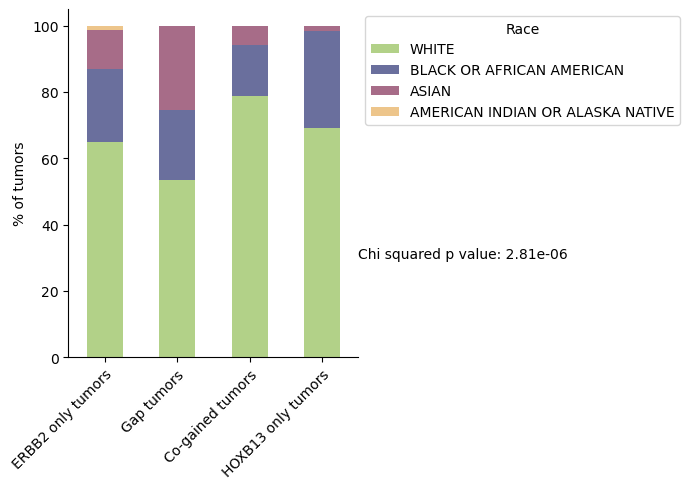

In [18]:
#Figure 5F
#checking distribution of race across the 3 groups
tcgarace_palette = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#B2D188", "#6A6F9D", "#A76C88", "#EDC58B"])

combined_racedf = pd.DataFrame()
combined_racedf["ERBB2 only tumors"] = TCGA_BRCA_clinical_and_survival_data.loc[TCGA_BRCA_ERBB2only_participants, "race"].value_counts()
combined_racedf["Gap tumors"] = TCGA_BRCA_clinical_and_survival_data.loc[TCGA_BRCA_gap_participants, "race"].value_counts()
combined_racedf["Co-gained tumors"] = TCGA_BRCA_clinical_and_survival_data.loc[TCGA_BRCA_co_gained_participants, "race"].value_counts()
combined_racedf["HOXB13 only tumors"] = TCGA_BRCA_clinical_and_survival_data.loc[TCGA_BRCA_HOXB13only_participants, "race"].value_counts()
combined_racedf = combined_racedf.fillna(0)
combined_racedf = combined_racedf.transpose()
#dropping those without any data entered
combined_racedf = combined_racedf.drop("[Not Available]", axis = 1)

#getting % values
for x in range (0, len(combined_racedf.index)):
    combined_racedf.iloc[x] = (combined_racedf.iloc[x] * 100)/combined_racedf.iloc[x].sum()

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
combined_racedf.plot(kind='bar', stacked=True, ax = ax, colormap = tcgarace_palette)
plt.xticks(rotation = 45)
ax.set_ylabel('% of tumors')
ax.legend(bbox_to_anchor=(1.0, 1.0), title="Race")
#p values
stat, p, dof, expected = chi2_contingency(combined_racedf)
print("Chisquared p value", str(p))
plt.text(3.5, 30, "Chi squared p value: " + str("{:.3}".format(p)))

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

plt.savefig('Figures/Figure5F.pdf')

Median survival for Gap 2893.537503171
Median survival for ERBB2 only gained 6058.3916733060005
Pairwise p value for Gap vs ERBB2 only gained : 0.068
Median survival for Gap 3014.0
Median survival for ERBB2 only gained 4456.0
Pairwise p value for Gap vs ERBB2 only gained : 0.77
Median survival for Gap 998.579167761
Median survival for ERBB2 only gained 6058.3916733060005
Pairwise p value for Gap vs ERBB2 only gained : 0.0078
Median survival for Gap 2893.537503171
Median survival for co-gained 5440.933339296
Pairwise p value for Gap vs co-gained : 0.022
Median survival for Gap 3014.0
Median survival for co-gained 5440.933339296
Pairwise p value for Gap vs co-gained : 0.47
Median survival for Gap 998.579167761
Median survival for co-gained 2041.0
Pairwise p value for Gap vs co-gained : 0.26
Median survival for co-gained 5440.933339296
Median survival for ERBB2 only gained 6058.3916733060005
Pairwise p value for co-gained vs ERBB2 only gained : 0.66
Median survival for co-gained 5440.9333

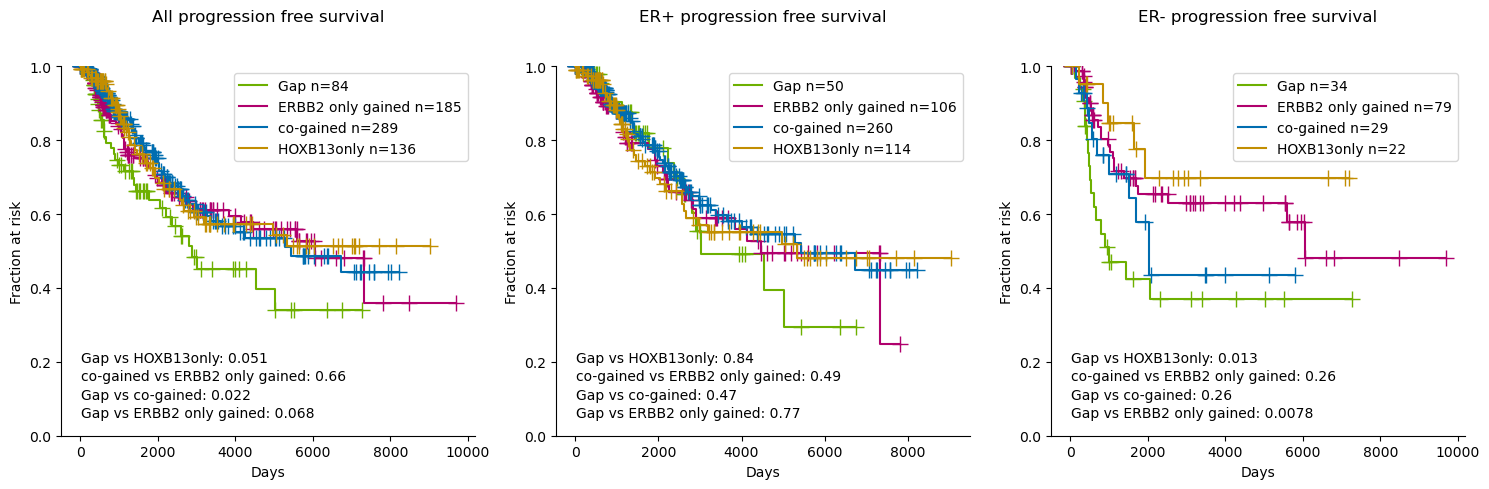

In [19]:
#merging the previous two so that all three curves are shown
#but the p values are pairwise
#Figure 6AB - Survival analyses on overall and progression free survival with all three curves together

#Figure 6AB - Survival analyses on overall and progression free survival with all three curves together
#this one makes the pairwise p values
pairing_list_1 = ["Gap", "Gap", "Gap", "Gap", "Gap", "Gap", 'co-gained', 'co-gained', 'co-gained', "Gap", "Gap", "Gap"]
pairing_list_2 = ["ERBB2 only gained", "ERBB2 only gained", "ERBB2 only gained", 'co-gained', 'co-gained', 'co-gained', "ERBB2 only gained", "ERBB2 only gained", "ERBB2 only gained", "HOXB13only", "HOXB13only", "HOXB13only"]
color_list_1 = ["#6db000", "#6db000", "#6db000", "#6db000", "#6db000", "#6db000", '#006db0', '#006db0', '#006db0', "#6db000", "#6db000", "#6db000"]
color_list_2 = ["#b0006d", "#b0006d", "#b0006d", '#006db0', '#006db0', '#006db0', "#b0006d", "#b0006d", "#b0006d", "#c28e01", "#c28e01", "#c28e01"]
dataset_list = [all_concatsurvival, ERpos_concatsurvival, ERneg_concatsurvival, all_concatsurvival, ERpos_concatsurvival, ERneg_concatsurvival, all_concatsurvival, ERpos_concatsurvival, ERneg_concatsurvival, all_concatsurvival, ERpos_concatsurvival, ERneg_concatsurvival]
title_list = ["All progression free survival", "ER+ progression free survival", "ER- progression free survival", "All progression free survival", "ER+ progression free survival", "ER- progression free survival","All progression free survival", "ER+ progression free survival", "ER- progression free survival", "All progression free survival", "ER+ progression free survival", "ER- progression free survival"]
pairwise_pval_list = []

list_counter = 0
for x in range (0, 4):
    for y in range (0, 3):
        first_group = pairing_list_1[list_counter]
        second_group = pairing_list_2[list_counter]
        chosen_dataset = dataset_list[list_counter]
        title_name = title_list[list_counter]
        T = chosen_dataset['PFI.time']
        E = chosen_dataset['PFI']
        kmf1 = KaplanMeierFitter();
        groups = chosen_dataset['Status']   
        i1 = (groups == first_group);
        i2 = (groups == second_group);     
        kmf1.fit(T[i1], E[i1], label=first_group);
        median_ = kmf1.median_survival_time_
        print("Median survival for", first_group, median_)
        
        kmf1.fit(T[i2], E[i2], label=second_group);
        median_ = kmf1.median_survival_time_
        print("Median survival for", second_group, median_)

        results = logrank_test(T[i1], T[i2], E[i1], E[i2], alpha=0.05)
        
        print("Pairwise p value for", first_group, "vs", second_group, ":", str("{:.2}".format(results.p_value)))
        pairwise_pval_list.append(str(first_group + " vs " + second_group + ": " + str("{:.2}".format(results.p_value))))
        list_counter = list_counter+1
        
pairwise_pval_list




fig, axarr = plt.subplots(1, 3, figsize=(15, 5))
dataset_list = [all_concatsurvival, ERpos_concatsurvival, ERneg_concatsurvival]
title_list = ["All progression free survival", "ER+ progression free survival", "ER- progression free survival"]
time_list = ["PFI.time","PFI.time", "PFI.time"]
event_list = ["PFI", "PFI", "PFI"]

list_counter = 0
for y in range (0, 3):
        chosen_dataset = dataset_list[list_counter]
        title_name = title_list[list_counter]
        plt.sca(axarr[y])
        T = chosen_dataset[time_list[list_counter]]
        E = chosen_dataset[event_list[list_counter]]
        kmf1 = KaplanMeierFitter();
        groups = chosen_dataset['Status']   
        i1 = (groups == "Gap");
        i2 = (groups == "ERBB2 only gained");     
        i3 = (groups == "co-gained"); 
        i4 = (groups == "HOXB13only"); 
        kmf1.fit(T[i1], E[i1], label="Gap");
        a1 = kmf1.plot(show_censors=True, ci_show=False, color = "#6db000");
        median_ = kmf1.median_survival_time_
        print("Median survival for Gap", median_)
        
        kmf1.fit(T[i2], E[i2], label="ERBB2 only gained");
        a2 = kmf1.plot(show_censors=True, ci_show=False, color = "#b0006d");
        median_ = kmf1.median_survival_time_
        print("Median survival for ERBB2 only gained", median_)
        
        kmf1.fit(T[i3], E[i3], label="co-gained");
        a3 = kmf1.plot(show_censors=True, ci_show=False, color = "#006db0");
        median_ = kmf1.median_survival_time_
        print("Median survival for co-gained", median_)

        kmf1.fit(T[i4], E[i4], label="HOXB13only");
        a4 = kmf1.plot(show_censors=True, ci_show=False, color = "#c28e01");
        median_ = kmf1.median_survival_time_
        print("Median survival for HOXB13only", median_)
        
        plt.xlabel("Days")
        plt.ylim(0,1)
        plt.ylabel("Fraction at risk")
        plt.title(title_name)
        plt.legend(["_nolegend_", "Gap n=" + str(len(E[i1])), "_nolegend_", "ERBB2 only gained n=" + str(len(E[i2])), "_nolegend_", "co-gained n=" + str(len(E[i3])), "_nolegend_", "HOXB13only n=" + str(len(E[i4]))])
        results = multivariate_logrank_test(T, E, chosen_dataset["Status"] , alpha=0.05)
        plt.text(10, 0.05, pairwise_pval_list[0 + y])
        plt.text(10, 0.1, pairwise_pval_list[3 + y])
        plt.text(10, 0.15, pairwise_pval_list[6 + y])
        plt.text(10, 0.2, pairwise_pval_list[9 + y])
        
        list_counter = list_counter+1
        

plt.savefig('Figures/Figure6AB.pdf')


,Gap tumors,ERBB2 only tumors,co-gain tumors,HOXB13 only tumors,HOXB13/ERBB2 no gain
Gap tumors,NaN,0.680032,0.00004,0.027493,0.000027
ERBB2 only tumors,0.680032,NaN,0.000001,0.027402,0.0
co-gain tumors,0.00004,0.000001,NaN,0.04404,0.631726
HOXB13 only tumors,0.027493,0.027402,0.04404,NaN,0.051394
HOXB13/ERBB2 no gain,0.000027,0.0,0.631726,0.051394,NaN


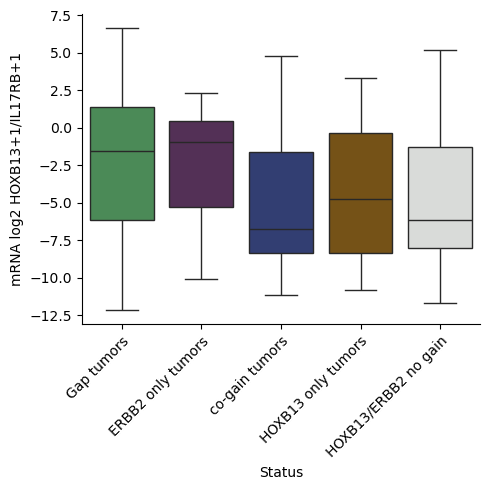

In [20]:
#FIGURE 6C
#HOXB13/IL17RB mRNA for the various groups with ER+/ER- split for each group
#making temporary dataframe to annotate
boxplot_palette = ["#419450", "#592A5C", "#28387C", "#855607",  "#D9DBD9"]

TCGA_BRCA_mRNA_tumor_data.loc["HOXB13/IL17RB"] = TCGA_BRCA_mRNA_tumor_data.loc["HOXB13"]/TCGA_BRCA_mRNA_tumor_data.loc["IL17RB"]
Figure6C_tempdf = TCGA_BRCA_mRNA_tumor_data.copy()
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
#adding 1 to IL17RB and HOXB13 to avoid dividng by zero errors
Figure6C_tempdf.loc["log2 HOXB13/IL17RB"] = np.log2((Figure6C_tempdf.loc["HOXB13"] + 1)/(Figure6C_tempdf.loc["IL17RB"] + 1))
Figure6C_tempdf.loc["Status"] = "HOXB13/ERBB2 no gain"

#making everything a set so operations work
TCGA_BRCA_ERBB2only_participants = set(TCGA_BRCA_ERBB2only_participants)
TCGA_BRCA_ERpos_participants = set(TCGA_BRCA_ERpos_participants)
TCGA_BRCA_ERneg_participants = set(TCGA_BRCA_ERneg_participants)
TCGA_BRCA_gap_participants = set(TCGA_BRCA_gap_participants)
TCGA_BRCA_co_gained_participants = set(TCGA_BRCA_co_gained_participants)

Figure6C_tempdf.loc["Status", TCGA_BRCA_ERBB2only_participants] = "ERBB2 only tumors"
Figure6C_tempdf.loc["Status", TCGA_BRCA_co_gained_participants] = "co-gain tumors"
Figure6C_tempdf.loc["Status", TCGA_BRCA_gap_participants] = "Gap tumors"
Figure6C_tempdf.loc["Status", TCGA_BRCA_HOXB13only_participants] = "HOXB13 only tumors"

group_order = ["Gap tumors", "ERBB2 only tumors", "co-gain tumors", "HOXB13 only tumors", "HOXB13/ERBB2 no gain", ]
sns.boxplot(palette = boxplot_palette, order = group_order, y = Figure6C_tempdf.loc["log2 HOXB13/IL17RB"], x = Figure6C_tempdf.loc["Status"], showfliers=False)

ax.set_ylabel("mRNA log2 HOXB13+1/IL17RB+1")

#make list of all pairwise p vals here
p_val_table = pd.DataFrame(columns = group_order, index = group_order)
for x in group_order:
    for y in group_order:
        if (x != y):
            p_val_table.loc[x, y] = mannwhitneyu(list(Figure6C_tempdf.loc[:, Figure6C_tempdf.loc["Status"] == x].loc["HOXB13/IL17RB"].dropna()), list(Figure6C_tempdf.loc[:, Figure6C_tempdf.loc["Status"] == y].loc["HOXB13/IL17RB"].dropna()))[1]

ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
p_val_table.to_csv("Figures/Figure6C_pairwisepvals.txt", sep = "\t")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
plt.savefig('Figures/Figure6C.pdf')

p_val_table

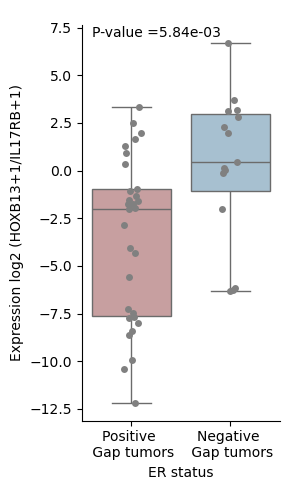

In [21]:
#Figure 6D - ER+ vs - for HOXB13/IL17RB ratio for only gap tumors
Figure6D_tempdf = Figure6C_tempdf.loc[:, Figure6C_tempdf.loc["Status"] == "Gap tumors"]

Figure6D_tempdf.loc["ER status"] = "NaN"
Figure6D_tempdf.loc["ER status", (set(Figure6D_tempdf.columns) & set(TCGA_BRCA_ERpos_participants))] = "Positive \n Gap tumors"
Figure6D_tempdf.loc["ER status", set(Figure6D_tempdf.columns) & set(TCGA_BRCA_ERneg_participants)] = "Negative \n Gap tumors"

#dropping those with no ER IHC listed
Figure6D_tempdf = Figure6D_tempdf.loc[:, (Figure6D_tempdf.loc["ER status"] == "Positive \n Gap tumors") | (Figure6D_tempdf.loc["ER status"] == "Negative \n Gap tumors")]

fig, ax = plt.subplots(1, 1, figsize=(3, 5))
figure6D_palette = ["#CE989A", "#A0C2D7"]
sns.boxplot(palette = figure6D_palette, y = Figure6D_tempdf.loc["log2 HOXB13/IL17RB"], x = Figure6D_tempdf.loc["ER status"])
sns.stripplot(color = "grey", y = Figure6D_tempdf.loc["log2 HOXB13/IL17RB"], x = Figure6D_tempdf.loc["ER status"])

ax.text(-0.4, 7, '\nP-value ='  + str("{:.2e}".format(mannwhitneyu(list(Figure6D_tempdf.loc["log2 HOXB13/IL17RB", (Figure6D_tempdf.loc["ER status"] == "Positive \n Gap tumors")]), list(Figure6D_tempdf.loc["log2 HOXB13/IL17RB", (Figure6D_tempdf.loc["ER status"] == "Negative \n Gap tumors")]))[1])));

ax.set_ylabel("Expression log2 (HOXB13+1/IL17RB+1)")
plt.savefig('Figures/Figure6D.pdf')

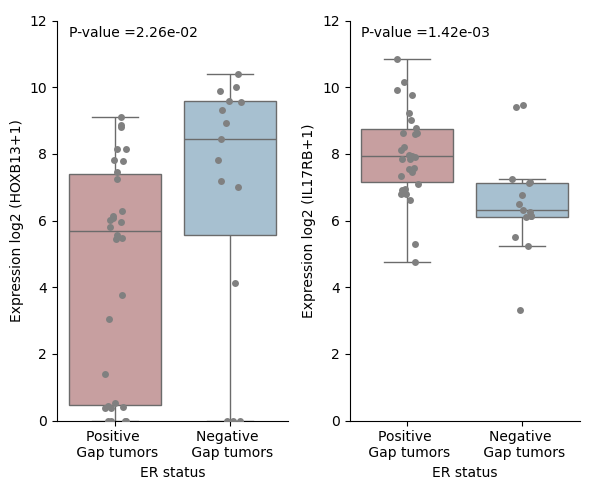

In [22]:
#Figure 6E - ER+ vs - for HOXB13 ratio for only gap tumors

#temp FIGURE 6C
#HOXB13 mRNA for the various groups with ER+/ER- split for each group
#making temporary dataframe to annotate
Figure6E_df = TCGA_BRCA_mRNA_tumor_data.copy()
#adding 1 to HOXB13 to avoid the very small numbers giving large negative values
Figure6E_df.loc["log2 HOXB13"] = np.log2((Figure6E_df.loc["HOXB13"] + 1))

#adding 1 to IL17RB to avoid the very small numbers giving large negative values
Figure6E_df.loc["log2 IL17RB"] = np.log2((Figure6E_df.loc["IL17RB"] + 1))

#making everything a set so operations work
TCGA_BRCA_gap_participants = set(TCGA_BRCA_gap_participants)

Figure6E_df.loc["Status", TCGA_BRCA_gap_participants] = "Gap tumors"

#picking out only gap patients
Figure6E_df = Figure6E_df.loc[:, Figure6E_df.loc["Status"] == "Gap tumors"]

Figure6E_df.loc["ER status"] = "NaN"
Figure6E_df.loc["ER status", (set(Figure6E_df.columns) & set(TCGA_BRCA_ERpos_participants))] = "Positive \n Gap tumors"
Figure6E_df.loc["ER status", set(Figure6E_df.columns) & set(TCGA_BRCA_ERneg_participants)] = "Negative \n Gap tumors"

#dropping those with no ER IHC listed
Figure6E_df = Figure6E_df.loc[:, (Figure6E_df.loc["ER status"] == "Positive \n Gap tumors") | (Figure6E_df.loc["ER status"] == "Negative \n Gap tumors")]

fig, ax = plt.subplots(1, 2, figsize=(6, 5))
figure6D_palette = ["#CE989A", "#A0C2D7"]
sns.boxplot(palette = figure6D_palette, y = Figure6E_df.loc["log2 HOXB13"], x = Figure6E_df.loc["ER status"], ax = ax[0], showfliers = False)
sns.stripplot(color = "grey", y = Figure6E_df.loc["log2 HOXB13"], x = Figure6E_df.loc["ER status"], ax = ax[0])

ax[0].text(-0.4, 11.5, '\nP-value ='  + str("{:.2e}".format(mannwhitneyu(list(Figure6E_df.loc["log2 HOXB13", (Figure6E_df.loc["ER status"] == "Positive \n Gap tumors")]), list(Figure6E_df.loc["log2 HOXB13", (Figure6E_df.loc["ER status"] == "Negative \n Gap tumors")]))[1])));
ax[0].set_ylabel("Expression log2 (HOXB13+1)")
ax[0].set_ylim(0, 12)

sns.boxplot(palette = figure6D_palette, y = Figure6E_df.loc["log2 IL17RB"], x = Figure6E_df.loc["ER status"], ax = ax[1], showfliers = False)
sns.stripplot(color = "grey", y = Figure6E_df.loc["log2 IL17RB"], x = Figure6E_df.loc["ER status"], ax = ax[1])

ax[1].text(-0.4, 11.5, '\nP-value ='  + str("{:.2e}".format(mannwhitneyu(list(Figure6E_df.loc["log2 IL17RB", (Figure6E_df.loc["ER status"] == "Positive \n Gap tumors")]), list(Figure6E_df.loc["log2 IL17RB", (Figure6E_df.loc["ER status"] == "Negative \n Gap tumors")]))[1])));
ax[1].set_ylabel("Expression log2 (IL17RB+1)")
ax[1].set_ylim(0, 12)

plt.savefig('Figures/Figure6E.pdf')

175
33
67


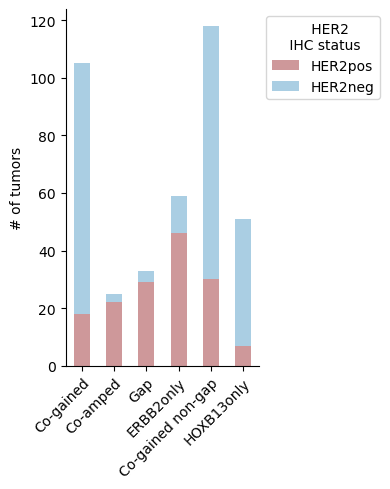

In [23]:
#Supplemental figure 2A split cohorts by HER2 status
#cogained are the 175 from heatmap
#coamped are the 33 from heatmap
#converting to lists for code to work
TCGA_BRCA_ERBB2only_participants = set(TCGA_BRCA_ERBB2only_participants)
TCGA_BRCA_HOXB13only_participants = set(TCGA_BRCA_HOXB13only_participants)
TCGA_BRCA_co_gained_participants = set(TCGA_BRCA_co_gained_participants)
TCGA_BRCA_gap_participants = set(TCGA_BRCA_gap_participants)

temp_cogained_pts = TCGA_BRCA_tumor_copynumber_data.loc[:, TCGA_BRCA_tumor_copynumber_data.loc['ERBB2'] == 1 ].columns & TCGA_BRCA_tumor_copynumber_data.loc[:, TCGA_BRCA_tumor_copynumber_data.loc['HOXB13'] == 1].columns
temp_coamped_pts = TCGA_BRCA_tumor_copynumber_data.loc[:, TCGA_BRCA_tumor_copynumber_data.loc['ERBB2'] == 2 ].columns & TCGA_BRCA_tumor_copynumber_data.loc[:, TCGA_BRCA_tumor_copynumber_data.loc['HOXB13'] == 2].columns

#QC
print(len(temp_cogained_pts))
print(len(temp_coamped_pts))
print(len(TCGA_BRCA_HOXB13only_participants))

supp_fig5_df = pd.DataFrame(columns = ["HER2pos", "HER2neg"])
supp_fig5_df.loc["Co-gained"] = [len(temp_cogained_pts & set(TCGA_BRCA_HERpos_participants)), len(temp_cogained_pts & set(TCGA_BRCA_HERneg_participants))]
supp_fig5_df.loc["Co-amped"] = [len(temp_coamped_pts & set(TCGA_BRCA_HERpos_participants)), len(temp_coamped_pts & set(TCGA_BRCA_HERneg_participants))]
supp_fig5_df.loc["Gap"] = [len(TCGA_BRCA_gap_participants & set(TCGA_BRCA_HERpos_participants)), len(TCGA_BRCA_gap_participants & set(TCGA_BRCA_HERneg_participants))]
supp_fig5_df.loc["ERBB2only"] = [len(TCGA_BRCA_ERBB2only_participants & set(TCGA_BRCA_HERpos_participants)), len(TCGA_BRCA_ERBB2only_participants & set(TCGA_BRCA_HERneg_participants))]
supp_fig5_df.loc["Co-gained non-gap"] = [len(TCGA_BRCA_co_gained_participants & set(TCGA_BRCA_HERpos_participants)), len(TCGA_BRCA_co_gained_participants & set(TCGA_BRCA_HERneg_participants))]
supp_fig5_df.loc["HOXB13only"] = [len(TCGA_BRCA_HOXB13only_participants & set(TCGA_BRCA_HERpos_participants)), len(TCGA_BRCA_HOXB13only_participants & set(TCGA_BRCA_HERneg_participants))]

fig, ax = plt.subplots(1, 1, figsize=(4, 5))

supp_fig5_df.plot(kind='bar', stacked=True, ax = ax, color=["#CE989A", "#AACEE3"])
ax.set_ylabel('# of tumors')
ax.tick_params(axis='x', labelrotation = 45)
ax.legend(bbox_to_anchor=(1.0, 1.0), title="      HER2 \n IHC status")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

plt.savefig('Figures/Supplemental_Figure2A.pdf')


ERBB2 Chi squared p value: 3.198520948501472e-36
HOXB13 Chi squared p value: 0.00029496094670980553


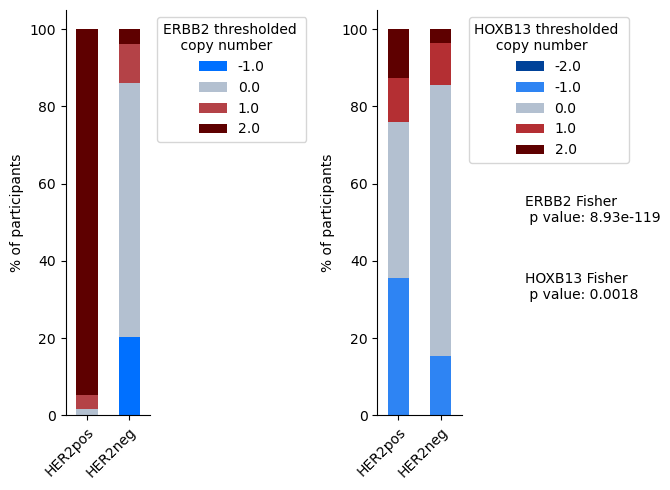

In [24]:
#Supplemental Figure 2B and C
#redoing previous figure but with METABRIC data
#moving around the METABRIC data
segmented_METABRIC_copynumber_data  = METABRIC_copynumber_data.copy()
segmented_METABRIC_copynumber_data_HOXB13 = pd.DataFrame(segmented_METABRIC_copynumber_data.loc["HOXB13"])
segmented_METABRIC_copynumber_data_HOXB13.columns = ["Copy number"]
segmented_METABRIC_copynumber_data_HOXB13["Gene name"] = "HOXB13"
segmented_METABRIC_copynumber_data_HOXB13.loc[METABRIC_HER2pos_participants, "HER2 status"] = "Pos"
segmented_METABRIC_copynumber_data_HOXB13.loc[METABRIC_HER2neg_participants, "HER2 status"] = "Neg"

segmented_METABRIC_copynumber_data_ERBB2 = pd.DataFrame(segmented_METABRIC_copynumber_data.loc["ERBB2"])
segmented_METABRIC_copynumber_data_ERBB2.columns = ["Copy number"]
segmented_METABRIC_copynumber_data_ERBB2["Gene name"] = "ERBB2"
segmented_METABRIC_copynumber_data_ERBB2.loc[METABRIC_HER2pos_participants, "HER2 status"] = "Pos"
segmented_METABRIC_copynumber_data_ERBB2.loc[METABRIC_HER2neg_participants, "HER2 status"] = "Neg"

ERBB2_palette = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#0070FF","#B3C0D0", "#B3C0D0", "#B40303", "#5E0000"])
HOXB13_palette = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#004299", "#0070FF", "#B3C0D0", "#B3C0D0", "#B40303", "#5E0000"])


suppfig1tempdf_ERBB2 = segmented_METABRIC_copynumber_data_ERBB2.copy()
suppfig1tempdf_HOXB13 = segmented_METABRIC_copynumber_data_HOXB13.copy()
        
fig, ax = plt.subplots(1, 2, figsize=(7, 5))
plt.rcParams['pdf.fonttype'] = 42
suppfig1temp_HER2pos_ERBB2 = pd.DataFrame(suppfig1tempdf_ERBB2.loc[suppfig1tempdf_ERBB2.loc[:, "HER2 status"] == "Pos"].loc[:, "Copy number"].value_counts())
suppfig1temp_HER2pos_ERBB2.columns = ["HER2pos"]
#for statistics later
notpercent_suppfig1temp_HER2pos_ERBB2 = suppfig1temp_HER2pos_ERBB2.copy()
#making everything fractions
suppfig1temp_HER2pos_ERBB2["HER2pos"] = suppfig1temp_HER2pos_ERBB2["HER2pos"]/sum(suppfig1temp_HER2pos_ERBB2["HER2pos"])
suppfig1temp_HER2neg_ERBB2 = pd.DataFrame(suppfig1tempdf_ERBB2.loc[suppfig1tempdf_ERBB2.loc[:, "HER2 status"] == "Neg"].loc[:, "Copy number"].value_counts())
suppfig1temp_HER2neg_ERBB2.columns = ["HER2neg"]
#for statistics later
notpercent_suppfig1temp_HER2neg_ERBB2 = suppfig1temp_HER2neg_ERBB2.copy()
suppfig1temp_HER2neg_ERBB2["HER2neg"] = suppfig1temp_HER2neg_ERBB2["HER2neg"]/sum(suppfig1temp_HER2neg_ERBB2["HER2neg"])
final_suppfig1tempdf_ERBB2 = pd.concat([suppfig1temp_HER2pos_ERBB2, suppfig1temp_HER2neg_ERBB2], axis = 1).transpose()

#removing the participants in the middle for the figure since they are so few it doesn't impact the graphics
final_suppfig1tempdf_ERBB2 = final_suppfig1tempdf_ERBB2[[-1,0,1,2]]
final_suppfig1tempdf_ERBB2 = final_suppfig1tempdf_ERBB2*100
final_suppfig1tempdf_ERBB2.plot(kind='bar', stacked=True, ax = ax[0], colormap = ERBB2_palette)
ax[0].set_ylabel('% of participants')
ax[0].tick_params(axis='x', labelrotation = 45)
ax[0].legend(bbox_to_anchor=(1.0, 1.0), title="ERBB2 thresholded \n    copy number")


suppfig1temp_HER2pos_HOXB13 = pd.DataFrame(suppfig1tempdf_HOXB13.loc[suppfig1tempdf_HOXB13.loc[:, "HER2 status"] == "Pos"].loc[:, "Copy number"].value_counts())
suppfig1temp_HER2pos_HOXB13.columns = ["HER2pos"]
#for statistics later
notpercent_suppfig1temp_HER2pos_HOXB13 = suppfig1temp_HER2pos_HOXB13.copy()
#making everything fractions
suppfig1temp_HER2pos_HOXB13["HER2pos"] = suppfig1temp_HER2pos_HOXB13["HER2pos"]/sum(suppfig1temp_HER2pos_HOXB13["HER2pos"])
suppfig1temp_HER2neg_HOXB13 = pd.DataFrame(suppfig1tempdf_HOXB13.loc[suppfig1tempdf_HOXB13.loc[:, "HER2 status"] == "Neg"].loc[:, "Copy number"].value_counts())
suppfig1temp_HER2neg_HOXB13.columns = ["HER2neg"]
#for statistics later
notpercent_suppfig1temp_HER2neg_HOXB13 = suppfig1temp_HER2neg_HOXB13.copy()
suppfig1temp_HER2neg_HOXB13["HER2neg"] = suppfig1temp_HER2neg_HOXB13["HER2neg"]/sum(suppfig1temp_HER2neg_HOXB13["HER2neg"])
final_suppfig1tempdf_HOXB13 = pd.concat([suppfig1temp_HER2pos_HOXB13, suppfig1temp_HER2neg_HOXB13], axis = 1).transpose()

#removing the participants in the middle for the figure since they are so few it doesn't impact the graphics
final_suppfig1tempdf_HOXB13 = final_suppfig1tempdf_HOXB13[[-2,-1,0,1,2]]
final_suppfig1tempdf_HOXB13 = final_suppfig1tempdf_HOXB13*100
final_suppfig1tempdf_HOXB13.plot(kind='bar', stacked=True, ax = ax[1], colormap = HOXB13_palette)
ax[1].set_ylabel('% of participants')
ax[1].tick_params(axis='x', labelrotation = 45)
ax[1].legend(bbox_to_anchor=(1.0, 1.0), title="HOXB13 thresholded \n     copy number")

#p values
final_suppfig1tempdf_ERBB2 = final_suppfig1tempdf_ERBB2.fillna(0)
stat, p, dof, expected = chi2_contingency(final_suppfig1tempdf_ERBB2)
print("ERBB2 Chi squared p value:", str(p))
final_suppfig1tempdf_HOXB13 = final_suppfig1tempdf_HOXB13.fillna(0)
stat, p, dof, expected = chi2_contingency(final_suppfig1tempdf_HOXB13)
print("HOXB13 Chi squared p value:", str(p))

#fisher tables
suppFig1_ERBB2fisherdf = pd.DataFrame()
suppFig1_ERBB2fisherdf.loc["not gained", "HER2+"] = 3
suppFig1_ERBB2fisherdf.loc["gained", "HER2+"] = 166+6
suppFig1_ERBB2fisherdf.loc["not gained", "HER2-"] = 813+248
suppFig1_ERBB2fisherdf.loc["gained", "HER2-"] = 122+48
plt.text(3, 50, "ERBB2 Fisher \n p value: " + str("{:.3}".format(fisher_exact(suppFig1_ERBB2fisherdf, alternative='two-sided')[1])))

suppFig1_HOXB13fisherdf = pd.DataFrame()
suppFig1_HOXB13fisherdf.loc["not gained", "HER2+"] = 71+62
suppFig1_HOXB13fisherdf.loc["gained", "HER2+"] = 22+20
suppFig1_HOXB13fisherdf.loc["not gained", "HER2-"] = 1+187+865
suppFig1_HOXB13fisherdf.loc["gained", "HER2-"] = 134+44
plt.text(3, 30, "HOXB13 Fisher \n p value: " + str("{:.3}".format(fisher_exact(suppFig1_HOXB13fisherdf, alternative='two-sided')[1])))

ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

plt.savefig('Figures/Supplemental_Figure2BC.pdf')


SignificanceResult(statistic=10.734818193177558, pvalue=8.550824959479716e-77)

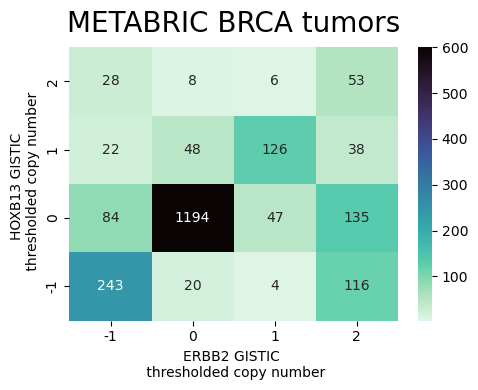

In [25]:
#SUPPLEMENTAL FIGURE 2D
#repeating heatmaps for METABRIC
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
temp_df_erb0 = METABRIC_copynumber_data.loc[:, METABRIC_copynumber_data.loc['ERBB2'] == 0].columns
temp_df_erbneg1 = METABRIC_copynumber_data.loc[:, METABRIC_copynumber_data.loc['ERBB2'] == -1].columns
temp_df_erb1 = METABRIC_copynumber_data.loc[:, METABRIC_copynumber_data.loc['ERBB2'] == 1].columns
temp_df_erb2 = METABRIC_copynumber_data.loc[:, METABRIC_copynumber_data.loc['ERBB2'] == 2].columns

temp_fulldfheatmap = pd.DataFrame(data = METABRIC_copynumber_data.loc['HOXB13', temp_df_erb0].value_counts())
temp_fulldfheatmap.columns = ["ERBB2=0"]
temp_fulldfheatmap["ERBB2=1"] = METABRIC_copynumber_data.loc['HOXB13', temp_df_erb1].value_counts()
temp_fulldfheatmap["ERBB2=-1"] = METABRIC_copynumber_data.loc['HOXB13', temp_df_erbneg1].value_counts()
temp_fulldfheatmap["ERBB2=2"] = METABRIC_copynumber_data.loc['HOXB13', temp_df_erb2].value_counts()
temp_fulldfheatmap.index = ["HOXB13=0", "HOXB13=1", "HOXB13=-1", "HOXB13=2"]
temp_fulldfheatmap = temp_fulldfheatmap.loc[["HOXB13=2", "HOXB13=1", "HOXB13=0", "HOXB13=-1"]]
temp_fulldfheatmap = temp_fulldfheatmap[["ERBB2=-1", "ERBB2=0", "ERBB2=1", "ERBB2=2"]]

#changing the labels for the heatmap plot
METABRIC_fulldfheatmap_zerolabels = temp_fulldfheatmap.copy()
METABRIC_fulldfheatmap_zerolabels.index = [2, 1, 0, -1]
METABRIC_fulldfheatmap_zerolabels.columns = [-1, 0, 1, 2]
sns.heatmap(data = METABRIC_fulldfheatmap_zerolabels, annot = True, cmap='mako_r', fmt=".0f", ax = ax, vmax = 600)
ax.set_title("METABRIC BRCA tumors", y = 1.025, size = 20)
ax.set_ylabel('HOXB13 GISTIC \n thresholded copy number')
ax.set_xlabel('ERBB2 GISTIC \n thresholded copy number')
plt.savefig('Figures/Supplemental_Figure2D.pdf')

statistics_df2 = pd.DataFrame()
statistics_df2.loc["HOXB13 not gained", "ERBB2 not gained"] = 84+1194+243+20
statistics_df2.loc["HOXB13 gained", "ERBB2 not gained"] = 22+28+48+8
statistics_df2.loc["HOXB13 not gained", "ERBB2 gained"] = 47+135+4+116
statistics_df2.loc["HOXB13 gained", "ERBB2 gained"] = 6+53+126+38

fisher_exact(statistics_df2, alternative='two-sided')

126
53
106


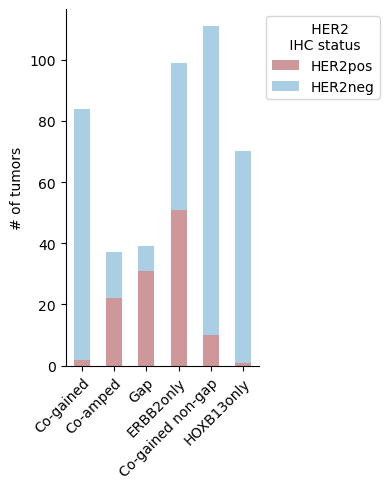

In [26]:
#Supplemental figure 2E split cohorts by HER2 status
#same but for METABRIC now

temp_cogained_pts = METABRIC_copynumber_data.loc[:, METABRIC_copynumber_data.loc['ERBB2'] == 1 ].columns & METABRIC_copynumber_data.loc[:, METABRIC_copynumber_data.loc['HOXB13'] == 1].columns
temp_coamped_pts = METABRIC_copynumber_data.loc[:, METABRIC_copynumber_data.loc['ERBB2'] == 2 ].columns & METABRIC_copynumber_data.loc[:, METABRIC_copynumber_data.loc['HOXB13'] == 2].columns

#QC
print(len(temp_cogained_pts))
print(len(temp_coamped_pts))
print(len(METABRIC_HOXB13only_participants))

METABRIC_supp_fig5_df = pd.DataFrame(columns = ["HER2pos", "HER2neg"])
METABRIC_supp_fig5_df.loc["Co-gained"] = [len(temp_cogained_pts & set(METABRIC_HER2pos_participants)), len(temp_cogained_pts & set(METABRIC_HER2neg_participants))]
METABRIC_supp_fig5_df.loc["Co-amped"] = [len(temp_coamped_pts & set(METABRIC_HER2pos_participants)), len(temp_coamped_pts & set(METABRIC_HER2neg_participants))]
METABRIC_supp_fig5_df.loc["Gap"] = [len(METABRIC_gap_participants & set(METABRIC_HER2pos_participants)), len(METABRIC_gap_participants & set(METABRIC_HER2neg_participants))]
METABRIC_supp_fig5_df.loc["ERBB2only"] = [len(METABRIC_ERBB2amped_participants & set(METABRIC_HER2pos_participants)), len(METABRIC_ERBB2amped_participants & set(METABRIC_HER2neg_participants))]
METABRIC_supp_fig5_df.loc["Co-gained non-gap"] = [len(METABRIC_coamp_participants & set(METABRIC_HER2pos_participants)), len(METABRIC_coamp_participants & set(METABRIC_HER2neg_participants))]
METABRIC_supp_fig5_df.loc["HOXB13only"] = [len(METABRIC_HOXB13only_participants & set(METABRIC_HER2pos_participants)), len(METABRIC_HOXB13only_participants & set(METABRIC_HER2neg_participants))]

fig, ax = plt.subplots(1, 1, figsize=(4, 5))

METABRIC_supp_fig5_df.plot(kind='bar', stacked=True, ax = ax, color=["#CE989A", "#AACEE3"])
ax.set_ylabel('# of tumors')
ax.tick_params(axis='x', labelrotation = 45)
ax.legend(bbox_to_anchor=(1.0, 1.0), title="      HER2 \n IHC status")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

plt.savefig('Figures/Supplemental_Figure2E.pdf')

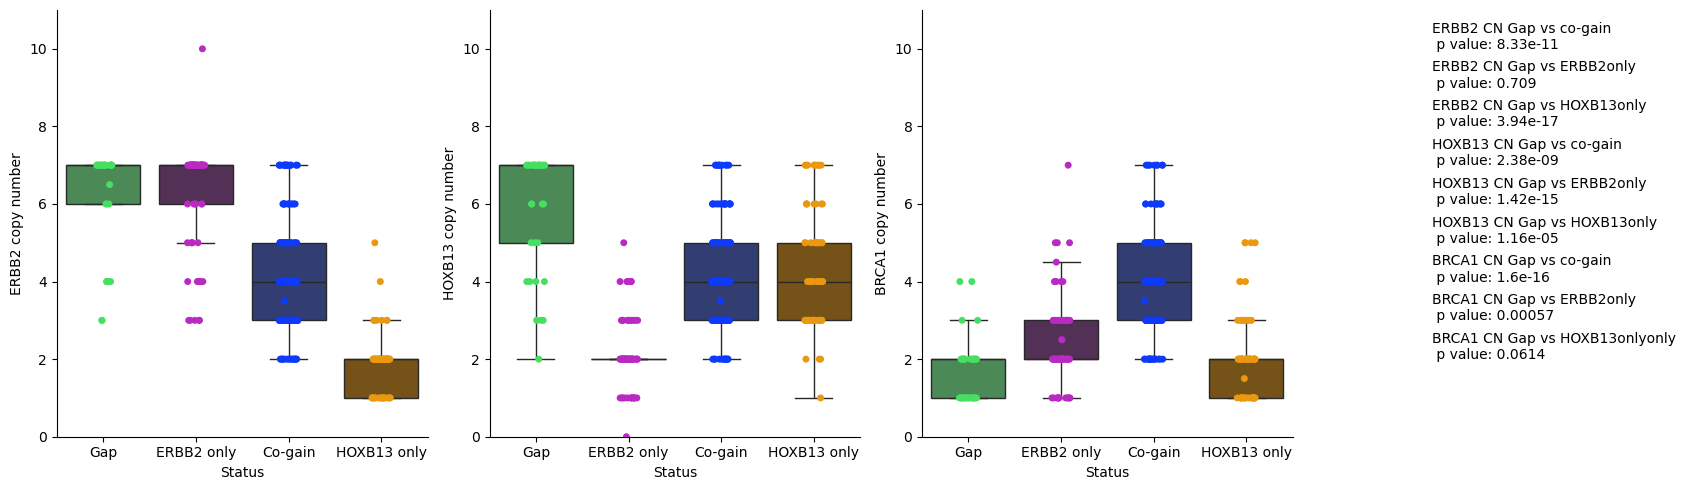

In [27]:
#Supplemental Figure 3A 

#fixing some variable type issues
TCGA_BRCA_ERBB2only_participants = list(TCGA_BRCA_ERBB2only_participants)
TCGA_BRCA_HOXB13only_participants = list(TCGA_BRCA_HOXB13only_participants)
TCGA_BRCA_co_gained_participants = list(TCGA_BRCA_co_gained_participants)
TCGA_BRCA_gap_participants = list(TCGA_BRCA_gap_participants)

TCGA_BRCA_callsboth_HOXB13andERBB2 = TCGA_BRCA_callsonlyHOXB13.copy()
TCGA_BRCA_callsboth_HOXB13andERBB2["ERBB2 copy number"] = TCGA_BRCA_callsonlyERBB2["Copy number"]
TCGA_BRCA_callsboth_HOXB13andERBB2.columns = ['HOXB13 copy number', 'Segment_length', 'Gene name', 'ER status',
       'HER2 status', 'HOXB13 mRNA', 'log10 segment length', 'Thresholded calls',
       'ERBB2 copy number']

#making everything a list so the selection works
TCGA_BRCA_gap_participants = list(TCGA_BRCA_gap_participants)
TCGA_BRCA_ERBB2only_participants = list(TCGA_BRCA_ERBB2only_participants)
TCGA_BRCA_co_gained_participants = list(TCGA_BRCA_co_gained_participants)

TCGA_BRCA_callsboth_HOXB13andERBB2.loc[np.in1d(TCGA_BRCA_callsboth_HOXB13andERBB2.index, TCGA_BRCA_gap_participants), "Status"] = "Gap"
TCGA_BRCA_callsboth_HOXB13andERBB2.loc[np.in1d(TCGA_BRCA_callsboth_HOXB13andERBB2.index, TCGA_BRCA_ERBB2only_participants), "Status"] = "ERBB2 only"
TCGA_BRCA_callsboth_HOXB13andERBB2.loc[np.in1d(TCGA_BRCA_callsboth_HOXB13andERBB2.index, TCGA_BRCA_co_gained_participants), "Status"] = "Co-gain"
TCGA_BRCA_callsboth_HOXB13andERBB2.loc[np.in1d(TCGA_BRCA_callsboth_HOXB13andERBB2.index, TCGA_BRCA_HOXB13only_participants), "Status"] = "HOXB13 only"

tempdfgapppl = TCGA_BRCA_callsboth_HOXB13andERBB2.loc[TCGA_BRCA_callsboth_HOXB13andERBB2["Status"] == "Gap"].index
tempdferbb2ppl = TCGA_BRCA_callsboth_HOXB13andERBB2.loc[TCGA_BRCA_callsboth_HOXB13andERBB2["Status"] == "ERBB2 only"].index
tempdfcoppl = TCGA_BRCA_callsboth_HOXB13andERBB2.loc[TCGA_BRCA_callsboth_HOXB13andERBB2["Status"] == "Co-gain"].index
tempdfhoxb13ppl = TCGA_BRCA_callsboth_HOXB13andERBB2.loc[TCGA_BRCA_callsboth_HOXB13andERBB2["Status"] == "HOXB13 only"].index
TCGA_BRCA_callsall3 = TCGA_BRCA_callsboth_HOXB13andERBB2.copy()
TCGA_BRCA_callsall3 = TCGA_BRCA_callsall3.dropna(how = "any")
TCGA_BRCA_callsall3 = TCGA_BRCA_callsall3[["HOXB13 copy number", "ERBB2 copy number", "Status"]]
TCGA_BRCA_callsall3["BRCA1 copy number"] = TCGA_BRCA_callsonlyBRCA1["Copy number"]
mannwhitneyu(TCGA_BRCA_callsboth_HOXB13andERBB2.loc[np.in1d(TCGA_BRCA_callsboth_HOXB13andERBB2.index, TCGA_BRCA_gap_participants), "ERBB2 copy number"].dropna(), TCGA_BRCA_callsboth_HOXB13andERBB2.loc[np.in1d(TCGA_BRCA_callsboth_HOXB13andERBB2.index, TCGA_BRCA_ERBB2only_participants), "ERBB2 copy number"].dropna())


fig, ax = plt.subplots(1, 3, figsize=(17, 5))

boxplot_palette = ["#419450", "#592A5C", "#28387C", "#855607"]
stripplot_palette = ["#46df61", "#b92ac3", "#0d3afc", "#e99810"]
sns.boxplot(y=TCGA_BRCA_callsall3['ERBB2 copy number'], x=TCGA_BRCA_callsall3['Status'], order = ["Gap", "ERBB2 only", "Co-gain", "HOXB13 only"], palette=boxplot_palette, ax = ax[0], showfliers = False)
sns.stripplot(y=TCGA_BRCA_callsall3['ERBB2 copy number'], x=TCGA_BRCA_callsall3['Status'], order = ["Gap", "ERBB2 only", "Co-gain", "HOXB13 only"], palette=stripplot_palette, ax = ax[0])
sns.boxplot(y=TCGA_BRCA_callsall3['HOXB13 copy number'], x=TCGA_BRCA_callsall3['Status'], order = ["Gap", "ERBB2 only", "Co-gain", "HOXB13 only"], palette=boxplot_palette, ax = ax[1], showfliers = False)
sns.stripplot(y=TCGA_BRCA_callsall3['HOXB13 copy number'], x=TCGA_BRCA_callsall3['Status'], order = ["Gap", "ERBB2 only", "Co-gain", "HOXB13 only"], palette=stripplot_palette, ax = ax[1])
sns.boxplot(y=TCGA_BRCA_callsall3['BRCA1 copy number'], x=TCGA_BRCA_callsall3['Status'], order = ["Gap", "ERBB2 only", "Co-gain", "HOXB13 only"], palette=boxplot_palette, ax = ax[2], showfliers = False)
sns.stripplot(y=TCGA_BRCA_callsall3['BRCA1 copy number'], x=TCGA_BRCA_callsall3['Status'], order = ["Gap", "ERBB2 only", "Co-gain", "HOXB13 only"], palette=stripplot_palette, ax = ax[2])

ax[0].set_ylim(0,11)
ax[1].set_ylim(0,11)
ax[2].set_ylim(0,11)

tempdfgapppl = TCGA_BRCA_callsall3.loc[TCGA_BRCA_callsall3["Status"] == "Gap"].index
tempdferbb2ppl = TCGA_BRCA_callsall3.loc[TCGA_BRCA_callsall3["Status"] == "ERBB2 only"].index
tempdfcoppl = TCGA_BRCA_callsall3.loc[TCGA_BRCA_callsall3["Status"] == "Co-gain"].index
tempdfhoxb13onlyppl = TCGA_BRCA_callsall3.loc[TCGA_BRCA_callsall3["Status"] == "HOXB13 only"].index

p = mannwhitneyu(TCGA_BRCA_callsall3.loc[tempdfgapppl, 'ERBB2 copy number'].dropna(), TCGA_BRCA_callsall3.loc[tempdfcoppl, 'ERBB2 copy number'].dropna())
plt.text(5, 10, "ERBB2 CN Gap vs co-gain \n p value: " + str("{:.3}".format(p[1])))
p = mannwhitneyu(TCGA_BRCA_callsall3.loc[tempdfgapppl, 'ERBB2 copy number'].dropna(), TCGA_BRCA_callsall3.loc[tempdferbb2ppl, 'ERBB2 copy number'].dropna())
plt.text(5, 9, "ERBB2 CN Gap vs ERBB2only \n p value: " + str("{:.3}".format(p[1])))
p = mannwhitneyu(TCGA_BRCA_callsall3.loc[tempdfgapppl, 'ERBB2 copy number'].dropna(), TCGA_BRCA_callsall3.loc[tempdfhoxb13onlyppl, 'ERBB2 copy number'].dropna())
plt.text(5, 8, "ERBB2 CN Gap vs HOXB13only \n p value: " + str("{:.3}".format(p[1])))


p = mannwhitneyu(TCGA_BRCA_callsall3.loc[tempdfgapppl, 'HOXB13 copy number'].dropna(), TCGA_BRCA_callsall3.loc[tempdfcoppl, 'HOXB13 copy number'].dropna())
plt.text(5, 7, "HOXB13 CN Gap vs co-gain \n p value: " + str("{:.3}".format(p[1])))
p = mannwhitneyu(TCGA_BRCA_callsall3.loc[tempdfgapppl, 'HOXB13 copy number'].dropna(), TCGA_BRCA_callsall3.loc[tempdferbb2ppl, 'HOXB13 copy number'].dropna())
plt.text(5, 6, "HOXB13 CN Gap vs ERBB2only \n p value: " + str("{:.3}".format(p[1])))
p = mannwhitneyu(TCGA_BRCA_callsall3.loc[tempdfgapppl, 'HOXB13 copy number'].dropna(), TCGA_BRCA_callsall3.loc[tempdfhoxb13onlyppl, 'HOXB13 copy number'].dropna())
plt.text(5, 5, "HOXB13 CN Gap vs HOXB13only \n p value: " + str("{:.3}".format(p[1])))


p = mannwhitneyu(TCGA_BRCA_callsall3.loc[tempdfgapppl, 'BRCA1 copy number'].dropna(), TCGA_BRCA_callsall3.loc[tempdfcoppl, 'BRCA1 copy number'].dropna())
plt.text(5, 4, "BRCA1 CN Gap vs co-gain \n p value: " + str("{:.3}".format(p[1])))
p = mannwhitneyu(TCGA_BRCA_callsall3.loc[tempdfgapppl, 'BRCA1 copy number'].dropna(), TCGA_BRCA_callsall3.loc[tempdferbb2ppl, 'BRCA1 copy number'].dropna())
plt.text(5, 3, "BRCA1 CN Gap vs ERBB2only \n p value: " + str("{:.3}".format(p[1])))
p = mannwhitneyu(TCGA_BRCA_callsall3.loc[tempdfgapppl, 'BRCA1 copy number'].dropna(), TCGA_BRCA_callsall3.loc[tempdfhoxb13onlyppl, 'BRCA1 copy number'].dropna())
plt.text(5, 2, "BRCA1 CN Gap vs HOXB13onlyonly \n p value: " + str("{:.3}".format(p[1])))

plt.savefig('Figures/Supplemental_Figure3A.pdf')

175
33
67
126
53
106


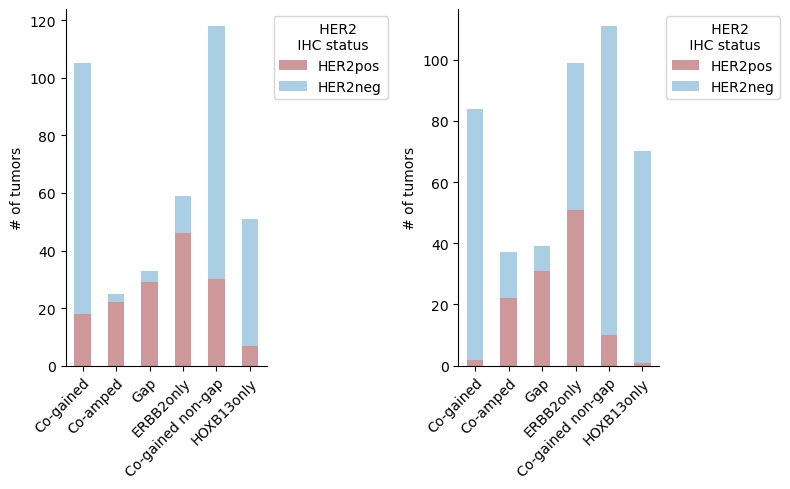

In [28]:
#Supplemental figure 3B split cohorts by HER2 status
#cogained are the 175 from heatmap
#coamped are the 33 from heatmap
#converting to lists for code to work
TCGA_BRCA_ERBB2only_participants = set(TCGA_BRCA_ERBB2only_participants)
TCGA_BRCA_HOXB13only_participants = set(TCGA_BRCA_HOXB13only_participants)
TCGA_BRCA_co_gained_participants = set(TCGA_BRCA_co_gained_participants)
TCGA_BRCA_gap_participants = set(TCGA_BRCA_gap_participants)

temp_cogained_pts = TCGA_BRCA_tumor_copynumber_data.loc[:, TCGA_BRCA_tumor_copynumber_data.loc['ERBB2'] == 1 ].columns & TCGA_BRCA_tumor_copynumber_data.loc[:, TCGA_BRCA_tumor_copynumber_data.loc['HOXB13'] == 1].columns
temp_coamped_pts = TCGA_BRCA_tumor_copynumber_data.loc[:, TCGA_BRCA_tumor_copynumber_data.loc['ERBB2'] == 2 ].columns & TCGA_BRCA_tumor_copynumber_data.loc[:, TCGA_BRCA_tumor_copynumber_data.loc['HOXB13'] == 2].columns

#QC
print(len(temp_cogained_pts))
print(len(temp_coamped_pts))
print(len(TCGA_BRCA_HOXB13only_participants))

supp_fig5_df = pd.DataFrame(columns = ["HER2pos", "HER2neg"])
supp_fig5_df.loc["Co-gained"] = [len(temp_cogained_pts & set(TCGA_BRCA_HERpos_participants)), len(temp_cogained_pts & set(TCGA_BRCA_HERneg_participants))]
supp_fig5_df.loc["Co-amped"] = [len(temp_coamped_pts & set(TCGA_BRCA_HERpos_participants)), len(temp_coamped_pts & set(TCGA_BRCA_HERneg_participants))]
supp_fig5_df.loc["Gap"] = [len(TCGA_BRCA_gap_participants & set(TCGA_BRCA_HERpos_participants)), len(TCGA_BRCA_gap_participants & set(TCGA_BRCA_HERneg_participants))]
supp_fig5_df.loc["ERBB2only"] = [len(TCGA_BRCA_ERBB2only_participants & set(TCGA_BRCA_HERpos_participants)), len(TCGA_BRCA_ERBB2only_participants & set(TCGA_BRCA_HERneg_participants))]
supp_fig5_df.loc["Co-gained non-gap"] = [len(TCGA_BRCA_co_gained_participants & set(TCGA_BRCA_HERpos_participants)), len(TCGA_BRCA_co_gained_participants & set(TCGA_BRCA_HERneg_participants))]
supp_fig5_df.loc["HOXB13only"] = [len(TCGA_BRCA_HOXB13only_participants & set(TCGA_BRCA_HERpos_participants)), len(TCGA_BRCA_HOXB13only_participants & set(TCGA_BRCA_HERneg_participants))]

fig, ax = plt.subplots(1, 2, figsize=(8, 5))

supp_fig5_df.plot(kind='bar', stacked=True, ax = ax[0], color=["#CE989A", "#AACEE3"])
ax[0].set_ylabel('# of tumors')
ax[0].tick_params(axis='x', labelrotation = 45)
ax[0].legend(bbox_to_anchor=(1.0, 1.0), title="      HER2 \n IHC status")
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

#Supplemental figure 3B split cohorts by HER2 status
#same but for METABRIC now

temp_cogained_pts = METABRIC_copynumber_data.loc[:, METABRIC_copynumber_data.loc['ERBB2'] == 1 ].columns & METABRIC_copynumber_data.loc[:, METABRIC_copynumber_data.loc['HOXB13'] == 1].columns
temp_coamped_pts = METABRIC_copynumber_data.loc[:, METABRIC_copynumber_data.loc['ERBB2'] == 2 ].columns & METABRIC_copynumber_data.loc[:, METABRIC_copynumber_data.loc['HOXB13'] == 2].columns

#QC
print(len(temp_cogained_pts))
print(len(temp_coamped_pts))
print(len(METABRIC_HOXB13only_participants))

METABRIC_supp_fig5_df = pd.DataFrame(columns = ["HER2pos", "HER2neg"])
METABRIC_supp_fig5_df.loc["Co-gained"] = [len(temp_cogained_pts & set(METABRIC_HER2pos_participants)), len(temp_cogained_pts & set(METABRIC_HER2neg_participants))]
METABRIC_supp_fig5_df.loc["Co-amped"] = [len(temp_coamped_pts & set(METABRIC_HER2pos_participants)), len(temp_coamped_pts & set(METABRIC_HER2neg_participants))]
METABRIC_supp_fig5_df.loc["Gap"] = [len(METABRIC_gap_participants & set(METABRIC_HER2pos_participants)), len(METABRIC_gap_participants & set(METABRIC_HER2neg_participants))]
METABRIC_supp_fig5_df.loc["ERBB2only"] = [len(METABRIC_ERBB2amped_participants & set(METABRIC_HER2pos_participants)), len(METABRIC_ERBB2amped_participants & set(METABRIC_HER2neg_participants))]
METABRIC_supp_fig5_df.loc["Co-gained non-gap"] = [len(METABRIC_coamp_participants & set(METABRIC_HER2pos_participants)), len(METABRIC_coamp_participants & set(METABRIC_HER2neg_participants))]
METABRIC_supp_fig5_df.loc["HOXB13only"] = [len(METABRIC_HOXB13only_participants & set(METABRIC_HER2pos_participants)), len(METABRIC_HOXB13only_participants & set(METABRIC_HER2neg_participants))]

METABRIC_supp_fig5_df.plot(kind='bar', stacked=True, ax = ax[1], color=["#CE989A", "#AACEE3"])
ax[1].set_ylabel('# of tumors')
ax[1].tick_params(axis='x', labelrotation = 45)
ax[1].legend(bbox_to_anchor=(1.0, 1.0), title="      HER2 \n IHC status")
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

plt.savefig('Figures/Supplemental_Figure3B.pdf')


175
33
67
126
53
106


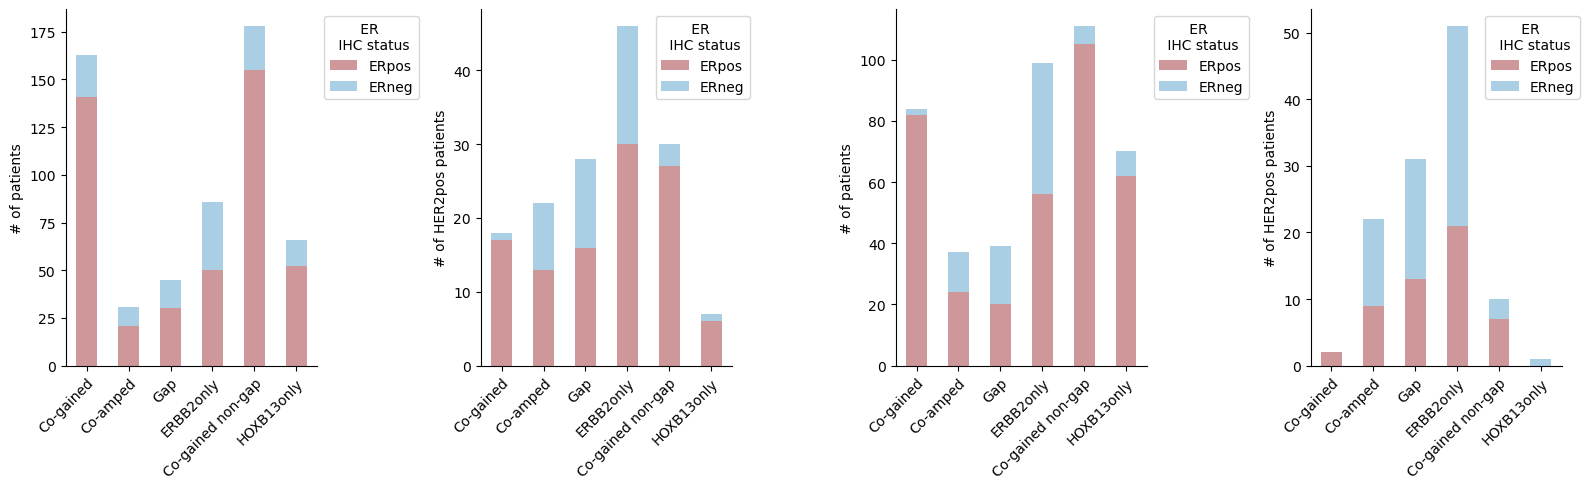

In [29]:
#Supplemental Figure 3C

#making everything a set so operations work
TCGA_BRCA_ERBB2only_participants = set(TCGA_BRCA_ERBB2only_participants)
TCGA_BRCA_ERpos_participants = set(TCGA_BRCA_ERpos_participants)
TCGA_BRCA_ERneg_participants = set(TCGA_BRCA_ERneg_participants)
TCGA_BRCA_gap_participants = set(TCGA_BRCA_gap_participants)
TCGA_BRCA_co_gained_participants = set(TCGA_BRCA_co_gained_participants)
TCGA_BRCA_HOXB13only_participants = set(TCGA_BRCA_HOXB13only_participants)

#Supplemental figure split cohorts by ER status
#cogained are the 175 from heatmap
#coamped are the 33 from heatmap
temp_cogained_pts = TCGA_BRCA_tumor_copynumber_data.loc[:, TCGA_BRCA_tumor_copynumber_data.loc['ERBB2'] == 1 ].columns & TCGA_BRCA_tumor_copynumber_data.loc[:, TCGA_BRCA_tumor_copynumber_data.loc['HOXB13'] == 1].columns
temp_coamped_pts = TCGA_BRCA_tumor_copynumber_data.loc[:, TCGA_BRCA_tumor_copynumber_data.loc['ERBB2'] == 2 ].columns & TCGA_BRCA_tumor_copynumber_data.loc[:, TCGA_BRCA_tumor_copynumber_data.loc['HOXB13'] == 2].columns

#QC
print(len(temp_cogained_pts))
print(len(temp_coamped_pts))
print(len(TCGA_BRCA_HOXB13only_participants))

supp_fig5_df = pd.DataFrame(columns = ["ERpos", "ERneg"])
supp_fig5_df.loc["Co-gained"] = [len(temp_cogained_pts & set(TCGA_BRCA_ERpos_participants)), len(temp_cogained_pts & set(TCGA_BRCA_ERneg_participants))]
supp_fig5_df.loc["Co-amped"] = [len(temp_coamped_pts & set(TCGA_BRCA_ERpos_participants)), len(temp_coamped_pts & set(TCGA_BRCA_ERneg_participants))]
supp_fig5_df.loc["Gap"] = [len(TCGA_BRCA_gap_participants & set(TCGA_BRCA_ERpos_participants)), len(TCGA_BRCA_gap_participants & set(TCGA_BRCA_ERneg_participants))]
supp_fig5_df.loc["ERBB2only"] = [len(TCGA_BRCA_ERBB2only_participants & set(TCGA_BRCA_ERpos_participants)), len(TCGA_BRCA_ERBB2only_participants & set(TCGA_BRCA_ERneg_participants))]
supp_fig5_df.loc["Co-gained non-gap"] = [len(TCGA_BRCA_co_gained_participants & set(TCGA_BRCA_ERpos_participants)), len(TCGA_BRCA_co_gained_participants & set(TCGA_BRCA_ERneg_participants))]
supp_fig5_df.loc["HOXB13only"] = [len(TCGA_BRCA_HOXB13only_participants & set(TCGA_BRCA_ERpos_participants)), len(TCGA_BRCA_HOXB13only_participants & set(TCGA_BRCA_ERneg_participants))]


fig, ax = plt.subplots(1, 4, figsize=(16, 5))

supp_fig5_df.plot(kind='bar', stacked=True, ax = ax[0], color=["#CE989A", "#AACEE3"])
ax[0].set_ylabel('# of patients')
ax[0].tick_params(axis='x', labelrotation = 45)
ax[0].legend(bbox_to_anchor=(1.0, 1.0), title="      ER \n IHC status")
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')


#redoing it again to only inckude % of HER2pos patients
supp_fig5_df_HER2pos = pd.DataFrame(columns = ["ERpos", "ERneg"])
supp_fig5_df_HER2pos.loc["Co-gained"] = [len(temp_cogained_pts & set(TCGA_BRCA_ERpos_participants) & set(TCGA_BRCA_HERpos_participants)), len(temp_cogained_pts & set(TCGA_BRCA_ERneg_participants) & set(TCGA_BRCA_HERpos_participants))]
supp_fig5_df_HER2pos.loc["Co-amped"] = [len(temp_coamped_pts & set(TCGA_BRCA_ERpos_participants) & set(TCGA_BRCA_HERpos_participants)), len(temp_coamped_pts & set(TCGA_BRCA_ERneg_participants) & set(TCGA_BRCA_HERpos_participants))]
supp_fig5_df_HER2pos.loc["Gap"] = [len(TCGA_BRCA_gap_participants & set(TCGA_BRCA_ERpos_participants) & set(TCGA_BRCA_HERpos_participants)), len(TCGA_BRCA_gap_participants & set(TCGA_BRCA_ERneg_participants) & set(TCGA_BRCA_HERpos_participants))]
supp_fig5_df_HER2pos.loc["ERBB2only"] = [len(TCGA_BRCA_ERBB2only_participants & set(TCGA_BRCA_ERpos_participants) & set(TCGA_BRCA_HERpos_participants)), len(TCGA_BRCA_ERBB2only_participants & set(TCGA_BRCA_ERneg_participants) & set(TCGA_BRCA_HERpos_participants))]
supp_fig5_df_HER2pos.loc["Co-gained non-gap"] = [len(TCGA_BRCA_co_gained_participants & set(TCGA_BRCA_ERpos_participants) & set(TCGA_BRCA_HERpos_participants)), len(TCGA_BRCA_co_gained_participants & set(TCGA_BRCA_ERneg_participants) & set(TCGA_BRCA_HERpos_participants))]
supp_fig5_df_HER2pos.loc["HOXB13only"] = [len(TCGA_BRCA_HOXB13only_participants & set(TCGA_BRCA_ERpos_participants) & set(TCGA_BRCA_HERpos_participants)), len(TCGA_BRCA_HOXB13only_participants & set(TCGA_BRCA_ERneg_participants) & set(TCGA_BRCA_HERpos_participants))]

supp_fig5_df_HER2pos.plot(kind='bar', stacked=True, ax = ax[1], color=["#CE989A", "#AACEE3"])
ax[1].set_ylabel('# of HER2pos patients')
ax[1].tick_params(axis='x', labelrotation = 45)
ax[1].legend(bbox_to_anchor=(1.1, 1.0), title="      ER \n IHC status")
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')


#Supplemental figure split cohorts by ER status
#same but for METABRIC now

temp_cogained_pts = METABRIC_copynumber_data.loc[:, METABRIC_copynumber_data.loc['ERBB2'] == 1 ].columns & METABRIC_copynumber_data.loc[:, METABRIC_copynumber_data.loc['HOXB13'] == 1].columns
temp_coamped_pts = METABRIC_copynumber_data.loc[:, METABRIC_copynumber_data.loc['ERBB2'] == 2 ].columns & METABRIC_copynumber_data.loc[:, METABRIC_copynumber_data.loc['HOXB13'] == 2].columns

#QC
print(len(temp_cogained_pts))
print(len(temp_coamped_pts))
print(len(METABRIC_HOXB13only_participants))

METABRIC_supp_fig5_df = pd.DataFrame(columns = ["ERpos", "ERneg"])
METABRIC_supp_fig5_df.loc["Co-gained"] = [len(temp_cogained_pts & set(METABRIC_ERpos_participants)), len(temp_cogained_pts & set(METABRIC_ERneg_participants))]
METABRIC_supp_fig5_df.loc["Co-amped"] = [len(temp_coamped_pts & set(METABRIC_ERpos_participants)), len(temp_coamped_pts & set(METABRIC_ERneg_participants))]
METABRIC_supp_fig5_df.loc["Gap"] = [len(METABRIC_gap_participants & set(METABRIC_ERpos_participants)), len(METABRIC_gap_participants & set(METABRIC_ERneg_participants))]
METABRIC_supp_fig5_df.loc["ERBB2only"] = [len(METABRIC_ERBB2amped_participants & set(METABRIC_ERpos_participants)), len(METABRIC_ERBB2amped_participants & set(METABRIC_ERneg_participants))]
METABRIC_supp_fig5_df.loc["Co-gained non-gap"] = [len(METABRIC_coamp_participants & set(METABRIC_ERpos_participants)), len(METABRIC_coamp_participants & set(METABRIC_ERneg_participants))]
METABRIC_supp_fig5_df.loc["HOXB13only"] = [len(METABRIC_HOXB13only_participants & set(METABRIC_ERpos_participants)), len(METABRIC_HOXB13only_participants & set(METABRIC_ERneg_participants))]


METABRIC_supp_fig5_df.plot(kind='bar', stacked=True, ax = ax[2], color=["#CE989A", "#AACEE3"])
ax[2].set_ylabel('# of patients')
ax[2].tick_params(axis='x', labelrotation = 45)
ax[2].legend(bbox_to_anchor=(1.0, 1.0), title="      ER \n IHC status")
ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

#redoing it again to only inckude % of HER2pos patients
METABRIC_supp_fig5_df_HER2pos = pd.DataFrame(columns = ["ERpos", "ERneg"])
METABRIC_supp_fig5_df_HER2pos.loc["Co-gained"] = [len(temp_cogained_pts & set(METABRIC_ERpos_participants) & set(METABRIC_HER2pos_participants)), len(temp_cogained_pts & set(METABRIC_ERneg_participants) & set(METABRIC_HER2pos_participants))]
METABRIC_supp_fig5_df_HER2pos.loc["Co-amped"] = [len(temp_coamped_pts & set(METABRIC_ERpos_participants) & set(METABRIC_HER2pos_participants)), len(temp_coamped_pts & set(METABRIC_ERneg_participants) & set(METABRIC_HER2pos_participants))]
METABRIC_supp_fig5_df_HER2pos.loc["Gap"] = [len(METABRIC_gap_participants & set(METABRIC_ERpos_participants) & set(METABRIC_HER2pos_participants)), len(METABRIC_gap_participants & set(METABRIC_ERneg_participants) & set(METABRIC_HER2pos_participants))]
METABRIC_supp_fig5_df_HER2pos.loc["ERBB2only"] = [len(METABRIC_ERBB2amped_participants & set(METABRIC_ERpos_participants) & set(METABRIC_HER2pos_participants)), len(METABRIC_ERBB2amped_participants & set(METABRIC_ERneg_participants) & set(METABRIC_HER2pos_participants))]
METABRIC_supp_fig5_df_HER2pos.loc["Co-gained non-gap"] = [len(METABRIC_coamp_participants & set(METABRIC_ERpos_participants) & set(METABRIC_HER2pos_participants)), len(METABRIC_coamp_participants & set(METABRIC_ERneg_participants) & set(METABRIC_HER2pos_participants))]
METABRIC_supp_fig5_df_HER2pos.loc["HOXB13only"] = [len(METABRIC_HOXB13only_participants & set(METABRIC_ERpos_participants) & set(METABRIC_HER2pos_participants)), len(METABRIC_HOXB13only_participants & set(METABRIC_ERneg_participants) & set(METABRIC_HER2pos_participants))]


METABRIC_supp_fig5_df_HER2pos.plot(kind='bar', stacked=True, ax = ax[3], color=["#CE989A", "#AACEE3"])
ax[3].set_ylabel('# of HER2pos patients')
ax[3].tick_params(axis='x', labelrotation = 45)
ax[3].legend(bbox_to_anchor=(1.1, 1.0), title="      ER \n IHC status")
ax[3].set_xticklabels(ax[3].get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

plt.savefig('Figures/Supplemental_Figure3C.pdf')




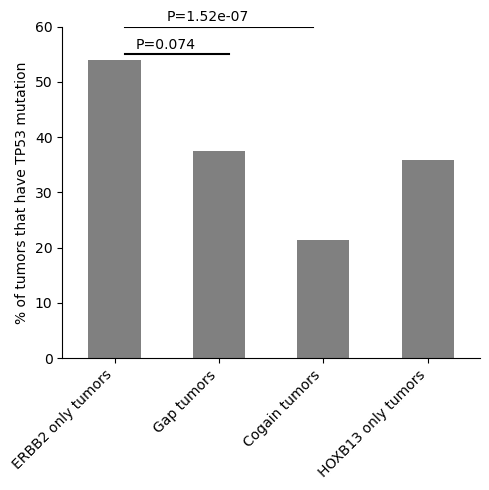

In [30]:
#Supplemental Figure 3E
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
TP53_figure_df["% of tumors"].plot(kind='bar', color = "grey")
ax.set_ylabel('% of tumors that have TP53 mutation')
ax.set_ylim(0, 60)
fig.autofmt_xdate(rotation=45)
#p values
fisher_df_tp53_erbb2vsgap = pd.DataFrame()
fisher_df_tp53_erbb2vsgap.loc["ERBB2only", "TP53 mutated"] = TP53_figure_df.loc["ERBB2 only tumors", "Number of tumors"]
fisher_df_tp53_erbb2vsgap.loc["ERBB2only", "TP53 not mutated"] = len(TCGA_BRCA_ERBB2only_participants) - TP53_figure_df.loc["ERBB2 only tumors", "Number of tumors"]
fisher_df_tp53_erbb2vsgap.loc["gap", "TP53 mutated"] = TP53_figure_df.loc["Gap tumors", "Number of tumors"]
fisher_df_tp53_erbb2vsgap.loc["gap", "TP53 not mutated"] = len(TCGA_BRCA_gap_participants) - TP53_figure_df.loc["Gap tumors", "Number of tumors"]

ax.axhline(y=55, xmin=0.15, xmax=0.4, color="black")
plt.text(0.2, 56, "P=" + str("{0:.3f}".format(fisher_exact(fisher_df_tp53_erbb2vsgap, alternative='two-sided')[1])))


fisher_df_tp53_erbb2vscogain = pd.DataFrame()
fisher_df_tp53_erbb2vscogain.loc["ERBB2only", "TP53 mutated"] = TP53_figure_df.loc["ERBB2 only tumors", "Number of tumors"]
fisher_df_tp53_erbb2vscogain.loc["ERBB2only", "TP53 not mutated"] = len(TCGA_BRCA_ERBB2only_participants) - TP53_figure_df.loc["ERBB2 only tumors", "Number of tumors"]
fisher_df_tp53_erbb2vscogain.loc["cogain", "TP53 mutated"] = TP53_figure_df.loc["Cogain tumors", "Number of tumors"]
fisher_df_tp53_erbb2vscogain.loc["cogain", "TP53 not mutated"] = len(TCGA_BRCA_co_gained_participants) - TP53_figure_df.loc["Cogain tumors", "Number of tumors"]
ax.axhline(y=60, xmin=0.15, xmax=0.6, color="black")
plt.text(0.5, 61, "P=" + str("{:.3}".format(fisher_exact(fisher_df_tp53_erbb2vscogain, alternative='two-sided')[1])))


plt.savefig("Figures/Supplemental_Figure3E.pdf")

Chisquared p value 2.528428680685736e-12


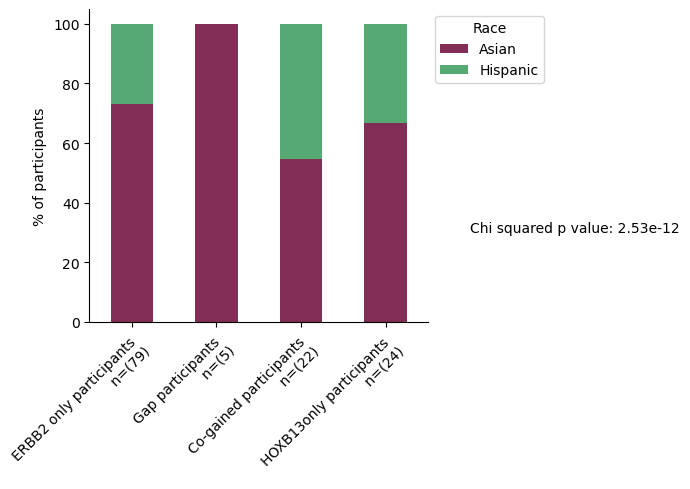

In [46]:
#Supplemental Figure 4
#validating race barplot with DeepDive cohort
deepdive_palette = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#812D55", "#56A973"])

deepdive_clinicalinfo = pd.DataFrame(pd.read_excel("Raw_data/DeepDive/NIHMS890993-supplement-Supplementary_Data.xlsx", index_col = 1))
deepdive_clinicalinfo.index = [str(x) for x in deepdive_clinicalinfo.index]
#dropping the two that are not in gistic
deepdive_clinicalinfo.drop(["nan"], axis = 0, inplace = True)
deepdive_gistic = pd.read_csv("Raw_data/DeepDive/all_thresholded.by_genes.txt", sep = "\t", index_col = 0)
deepdive_gistic = deepdive_gistic.drop(["Cytoband", "Locus ID"], axis = 1)
#mapping is not 1:1 on the names so trying to find it here
#there are two tpyes: those that contain _T and those whose starts match
#first take care of the _T ones
deepdive_gistic.columns = [x.split("_T")[0] for x in deepdive_gistic.columns]
deepdive_temp1 = deepdive_gistic.loc[:, np.in1d(deepdive_gistic.columns, deepdive_clinicalinfo.index)]
#now those whose starts match
deepdive_temp2 = deepdive_gistic.copy()
deepdive_temp2 = deepdive_temp2.drop(deepdive_gistic.loc[:, np.in1d(deepdive_gistic.columns, deepdive_clinicalinfo.index)].columns, axis = 1)
for x in deepdive_temp2.columns:
    for y in deepdive_clinicalinfo.index:
        if y.find(x):
            deepdive_clinicalinfo.loc[y, "dbGAP ID"] = x
            
#concatenating
final_deepdive_gistic = pd.concat([deepdive_temp1, deepdive_temp2], axis = 1)
#annotating
final_deepdive_gistic.loc["Ancestry"] = deepdive_clinicalinfo.transpose().loc["Ancestry"]
deepdive_BRCA_HER_gained_participants = final_deepdive_gistic.loc[:, final_deepdive_gistic.loc['ERBB2'] > 0].columns
deepdive_BRCA_HOX_gained_participants = final_deepdive_gistic.loc[:, final_deepdive_gistic.loc['HOXB13'] > 0].columns
deepdive_BRCA_HER_nongained_participants = final_deepdive_gistic.loc[:, final_deepdive_gistic.loc['ERBB2'] < 1].columns
deepdive_BRCA_HOX_nongained_participants = final_deepdive_gistic.loc[:, final_deepdive_gistic.loc['HOXB13'] < 1].columns
deepdive_BRCA_HOX_amped_participants = final_deepdive_gistic.loc[:, final_deepdive_gistic.loc['HOXB13'] > 1].columns


deepdive_BRCA_gap_participants = final_deepdive_gistic.loc[:, final_deepdive_gistic.loc['ERBB2'] > 0].columns & final_deepdive_gistic.loc[:, final_deepdive_gistic.loc['HOXB13'] > 0].columns & final_deepdive_gistic.loc[:, final_deepdive_gistic.loc['BRCA1'] < 0].columns
deepdive_BRCA_ERBB2only_participants = deepdive_BRCA_HER_gained_participants.intersection(deepdive_BRCA_HOX_nongained_participants)
deepdive_BRCA_co_gained_participants = (final_deepdive_gistic.loc[:, final_deepdive_gistic.loc['HOXB13'] > 0].columns) & (final_deepdive_gistic.loc[:, final_deepdive_gistic.loc['ERBB2'] > 0].columns) & (final_deepdive_gistic.loc[:, final_deepdive_gistic.loc['BRCA1'] > -1].columns)
deepdive_BRCA_HOXB13only_participants = deepdive_BRCA_HOX_gained_participants.intersection(deepdive_BRCA_HER_nongained_participants)

final_deepdive_gistic.loc["Status", deepdive_BRCA_gap_participants] = "Gap"
final_deepdive_gistic.loc["Status", deepdive_BRCA_co_gained_participants] = "Cogained"
final_deepdive_gistic.loc["Status", deepdive_BRCA_ERBB2only_participants] = "ERBB2 only"
final_deepdive_gistic.loc["Status", deepdive_BRCA_HOXB13only_participants] = "HOXB13 only"

#checking distribution of race across the 3 groups
deepdive_combined_racedf = pd.DataFrame()
deepdive_combined_racedf["ERBB2 only tumors"] = final_deepdive_gistic.loc["Ancestry", deepdive_BRCA_ERBB2only_participants].value_counts()
deepdive_combined_racedf["Gap tumors"] = final_deepdive_gistic.loc["Ancestry", deepdive_BRCA_gap_participants].value_counts()
deepdive_combined_racedf["Co-gained tumors"] = final_deepdive_gistic.loc["Ancestry", deepdive_BRCA_co_gained_participants].value_counts()
deepdive_combined_racedf["HOXB13 only tumors"] = final_deepdive_gistic.loc["Ancestry", deepdive_BRCA_HOXB13only_participants].value_counts()
deepdive_combined_racedf = deepdive_combined_racedf.fillna(0)
deepdive_combined_racedf = deepdive_combined_racedf.transpose()

#getting % values
for x in range (0, len(deepdive_combined_racedf.index)):
    deepdive_combined_racedf.iloc[x] = (deepdive_combined_racedf.iloc[x] * 100)/deepdive_combined_racedf.iloc[x].sum()

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
deepdive_combined_racedf.plot(kind='bar', stacked=True, ax = ax, colormap = deepdive_palette)
plt.xticks(rotation = 45)
ax.set_ylabel('% of participants')
ax.legend(bbox_to_anchor=(1.0, 1.0), title="Race")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
#p values
stat, p, dof, expected = chi2_contingency(deepdive_combined_racedf)
print("Chisquared p value", str(p))
plt.text(4, 30, "Chi squared p value: " + str("{:.3}".format(p)))
ax.set_xticklabels(['ERBB2 only participants \n n=(' + str(len(deepdive_BRCA_ERBB2only_participants)) + ")", 'Gap participants \n n=(' + str(len(deepdive_BRCA_gap_participants)) + ")", 'Co-gained participants \n n=(' + str(len(deepdive_BRCA_co_gained_participants)) + ")", 'HOXB13only participants \n n=(' + str(len(deepdive_BRCA_HOXB13only_participants)) + ")"])


plt.savefig('Figures/Supplemental_Figure4.pdf')

In [32]:
#covariate barplots
cohort_palette = {
    'Gap ': '#419450',
    'ERBB2 only ': '#592A5C',
    'Co-gained ': '#28387C',
    'HOXB13 only ': '#855607',
}


covariate_age_TCGA_df = TCGA_manuscript_spreadsheet.loc[TCGA_manuscript_spreadsheet["Cohort"] != "None"]
covariate_age_TCGA_df["Cohort"] = [x.split("tumors")[0] for x in covariate_age_TCGA_df["Cohort"]]

covariate_age_METABRIC_df = METABRIC_manuscript_spreadsheet.loc[METABRIC_manuscript_spreadsheet["Cohort"] != "None"]
covariate_age_METABRIC_df["Cohort"] = [x.split("tumors")[0] for x in covariate_age_METABRIC_df["Cohort"]]

cohort_palette = {
    'Gap': '#419450',
    'ERBB2 only': '#592A5C',
    'Co-gained': '#28387C',
    'HOXB13 only': '#855607',
}

covariate_stage_TCGA_df = pd.DataFrame(index = TCGA_manuscript_spreadsheet.loc[:, "Stage"].value_counts().index)
covariate_stage_TCGA_df["Gap"] = TCGA_manuscript_spreadsheet.loc[TCGA_BRCA_gap_participants, "Stage"].value_counts()
covariate_stage_TCGA_df["Co-gained"] = TCGA_manuscript_spreadsheet.loc[TCGA_BRCA_co_gained_participants, "Stage"].value_counts()
covariate_stage_TCGA_df["ERBB2 only"] = TCGA_manuscript_spreadsheet.loc[TCGA_BRCA_ERBB2only_participants, "Stage"].value_counts()
covariate_stage_TCGA_df["HOXB13 only"] = TCGA_manuscript_spreadsheet.loc[TCGA_BRCA_HOXB13only_participants, "Stage"].value_counts()

#fixing the labelling
covariate_stage_TCGA_df = covariate_stage_TCGA_df.fillna(0)

covariate_stage_TCGA_df.loc["Stage 1"] = covariate_stage_TCGA_df.loc["Stage I"] + covariate_stage_TCGA_df.loc["Stage IA"] + covariate_stage_TCGA_df.loc["Stage IB"]
covariate_stage_TCGA_df.loc["Stage 2"] = covariate_stage_TCGA_df.loc["Stage II"] + covariate_stage_TCGA_df.loc["Stage IIA"] + covariate_stage_TCGA_df.loc["Stage IIB"]
covariate_stage_TCGA_df.loc["Stage 3"] = covariate_stage_TCGA_df.loc["Stage III"] + covariate_stage_TCGA_df.loc["Stage IIIA"] + covariate_stage_TCGA_df.loc["Stage IIIB"] + covariate_stage_TCGA_df.loc["Stage IIIC"]
covariate_stage_TCGA_df.loc["Stage 4"] = covariate_stage_TCGA_df.loc["Stage IV"]

covariate_stage_TCGA_df.drop(['Stage IIA', 'Stage IIB', 'Stage IIIA', 'Stage I', 'Stage IA', 'Stage IIIC', 'Stage IIIB', 'Stage IV', 'Stage X', '[Discrepancy]', 'Stage II', 'Stage IB', '[Not Available]', 'Stage III'], inplace = True, axis = 0)

covariate_stage_METABRIC_df = pd.DataFrame(index = METABRIC_manuscript_spreadsheet.loc[:, "Stage"].value_counts().index)
covariate_stage_METABRIC_df["Gap"] = METABRIC_manuscript_spreadsheet.loc[METABRIC_gap_participants, "Stage"].value_counts()
covariate_stage_METABRIC_df["Co-gained"] = METABRIC_manuscript_spreadsheet.loc[METABRIC_coamp_participants, "Stage"].value_counts()
covariate_stage_METABRIC_df["ERBB2 only"] = METABRIC_manuscript_spreadsheet.loc[METABRIC_ERBB2amped_participants, "Stage"].value_counts()
covariate_stage_METABRIC_df["HOXB13 only"] = METABRIC_manuscript_spreadsheet.loc[METABRIC_HOXB13only_participants, "Stage"].value_counts()
covariate_stage_METABRIC_df.index = ["Stage {}".format(x) for x in covariate_stage_METABRIC_df.index]
covariate_stage_METABRIC_df = covariate_stage_METABRIC_df.dropna()
covariate_stage_METABRIC_df = covariate_stage_METABRIC_df.loc[["Stage 1", "Stage 2", "Stage 3"]]


covariate_nodalstatus_TCGA_df = pd.DataFrame(index = TCGA_manuscript_spreadsheet.loc[:, "Nodal status"].value_counts().index)
covariate_nodalstatus_TCGA_df["Gap"] = TCGA_manuscript_spreadsheet.loc[TCGA_BRCA_gap_participants, "Nodal status"].value_counts()
covariate_nodalstatus_TCGA_df["Co-gained"] = TCGA_manuscript_spreadsheet.loc[TCGA_BRCA_co_gained_participants, "Nodal status"].value_counts()
covariate_nodalstatus_TCGA_df["ERBB2 only"] = TCGA_manuscript_spreadsheet.loc[TCGA_BRCA_ERBB2only_participants, "Nodal status"].value_counts()
covariate_nodalstatus_TCGA_df["HOXB13 only"] = TCGA_manuscript_spreadsheet.loc[TCGA_BRCA_HOXB13only_participants, "Nodal status"].value_counts()


covariate_nodes_METABRIC_df = METABRIC_manuscript_spreadsheet.loc[METABRIC_manuscript_spreadsheet["Cohort"] != "None"]
covariate_nodes_METABRIC_df = covariate_nodes_METABRIC_df.dropna(subset = ["Number of positive lymph nodes"])
METABRIC_nodal_status_list = []
for x in covariate_nodes_METABRIC_df.index:
    number_of_nodes = covariate_nodes_METABRIC_df.loc[x, "Number of positive lymph nodes"]
    if number_of_nodes == 0:
        METABRIC_nodal_status_list.append("N0")
    if 1 <= number_of_nodes <= 3:
        METABRIC_nodal_status_list.append("N1")
    if 4 <= number_of_nodes <= 9:
        METABRIC_nodal_status_list.append("N2")
    if number_of_nodes > 9:
        METABRIC_nodal_status_list.append("N3")

covariate_nodes_METABRIC_df["Nodal status"] = METABRIC_nodal_status_list
covariate_nodes_METABRIC_df["Cohort"] = [x.split("tumors")[0] for x in covariate_nodes_METABRIC_df["Cohort"]]

final_covariate_nodes_METABRIC_df = pd.DataFrame(index = covariate_nodes_METABRIC_df.loc[:, "Nodal status"].value_counts().index)
final_covariate_nodes_METABRIC_df["Gap"] = covariate_nodes_METABRIC_df.loc[np.in1d(covariate_nodes_METABRIC_df.index, METABRIC_gap_participants), "Nodal status"].value_counts()
final_covariate_nodes_METABRIC_df["Co-gained"] = covariate_nodes_METABRIC_df.loc[np.in1d(covariate_nodes_METABRIC_df.index, METABRIC_coamp_participants), "Nodal status"].value_counts()
final_covariate_nodes_METABRIC_df["ERBB2 only"] = covariate_nodes_METABRIC_df.loc[np.in1d(covariate_nodes_METABRIC_df.index, METABRIC_ERBB2amped_participants), "Nodal status"].value_counts()
final_covariate_nodes_METABRIC_df["HOXB13 only"] = covariate_nodes_METABRIC_df.loc[np.in1d(covariate_nodes_METABRIC_df.index, METABRIC_HOXB13only_participants), "Nodal status"].value_counts()


<lifelines.CoxPHFitter: fitted with 495 total observations, 349 right-censored observations>
             duration col = 'PFI.time'
                event col = 'PFI'
      baseline estimation = breslow
   number of observations = 495
number of events observed = 146
   partial log-likelihood = -772.90
         time fit was run = 2024-11-16 19:35:33 UTC

---
                                           coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                        
Age (>=50 vs < 50)                        -0.17       0.84       0.20            -0.56             0.21                 0.57                 1.23
HOXB13 mRNA (>=0.66 or <0.33 percentile)   0.27       1.31       0.18            -0.08             0.61                 0.93                 1.84
Nodal status N1,2,3 (1) vs N0 (0)          0.47       1.60       0.19             0.09             0.84                 1.10                 2.32
Stage status 3/4 (1) vs. 1/2 (0)           0.59       1.80       0.22             0.15             1.02                 1.16                 2.78
Gap status                                 0.60       1.82       0.31            -0.02             1.22                 0.98                 3.37
BRCA1 GISTIC (>= 0 as (0) vs  <0 as (1))  -0.36       0.70       0.27            -0.88             0.17                 0.42                 1.18

                                           cmp to     z    p   -log2(p)
covariate                                                              
Age (>=50 vs < 50)                           0.00 -0.89 0.38       1.41
HOXB13 mRNA (>=0.66 or <0.33 percentile)     0.00  1.52 0.13       2.95
Nodal status N1,2,3 (1) vs N0 (0)            0.00  2.44 0.01       6.10
Stage status 3/4 (1) vs. 1/2 (0)             0.00  2.64 0.01       6.93
Gap status                                   0.00  1.91 0.06       4.16
BRCA1 GISTIC (>= 0 as (0) vs  <0 as (1))     0.00 -1.34 0.18       2.46
---
Concordance = 0.64
Partial AIC = 1557.80
log-likelihood ratio test = 27.66 on 6 df
-log2(p) of ll-ratio test = 13.17

<lifelines.CoxPHFitter: fitted with 374 total observations, 267 right-censored observations>
             duration col = 'PFI.time'
                event col = 'PFI'
      baseline estimation = breslow
   number of observations = 374
number of events observed = 107
   partial log-likelihood = -530.92
         time fit was run = 2024-11-16 19:35:33 UTC

---
                                           coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                        
Age (>=50 vs < 50)                        -0.37       0.69       0.25            -0.86             0.13                 0.42                 1.13
HOXB13 mRNA (>=0.66 or <0.33 percentile)   0.40       1.49       0.20             0.01             0.80                 1.01                 2.22
Nodal status N1,2,3 (1) vs N0 (0)          0.45       1.57       0.22             0.03             0.88                 1.03                 2.40
Stage status 3/4 (1) vs. 1/2 (0)           0.40       1.49       0.30            -0.19             0.98                 0.83                 2.66
Gap status                                 0.15       1.16       0.39            -0.61             0.92                 0.54                 2.50
BRCA1 GISTIC (>= 0 as (0) vs  <0 as (1))  -0.22       0.80       0.30            -0.80             0.36                 0.45                 1.43

                                           cmp to     z    p   -log2(p)
covariate                                                              
Age (>=50 vs < 50)                           0.00 -1.46 0.14       2.79
HOXB13 mRNA (>=0.66 or <0.33 percentile)     0.00  1.99 0.05       4.41
Nodal status N1,2,3 (1) vs N0 (0)            0.00  2.11 0.03       4.84
Stage status 3/4 (1) vs. 1/2 (0)             0.00  1.33 0.18       2.45
Gap status                                   0.00  0.39 0.70       0.52
BRCA1 GISTIC (>= 0 as (0) vs  <0 as (1))     0.00 -0.75 0.45       1.14
---
Concordance = 0.59
Partial AIC = 1073.85
log-likelihood ratio test = 15.45 on 6 df
-log2(p) of ll-ratio test = 5.87

<lifelines.CoxPHFitter: fitted with 121 total observations, 82 right-censored observations>
             duration col = 'PFI.time'
                event col = 'PFI'
      baseline estimation = breslow
   number of observations = 121
number of events observed = 39
   partial log-likelihood = -152.58
         time fit was run = 2024-11-16 19:35:34 UTC

---
                                           coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                        
Age (>=50 vs < 50)                        -0.04       0.96       0.36            -0.74             0.66                 0.48                 1.93
HOXB13 mRNA (>=0.66 or <0.33 percentile)  -0.18       0.84       0.39            -0.94             0.58                 0.39                 1.79
Nodal status N1,2,3 (1) vs N0 (0)          0.56       1.74       0.45            -0.33             1.44                 0.72                 4.22
Stage status 3/4 (1) vs. 1/2 (0)           0.88       2.41       0.38             0.13             1.63                 1.14                 5.10
Gap status                                 1.51       4.53       0.65             0.25             2.77                 1.28                16.04
BRCA1 GISTIC (>= 0 as (0) vs  <0 as (1))  -0.78       0.46       0.64            -2.03             0.47                 0.13                 1.59

                                           cmp to     z    p   -log2(p)
covariate                                                              
Age (>=50 vs < 50)                           0.00 -0.11 0.91       0.14
HOXB13 mRNA (>=0.66 or <0.33 percentile)     0.00 -0.46 0.65       0.63
Nodal status N1,2,3 (1) vs N0 (0)            0.00  1.24 0.22       2.21
Stage status 3/4 (1) vs. 1/2 (0)             0.00  2.31 0.02       5.58
Gap status                                   0.00  2.34 0.02       5.70
BRCA1 GISTIC (>= 0 as (0) vs  <0 as (1))     0.00 -1.23 0.22       2.19
---
Concordance = 0.72
Partial AIC = 317.16
log-likelihood ratio test = 18.78 on 6 df
-log2(p) of ll-ratio test = 7.78

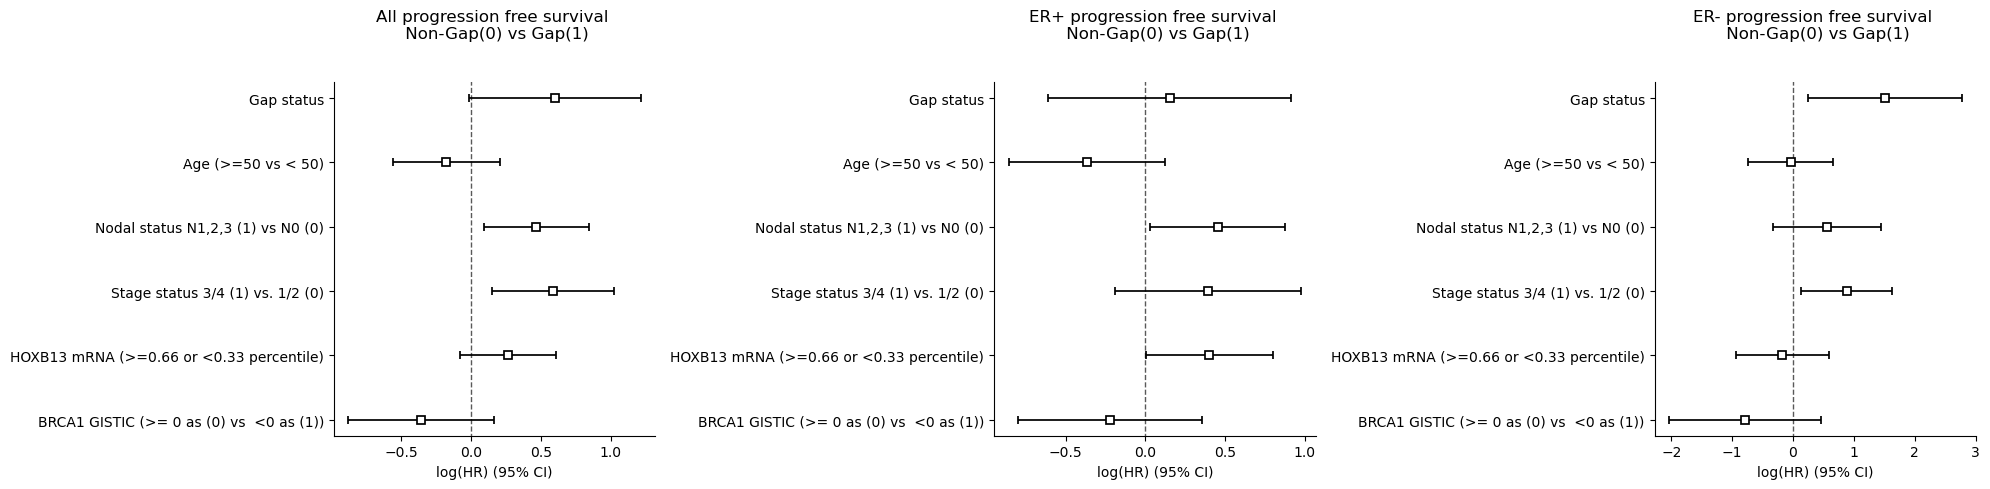

In [33]:
cox_survival = all_concatsurvival.copy()
#age covariate
cox_survival["Age"] = pd.concat([covariate_age_METABRIC_df, covariate_age_TCGA_df], axis = 0)["Age (years)"]
#dropping age and instead splitting by under 50 or <= 50
cox_survival["Age (>=50 vs < 50)"] = [0 if (x < 50)  else 1 for x in cox_survival["Age"]]
cox_survival = cox_survival.drop(["Age"], axis = 1)

#HOXb13 mRNA covariate
#since TCGA and METABRIC not same units, calculating upper and lower tertiles for both
from scipy.stats import percentileofscore

TCGA_BRCA_mRNA_tumor_data.loc["HOXB13 percentile"] = [percentileofscore(TCGA_BRCA_mRNA_tumor_data.loc["HOXB13"], x) for x in TCGA_BRCA_mRNA_tumor_data.loc["HOXB13"]]
METABRIC_mRNA_zscores.loc["HOXB13 percentile"] = [percentileofscore(METABRIC_mRNA_zscores.loc["HOXB13"], x) for x in METABRIC_mRNA_zscores.loc["HOXB13"]]

cox_survival["HOXB13 mRNA percentile"] = pd.concat([METABRIC_mRNA_zscores.loc[["HOXB13", "HOXB13 percentile"]], TCGA_BRCA_mRNA_tumor_data.loc[["HOXB13", "HOXB13 percentile"]]], axis = 1).loc["HOXB13 percentile"]
cox_survival["HOXB13 mRNA percentile"] = cox_survival["HOXB13 mRNA percentile"] .astype(int)
#cutting into upper and lower tertiles and removing the intermediate
cox_survival["HOXB13 mRNA (>=0.66 or <0.33 percentile)"] = [1 if (x >= 66) else (0 if (x <= 33) else np.nan) for x in cox_survival["HOXB13 mRNA percentile"]]
cox_survival.drop(["HOXB13 mRNA percentile"], axis = 1, inplace = True)

#nodal status covariate
#setting it as N0 (0) vs everything else (1)
nodal_concat_covariate = pd.concat([covariate_nodes_METABRIC_df, TCGA_manuscript_spreadsheet], axis = 0)["Nodal status"].astype(str)
nodal_concat_covariate_df = pd.DataFrame(nodal_concat_covariate).dropna(how = "any")
nodal_concat_covariate_df = nodal_concat_covariate_df.loc[nodal_concat_covariate_df["Nodal status"] != "nan"]
nodal_concat_covariate_df["Nodal status"] = [x.split("N")[1] for x in nodal_concat_covariate_df["Nodal status"]]
cox_survival["Nodal status"] = nodal_concat_covariate_df["Nodal status"]
cox_survival["Nodal status N1,2,3 (1) vs N0 (0)"] = [0 if x == "0" else 1 for x in cox_survival["Nodal status"]]
cox_survival.drop(["Nodal status"], axis = 1, inplace = True)

#stage covariate
stage_concat_covariate = pd.DataFrame(pd.concat([METABRIC_manuscript_spreadsheet, TCGA_manuscript_spreadsheet], axis = 0)["Stage"].astype(str))
#fixing the staging names
stage_concat_covariate.loc[stage_concat_covariate.loc[:, "Stage"] == "Stage I", "Stage"] = "1"
stage_concat_covariate.loc[stage_concat_covariate.loc[:, "Stage"] == "Stage IA", "Stage"] = "1"
stage_concat_covariate.loc[stage_concat_covariate.loc[:, "Stage"] == "Stage IB", "Stage"] = "1"
stage_concat_covariate.loc[stage_concat_covariate.loc[:, "Stage"] == "Stage II", "Stage"] = "2"
stage_concat_covariate.loc[stage_concat_covariate.loc[:, "Stage"] == "Stage IIA", "Stage"] = "2"
stage_concat_covariate.loc[stage_concat_covariate.loc[:, "Stage"] == "Stage IIB", "Stage"] = "2"
stage_concat_covariate.loc[stage_concat_covariate.loc[:, "Stage"] == "Stage IIC", "Stage"] = "2"
stage_concat_covariate.loc[stage_concat_covariate.loc[:, "Stage"] == "Stage III", "Stage"] = "3"
stage_concat_covariate.loc[stage_concat_covariate.loc[:, "Stage"] == "Stage IIIA", "Stage"] = "3"
stage_concat_covariate.loc[stage_concat_covariate.loc[:, "Stage"] == "Stage IIIB", "Stage"] = "3"
stage_concat_covariate.loc[stage_concat_covariate.loc[:, "Stage"] == "Stage IIIC", "Stage"] = "3"
stage_concat_covariate.loc[stage_concat_covariate.loc[:, "Stage"] == "Stage IV", "Stage"] = "4"
#not usable ones
stage_concat_covariate.loc[stage_concat_covariate.loc[:, "Stage"] == "Stage X", "Stage"] = np.nan
stage_concat_covariate.loc[stage_concat_covariate.loc[:, "Stage"] == "[Discrepancy]", "Stage"] = np.nan
stage_concat_covariate.loc[stage_concat_covariate.loc[:, "Stage"] == "[Not Available]", "Stage"] = np.nan
cox_survival["Stage"] = stage_concat_covariate["Stage"]
cox_survival["Stage status 3/4 (1) vs. 1/2 (0)"] = [0 if (x == "1") else 0 if (x == "2") else 1 for x in cox_survival["Stage"]]
cox_survival.drop(["Stage"], axis = 1, inplace = True)

#splitting into PFi and OS cos regression without GISTIC
cohort_OS_cox_survival = cox_survival.drop(["PFI.time", "PFI"], axis = 1)
cohort_PFI_cox_survival = cox_survival.drop(["OS.time", "OS"], axis = 1)

#ERBB2 amplification covariate
erbb2_amp_list = []
for x in cox_survival.index:
    if x in TCGA_BRCA_tumor_copynumber_data.columns:
        erbb2_amp_list.append(TCGA_BRCA_tumor_copynumber_data.loc["ERBB2", x])
    else:
        if x in METABRIC_copynumber_data.columns:
            erbb2_amp_list.append(METABRIC_copynumber_data.loc["ERBB2", x])
        else:
            erbb2_amp_list.append(np.nan)
        
cox_survival["ERBB2 GISTIC status"] = erbb2_amp_list

#HOXB13 amplification covariate
HOXB13_amp_list = []
for x in cox_survival.index:
    if x in TCGA_BRCA_tumor_copynumber_data.columns:
        HOXB13_amp_list.append(TCGA_BRCA_tumor_copynumber_data.loc["HOXB13", x])
    else:
        if x in METABRIC_copynumber_data.columns:
            HOXB13_amp_list.append(METABRIC_copynumber_data.loc["HOXB13", x])
        else:
            HOXB13_amp_list.append(np.nan)
        
cox_survival["HOXB13 GISTIC status"] = HOXB13_amp_list

#BRCA1 amplification covariate
BRCA1_amp_list = []
for x in cox_survival.index:
    if x in TCGA_BRCA_tumor_copynumber_data.columns:
        BRCA1_amp_list.append(TCGA_BRCA_tumor_copynumber_data.loc["BRCA1", x])
    else:
        if x in METABRIC_copynumber_data.columns:
            BRCA1_amp_list.append(METABRIC_copynumber_data.loc["BRCA1", x])
        else:
            BRCA1_amp_list.append(np.nan)
        
cox_survival["BRCA1 GISTIC status"] = BRCA1_amp_list

cox_survival.to_csv("Figures/All_both_BRCA_data_spreadsheet.csv", header = True, index = True)


cox_survival = cox_survival.drop(["Status"], axis = 1)
#dropping all nans
cox_survival = cox_survival.dropna(how = "any")

#splitting into PFi and OS cos regression
OS_cox_survival = cox_survival.drop(["PFI.time", "PFI"], axis = 1)
PFI_cox_survival = cox_survival.drop(["OS.time", "OS"], axis = 1)


#now doing cox per cohort but coding as Gap as 1 and all non-gap as 0
#split by status
all_cohort_PFI_cox_survival = cohort_PFI_cox_survival.copy()
all_cohort_PFI_cox_survival["Gap status"] = [1 if (x == "Gap")  else 0 for x in all_cohort_PFI_cox_survival["Status"]]
all_cohort_PFI_cox_survival.drop(["Status"], inplace = True, axis = 1)

#adding in BRCA1 GISTIC CN status
#-1 or 0 assigning to 0
#1 or 2 assiging to 1
BRCA1_CN_status_list = []
for x in all_cohort_PFI_cox_survival.index:
    if x in TCGA_BRCA_tumor_copynumber_data.columns:
        if TCGA_BRCA_tumor_copynumber_data.loc["BRCA1", x] < 0:
            BRCA1_CN_status_list.append(1)
        if TCGA_BRCA_tumor_copynumber_data.loc["BRCA1", x] >= 0:
            BRCA1_CN_status_list.append(0)
    else:
        if x in METABRIC_copynumber_data.columns:
            if METABRIC_copynumber_data.loc["BRCA1", x] < 0:
                BRCA1_CN_status_list.append(1)
            if METABRIC_copynumber_data.loc["BRCA1", x] >= 0:
                BRCA1_CN_status_list.append(0)
        else:
            BRCA1_CN_status_list.append(np.nan)
        
all_cohort_PFI_cox_survival["BRCA1 GISTIC (>= 0 as (0) vs  <0 as (1))"] = BRCA1_CN_status_list

ERpos_cohort_PFI_cox_survival = all_cohort_PFI_cox_survival.loc[np.in1d(all_cohort_PFI_cox_survival.index, list(TCGA_BRCA_ERpos_participants) + list(METABRIC_ERpos_participants))]
ERneg_cohort_PFI_cox_survival = all_cohort_PFI_cox_survival.loc[np.in1d(all_cohort_PFI_cox_survival.index, list(TCGA_BRCA_ERneg_participants) + list(METABRIC_ERneg_participants))]

all_cohort_PFI_cox_survival.to_excel('Figures/Supplemental_Figure5A.xlsx')

#PFI
fig, axarr = plt.subplots(1, 3, figsize=(20, 5))
dataset_list = [all_cohort_PFI_cox_survival, ERpos_cohort_PFI_cox_survival, ERneg_cohort_PFI_cox_survival]
title_list = ["All progression free survival", "ER+ progression free survival", "ER- progression free survival"]

list_counter = 0
for x in range (0, 1):
    for y in range (0, 3):
        chosen_dataset = dataset_list[list_counter]
        chosen_dataset = chosen_dataset.dropna()
        
        title_name = "{} \n Non-Gap(0) vs Gap(1)".format(title_list[list_counter])
        plt.sca(axarr[y])

        cph = CoxPHFitter()
        cph.fit(chosen_dataset, duration_col = 'PFI.time', event_col = 'PFI')
        cph.print_summary()

        cph.plot(columns = ['Gap status', 'Age (>=50 vs < 50)', 'Nodal status N1,2,3 (1) vs N0 (0)', 'Stage status 3/4 (1) vs. 1/2 (0)', 'HOXB13 mRNA (>=0.66 or <0.33 percentile)', "BRCA1 GISTIC (>= 0 as (0) vs  <0 as (1))"])
        plt.title(title_name)

        output_cph_df = pd.DataFrame(cph.summary)
        output_cph_df["Hazard ratio"] = cph.hazard_ratios_

        with pd.ExcelWriter('Figures/Supplemental_Figure5A.xlsx', engine='openpyxl', mode='a') as writer:
            output_cph_df.to_excel(writer,sheet_name='{}'.format(title_name))
            writer.save()  

        
        list_counter = list_counter+1
        

plt.savefig('Figures/Supplemental_Figure5A.pdf')


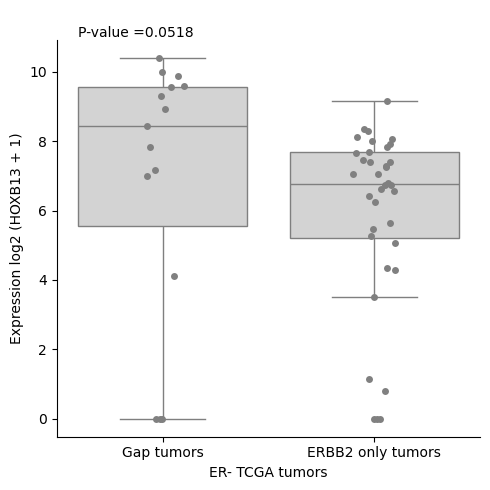

In [34]:
#Supplemental figure 5B
#ERBB2-only vs gap ER- for HOXB13 expression

#HOXB13 mRNA for the various groups with ER+/ER- split for each group
#making temporary dataframe to annotate
boxplot_palette = ["#419450", "#592A5C", "#28387C", "#818281"]
SuppFig4_tempdf = TCGA_BRCA_mRNA_tumor_data.loc[:, TCGA_BRCA_ERneg_participants].copy()
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
#adding 1 to HOXB13 to avoid the very small numbers giving large negative values
SuppFig4_tempdf.loc["log2 HOXB13"] = np.log2((SuppFig4_tempdf.loc["HOXB13"] + 1))
SuppFig4_tempdf.loc["Status"] = "HOXB13/ERBB2 no gain"

#making everything a set so operations work
TCGA_BRCA_ERBB2only_participants = set(TCGA_BRCA_ERBB2only_participants)
TCGA_BRCA_ERpos_participants = set(TCGA_BRCA_ERpos_participants)
TCGA_BRCA_ERneg_participants = set(TCGA_BRCA_ERneg_participants)
TCGA_BRCA_gap_participants = set(TCGA_BRCA_gap_participants)
TCGA_BRCA_co_gained_participants = set(TCGA_BRCA_co_gained_participants)

SuppFig4_tempdf.loc["Status", TCGA_BRCA_ERBB2only_participants] = "ERBB2 only tumors"
SuppFig4_tempdf.loc["Status", TCGA_BRCA_gap_participants] = "Gap tumors"

group_order = ["Gap tumors", "ERBB2 only tumors"]
sns.boxplot(order = group_order, y = SuppFig4_tempdf.loc["log2 HOXB13"], x = SuppFig4_tempdf.loc["Status"], color = "#d3d3d3", showfliers=False)
sns.stripplot(order = group_order, y = SuppFig4_tempdf.loc["log2 HOXB13"], x = SuppFig4_tempdf.loc["Status"], color = "grey")

ax.set_ylabel("Expression log2 (HOXB13 + 1)")
ax.set_xlabel("ER- TCGA tumors")
ax.text(-0.4, 11, '\nP-value ='  + str("{:.4f}".format(mannwhitneyu(list(SuppFig4_tempdf.loc["log2 HOXB13", TCGA_BRCA_ERBB2only_participants].dropna()), list(SuppFig4_tempdf.loc["log2 HOXB13", TCGA_BRCA_gap_participants].dropna()))[1])));


plt.savefig('Figures/Supplemental_Figure5B.pdf')

# From here on, the notebook produces relevant statistics for the manuscript

In [35]:
notpercent_figure2Atemp_HER2pos_ERBB2

,HER2pos
5+,64
2.0,30
3.0,13
4.0,12
1.0,9
5.0,5


In [36]:
#fixing some variable type issues
TCGA_BRCA_ERBB2only_participants = list(TCGA_BRCA_ERBB2only_participants)
TCGA_BRCA_HOXB13only_participants = list(TCGA_BRCA_HOXB13only_participants)
TCGA_BRCA_co_gained_participants = list(TCGA_BRCA_co_gained_participants)
TCGA_BRCA_gap_participants = list(TCGA_BRCA_gap_participants)

#values needed for manuscript
print("Number of HER2 gained ER+ tumors", len(set(TCGA_BRCA_ERpos_participants) & set(TCGA_BRCA_HER_gained_participants)))
print("Number of HER2 gained ER- tumors", len(set(TCGA_BRCA_ERneg_participants) & set(TCGA_BRCA_HER_gained_participants)))
print("Number of HOXB13 gained ER+ tumors", len(set(TCGA_BRCA_ERpos_participants) & set(TCGA_BRCA_HOX_gained_participants)))
print("Number of HOXB13 gained ER- tumors", len(set(TCGA_BRCA_ERneg_participants) & set(TCGA_BRCA_HOX_gained_participants)))
print("Number of HOXB13 HER2 cogained ER+ tumors", len(set(TCGA_BRCA_ERpos_participants) & set(TCGA_BRCA_HOX_gained_participants) & set(TCGA_BRCA_HER_gained_participants)))
print("Number of HOXB13 HER2 cogained ER- tumors", len(set(TCGA_BRCA_ERneg_participants) & set(TCGA_BRCA_HOX_gained_participants) & set(TCGA_BRCA_HER_gained_participants)))

#temporary boxplots for storing data
boxplot_1_data = {'Receptor status': ["Pos", "Neg"], 'Number of participants': [len(set(TCGA_BRCA_ERpos_participants) & set(TCGA_BRCA_HER_gained_participants)), len(set(TCGA_BRCA_ERneg_participants) & set(TCGA_BRCA_HER_gained_participants))], '% of participants': [len(set(TCGA_BRCA_ERpos_participants) & set(TCGA_BRCA_HER_gained_participants))*100/len(TCGA_BRCA_ERpos_participants), len(set(TCGA_BRCA_ERneg_participants) & set(TCGA_BRCA_HER_gained_participants))*100/len(TCGA_BRCA_ERneg_participants)]}
boxplot_1_df = pd.DataFrame (boxplot_1_data, columns = ['Receptor status','Number of participants', '% of participants'])

boxplot_2_data = {'Receptor status': ["Pos", "Neg"], 'Number of participants': [len(set(TCGA_BRCA_ERpos_participants) & set(TCGA_BRCA_HOX_gained_participants)), len(set(TCGA_BRCA_ERneg_participants) & set(TCGA_BRCA_HOX_gained_participants))], '% of participants': [len(set(TCGA_BRCA_ERpos_participants) & set(TCGA_BRCA_HOX_gained_participants))*100/len(TCGA_BRCA_ERpos_participants), len(set(TCGA_BRCA_ERneg_participants) & set(TCGA_BRCA_HOX_gained_participants))*100/len(TCGA_BRCA_ERneg_participants)]}
boxplot_2_df = pd.DataFrame (boxplot_2_data, columns = ['Receptor status','Number of participants', '% of participants'])

boxplot_3_data = {'Receptor status': ["Pos", "Neg"], 'Number of participants': [len(set(TCGA_BRCA_ERpos_participants) & set(TCGA_BRCA_HOX_gained_participants) & set(TCGA_BRCA_HER_gained_participants)), len(set(TCGA_BRCA_ERneg_participants) & set(TCGA_BRCA_HOX_gained_participants) & set(TCGA_BRCA_HER_gained_participants))], '% of participants': [len(set(TCGA_BRCA_ERpos_participants) & set(TCGA_BRCA_HER_gained_participants) & set(TCGA_BRCA_HOX_gained_participants))*100/len(TCGA_BRCA_ERpos_participants), len(set(TCGA_BRCA_ERneg_participants) & set(TCGA_BRCA_HER_gained_participants) & set(TCGA_BRCA_HOX_gained_participants))*100/len(TCGA_BRCA_ERneg_participants)]}
boxplot_3_df = pd.DataFrame (boxplot_3_data, columns = ['Receptor status','Number of participants', '% of participants'])

boxplot_3_df

Number of HER2 gained ER+ tumors 235
Number of HER2 gained ER- tumors 74
Number of HOXB13 gained ER+ tumors 237
Number of HOXB13 gained ER- tumors 52
Number of HOXB13 HER2 cogained ER+ tumors 185
Number of HOXB13 HER2 cogained ER- tumors 38


,Receptor status,Number of participants,% of participants
0,Pos,185,23.536896
1,Neg,38,16.379310


In [37]:
#fisher for the manuscript
fisher_df_1_temp = pd.DataFrame()
fisher_df_1_temp.loc["ER-", "HOX/HER coamp"] = len(set(TCGA_BRCA_ERneg_participants) & set(TCGA_BRCA_HOX_gained_participants) & set(TCGA_BRCA_HER_gained_participants))
fisher_df_1_temp.loc["ER+", "HOX/HER coamp"] = len(set(TCGA_BRCA_ERpos_participants) & set(TCGA_BRCA_HOX_gained_participants) & set(TCGA_BRCA_HER_gained_participants))
fisher_df_1_temp.loc["ER-", "HOX/HER not coamp"] = len(set(TCGA_BRCA_ERneg_participants)) - len(set(TCGA_BRCA_ERneg_participants) & set(TCGA_BRCA_HOX_gained_participants) & set(TCGA_BRCA_HER_gained_participants))
fisher_df_1_temp.loc["ER+", "HOX/HER not coamp"] = len(set(TCGA_BRCA_ERpos_participants)) - len(set(TCGA_BRCA_ERpos_participants) & set(TCGA_BRCA_HOX_gained_participants) & set(TCGA_BRCA_HER_gained_participants))

fisher_exact(fisher_df_1_temp, alternative='two-sided')


SignificanceResult(statistic=0.6363332404569518, pvalue=0.023669559042804433)

In [38]:
#for the manuscript
statistics_df1 = pd.DataFrame()
statistics_df1.loc["HOXB13 not gained", "ERBB2 not gained"] = 36+450+175+5
statistics_df1.loc["HOXB13 gained", "ERBB2 not gained"] = 37+17+11+12
statistics_df1.loc["HOXB13 not gained", "ERBB2 gained"] = 15+10+14+48
statistics_df1.loc["HOXB13 gained", "ERBB2 gained"] = 175+27+5+33

fisher_exact(statistics_df1, alternative='two-sided')

SignificanceResult(statistic=23.8602776533811, pvalue=2.0501908348886794e-94)

In [39]:
boxplot_3_df

,Receptor status,Number of participants,% of participants
0,Pos,185,23.536896
1,Neg,38,16.379310


In [40]:
#fisher for the manuscript
fisher_df_2_temp = pd.DataFrame()
fisher_df_2_temp.loc["ER-", "HOX/HER coamp"] = len(set(METABRIC_ERneg_participants) & set(METABRIC_HOXB13gained_participants) & set(METABRIC_ERBB2gained_participants))
fisher_df_2_temp.loc["ER+", "HOX/HER coamp"] = len(set(METABRIC_ERpos_participants) & set(METABRIC_HOXB13gained_participants) & set(METABRIC_ERBB2gained_participants))
fisher_df_2_temp.loc["ER-", "HOX/HER not coamp"] = len(set(METABRIC_ERneg_participants)) - len(set(METABRIC_ERneg_participants) & set(METABRIC_HOXB13gained_participants) & set(METABRIC_ERBB2gained_participants))
fisher_df_2_temp.loc["ER+", "HOX/HER not coamp"] = len(set(METABRIC_ERpos_participants)) - len(set(METABRIC_ERpos_participants) & set(METABRIC_HOXB13gained_participants) & set(METABRIC_ERBB2gained_participants))

fisher_exact(fisher_df_2_temp, alternative='two-sided')


SignificanceResult(statistic=0.6263157894736842, pvalue=0.04117495437350975)

In [41]:
#making everything a set so operations work
TCGA_BRCA_ERBB2only_participants = set(TCGA_BRCA_ERBB2only_participants)
TCGA_BRCA_ERpos_participants = set(TCGA_BRCA_ERpos_participants)
TCGA_BRCA_ERneg_participants = set(TCGA_BRCA_ERneg_participants)
TCGA_BRCA_gap_participants = set(TCGA_BRCA_gap_participants)
TCGA_BRCA_co_gained_participants = set(TCGA_BRCA_co_gained_participants)
TCGA_BRCA_HOXB13only_participants = set(TCGA_BRCA_HOXB13only_participants)

#Not a figure, just data for the manucript - HOXB13/IL17RB mRNA for the various groups with ER+/ER- split for each group
TCGA_BRCA_mRNA_tumor_data.loc["HOXB13/IL17RB"] = TCGA_BRCA_mRNA_tumor_data.loc["HOXB13"]/TCGA_BRCA_mRNA_tumor_data.loc["IL17RB"]
#making temporary dataframe to annotate
Figure6C_tempdf = TCGA_BRCA_mRNA_tumor_data.copy()
#adding 1 to IL17RB to avoid dividng by zero errors
Figure6C_tempdf.loc["log2 HOXB13/IL17RB"] = np.log2((Figure6C_tempdf.loc["HOXB13"] + 1)/(Figure6C_tempdf.loc["IL17RB"] + 1))
Figure6C_tempdf.loc["Status"] = "HOXB13/ERBB2 no gain"

Figure6C_tempdf.loc["Status", (TCGA_BRCA_ERBB2only_participants & TCGA_BRCA_ERpos_participants)] = "ER+ ERBB2 only tumors"
Figure6C_tempdf.loc["Status", (TCGA_BRCA_co_gained_participants & TCGA_BRCA_ERpos_participants)] = "ER+ co-gain tumors"
Figure6C_tempdf.loc["Status", (TCGA_BRCA_gap_participants & TCGA_BRCA_ERpos_participants)] = "ER+ Gap tumors"
Figure6C_tempdf.loc["Status", (TCGA_BRCA_ERBB2only_participants & TCGA_BRCA_ERneg_participants)] = "ER- ERBB2 only tumors"
Figure6C_tempdf.loc["Status", (TCGA_BRCA_co_gained_participants & TCGA_BRCA_ERneg_participants)] = "ER- co-gain tumors"
Figure6C_tempdf.loc["Status", (TCGA_BRCA_gap_participants & TCGA_BRCA_ERneg_participants)] = "ER- Gap tumors"

group_order = ["HOXB13/ERBB2 no gain", "ER+ ERBB2 only tumors", "ER+ co-gain tumors", "ER+ Gap tumors", "ER- ERBB2 only tumors", "ER- co-gain tumors", "ER- Gap tumors"]

#make list of all pairwise p vals here
p_val_table = pd.DataFrame(columns = group_order, index = group_order)
for x in group_order:
    for y in group_order:
        if (x != y):
            p_val_table.loc[x, y] = mannwhitneyu(list(Figure6C_tempdf.loc[:, Figure6C_tempdf.loc["Status"] == x].loc["HOXB13/IL17RB"].dropna()), list(Figure6C_tempdf.loc[:, Figure6C_tempdf.loc["Status"] == y].loc["HOXB13/IL17RB"].dropna()))[1]

#repeating but not stratified by ER IHC
#Figure - HOXB13/IL17RB mRNA for the various groups with ER+/ER- split for each group
#making temporary dataframe to annotate
Figure6C_tempdf = TCGA_BRCA_mRNA_tumor_data.copy()
#adding 1 to IL17RB to avoid dividng by zero errors
Figure6C_tempdf.loc["log2 HOXB13/IL17RB"] = np.log2((Figure6C_tempdf.loc["HOXB13"] + 1)/(Figure6C_tempdf.loc["IL17RB"] + 1))
Figure6C_tempdf.loc["Status"] = "HOXB13/ERBB2 no gain"

#making everything a set so operations work
TCGA_BRCA_ERBB2only_participants = set(TCGA_BRCA_ERBB2only_participants)
TCGA_BRCA_ERpos_participants = set(TCGA_BRCA_ERpos_participants)
TCGA_BRCA_ERneg_participants = set(TCGA_BRCA_ERneg_participants)
TCGA_BRCA_gap_participants = set(TCGA_BRCA_gap_participants)
TCGA_BRCA_co_gained_participants = set(TCGA_BRCA_co_gained_participants)

Figure6C_tempdf.loc["Status", TCGA_BRCA_ERBB2only_participants] = "ERBB2 only tumors"
Figure6C_tempdf.loc["Status", TCGA_BRCA_co_gained_participants] = "co-gain tumors"
Figure6C_tempdf.loc["Status", TCGA_BRCA_gap_participants] = "Gap tumors"

group_order = ["HOXB13/ERBB2 no gain", "ERBB2 only tumors", "co-gain tumors", "Gap tumors"]

#make list of all pairwise p vals here
p_val_table = pd.DataFrame(columns = group_order, index = group_order)
for x in group_order:
    for y in group_order:
        if (x != y):
            p_val_table.loc[x, y] = mannwhitneyu(list(Figure6C_tempdf.loc[:, Figure6C_tempdf.loc["Status"] == x].loc["HOXB13/IL17RB"].dropna()), list(Figure6C_tempdf.loc[:, Figure6C_tempdf.loc["Status"] == y].loc["HOXB13/IL17RB"].dropna()))[1]


In [42]:
#for the manuscript
#what % of HOXB13 amp co-occur with her2 amp?
cogained_pts = (TCGA_BRCA_tumor_copynumber_data.loc[:, TCGA_BRCA_tumor_copynumber_data.loc['HOXB13'] > 0].columns) & (TCGA_BRCA_tumor_copynumber_data.loc[:, TCGA_BRCA_tumor_copynumber_data.loc['ERBB2'] > 0].columns)
coamped_pts = (TCGA_BRCA_tumor_copynumber_data.loc[:, TCGA_BRCA_tumor_copynumber_data.loc['HOXB13'] > 1].columns) & (TCGA_BRCA_tumor_copynumber_data.loc[:, TCGA_BRCA_tumor_copynumber_data.loc['ERBB2'] > 1].columns)
her2amped_pts = (TCGA_BRCA_tumor_copynumber_data.loc[:, TCGA_BRCA_tumor_copynumber_data.loc['ERBB2'] > 1].columns)
her2gained_pts = (TCGA_BRCA_tumor_copynumber_data.loc[:, TCGA_BRCA_tumor_copynumber_data.loc['ERBB2'] > 0].columns)


print(100*len(set(coamped_pts))/len(TCGA_BRCA_HOX_amped_participants))
print(100*len(set(cogained_pts))/len(TCGA_BRCA_HOX_gained_participants))


64.70588235294117
78.17589576547232


In [43]:
#fisher for gain
hoxgain_fisher = pd.DataFrame()
hoxgain_fisher.loc["HOXB13 gain", "HER2 gain"] = len(set(cogained_pts))
hoxgain_fisher.loc["HOXB13 gain", "HER2 not gain"] = len(set((TCGA_BRCA_tumor_copynumber_data.loc[:, TCGA_BRCA_tumor_copynumber_data.loc['HOXB13'] > 0].columns) & (TCGA_BRCA_tumor_copynumber_data.loc[:, TCGA_BRCA_tumor_copynumber_data.loc['ERBB2'] < 1].columns)))
hoxgain_fisher.loc["HOXB13 not gain", "HER2 gain"] = len(set((TCGA_BRCA_tumor_copynumber_data.loc[:, TCGA_BRCA_tumor_copynumber_data.loc['HOXB13'] < 1].columns) & (TCGA_BRCA_tumor_copynumber_data.loc[:, TCGA_BRCA_tumor_copynumber_data.loc['ERBB2'] > 0].columns)))
hoxgain_fisher.loc["HOXB13 not gain", "HER2 not gain"] = len(set((TCGA_BRCA_tumor_copynumber_data.loc[:, TCGA_BRCA_tumor_copynumber_data.loc['HOXB13'] < 1].columns) & (TCGA_BRCA_tumor_copynumber_data.loc[:, TCGA_BRCA_tumor_copynumber_data.loc['ERBB2'] < 1].columns)))

fisher_exact(hoxgain_fisher, alternative='two-sided')

SignificanceResult(statistic=27.421513124035, pvalue=3.5731424865971877e-99)

In [44]:
#fisher for amp
hoxamp_fisher = pd.DataFrame()
hoxamp_fisher.loc["HOXB13 amp", "HER2 amp"] = len(set(coamped_pts))
hoxamp_fisher.loc["HOXB13 amp", "HER2 not amp"] = len(set((TCGA_BRCA_tumor_copynumber_data.loc[:, TCGA_BRCA_tumor_copynumber_data.loc['HOXB13'] > 1].columns) & (TCGA_BRCA_tumor_copynumber_data.loc[:, TCGA_BRCA_tumor_copynumber_data.loc['ERBB2'] < 2].columns)))
hoxamp_fisher.loc["HOXB13 not amp", "HER2 amp"] = len(set((TCGA_BRCA_tumor_copynumber_data.loc[:, TCGA_BRCA_tumor_copynumber_data.loc['HOXB13'] < 2].columns) & (TCGA_BRCA_tumor_copynumber_data.loc[:, TCGA_BRCA_tumor_copynumber_data.loc['ERBB2'] > 1].columns)))
hoxamp_fisher.loc["HOXB13 not amp", "HER2 not amp"] = len(set((TCGA_BRCA_tumor_copynumber_data.loc[:, TCGA_BRCA_tumor_copynumber_data.loc['HOXB13'] < 2].columns) & (TCGA_BRCA_tumor_copynumber_data.loc[:, TCGA_BRCA_tumor_copynumber_data.loc['ERBB2'] < 2].columns)))

fisher_exact(hoxamp_fisher, alternative='two-sided')

SignificanceResult(statistic=18.95131086142322, pvalue=8.199809607132458e-21)